# IOB for CMB spectra
---
**Environment**: Run `Conda env create -f operon.yaml` to replicate the environment I have tested. All dependence including `torch` are in `operon.yaml`;

**Data source**: infinity: /data77/xiaosheng/IOB_cmb_data/camb_new_TT.zip 

 cp and `unzip camb_new_TT.zip` under the `./data/camb_new/` folder; There are 10000 raw TT samples that is about 196 Mb. Data format: data[:6] are the 6 cosmological parameters; data[6:] are the TT power spectrum with l={2,3,...2500}
 
Similarly, for **Polarized CMB**:

- TE: /data77/xiaosheng/IOB_cmb_data/camb_new_TE.zip;
- EE: /data77/xiaosheng/IOB_cmb_data/camb_new_EE.zip;

can unzip under the `./data/camb_new/` folder for further use

**With command lines**:

- **python generate_ps.py** (optionally)
- **python create_noised_data.py --cmb_type=TT**(optionally, need run at the first time)
- **python train.py --model_name=shallow96 --epoch=2048 --cmb_type=TT** (may need to comment `os.environ["CUDA_VISIBLE_DEVICES"]` in the beginning)
- **python test.py --model_name=shallow96 --cmb_type=TT** (may need to comment `os.environ["CUDA_VISIBLE_DEVICES"]` in the beginning)
- **python operon.py --model_name=shallow96 --cmb_type=TT --operon_name=run1**
- **python replace.py --model_name=shallow96 --cmb_type=TT --operon_name=run1 --thin=200** (may need to comment `os.environ["CUDA_VISIBLE_DEVICES"]` in the beginning)

the last command will output two csv files "pareto\_good\_model\_\*" and "individuals\_good_model\_" under the `./data/sr/` folder. They are the "good" expressions of the first latent from operon. When replacing the first latent with the outputs from these expressions, the final weighted mse in the data space is less than 1. The two files correspond to the expressions from the pareto front and all 2000 individual expressions during each operon run.

**File structure** under `IOB_cmb`:
```
IOB_cmb
└───README.md
└───operon.yaml (environment)
└───data
|    └─── camb_new (raw data)
|    └─── camb_new_processed (processed data)
|    └─── sr (outputs of symbolic regression)
└───model (save the best checkpoint during training) 
└───process files
|    └─── generate_ps.py
|    └─── create_noised_data.py
|    └─── train.py
|    └─── test.py
|    └─── operon.py
|    └─── replace.py   
└───functional files
|   └─── operon_sklearn.py
|   └─── pytorchtools.py
|   └─── model_cmb.py
|   └─── load_data_cmb.py
└───example notebook
|   └─── IOB_for_CMB_spectra.ipynb
```

`References`
- [camb notebook](https://camb.readthedocs.io/en/latest/CAMBdemo.html)
- [pyoperon](https://github.com/heal-research/pyoperon)
- Refer to [Pytorch IOBs](https://github.com/maho3/pytorch-iobs) and [paper](https://arxiv.org/abs/2305.11213) for more about the IOB methodology and applications.

`Main contents`
* [Prepare the data](#data)
  - [Generate the TT/TE/EE data (re-generate if need)](#create_cmb_data)
  - [Create noised data](#noised_data)
* [Train the encoder-decoder](#train)
* [Test and variation of the latents](#test)
* [SR with pyoperon](#operon)
* [Inspect the data space](#weighted)

**With jupyter notebook**

* Run [Generate the TT/TE/EE data (re-generate if need)](#create_cmb_data) (and uncomment the corresponding lines) to generate TE and EE data, can skip if do not need;
* Run [Create noised data](#noised_data) to post-process the TT data (adding cosmic variance and rescaling);
* Can just turn to [Train the encoder-decoder](#train), if the data are already post-processed;
* Can just turn to [Test and variation of the latents](#test), [SR with pyoperon](#operon), and [Inspect the data space (replacement of latents)](#weighted), if you do not want to retrain the model.

## Import packages and define some useful variables

In [1]:
types = 'TT' # Type of CMB PS
model_name = 'shallow96_noised_test' # Re-announced in the "Train the encoder-decoder" section
name=types+'_'+model_name # The name of this experiments

In [2]:
### Directly copy from the "Train the encoder-decoder" section

# The packages for training
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
import torch.optim as optim
from torch.utils.data import random_split
from pytorchtools import EarlyStopping
from random import randint, random
from torch.utils.data import Dataset
from torch import nn
from model_cmb import Encoder_cmb, Decoder_cmb, maskin_cmb
from load_data_cmb import CMBDataset

# Plotting setting
import matplotlib as mpl
mpl.style.use('paper.mcstyle')

############################################################### Key parameters to vary
d_encode=6 #128, the bottleneck dimension
lr= 1e-5
num_epochs =2048 #2048
patience=20 # The patience for early stopping of the training. 
################################################################

### Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

### Prepare the data
data_dir = './data/camb_new_processed/d_normed_new_noised_%s.npy'%types
data_mean_dir = './data/camb_new_processed/d_normed_new_noised_mean_%s.npy'%types
para_dir = './data/camb_new_processed/p_normed_new_noised_%s.npy'%types
err_dir = './data/camb_new_processed/e_normed_new_noised_%s.npy'%types

batch_size = 128
dataset = CMBDataset(data_dir,data_mean_dir,para_dir,err_dir)

torch.manual_seed(43)
val_size = 500 
test_size = 500
train_size = len(dataset) - val_size - test_size
X_train, X_valid, X_test= random_split(dataset, [train_size, val_size, test_size])

# data loader setup
train_loader = torch.utils.data.DataLoader(X_train,batch_size=batch_size,shuffle=True,num_workers=0,pin_memory=(device == device))
valid_loader = torch.utils.data.DataLoader(X_valid,batch_size=batch_size,shuffle=True,num_workers=0,pin_memory=(device == device))
test_loader = torch.utils.data.DataLoader(X_test,batch_size=batch_size,shuffle=False,num_workers=0,pin_memory=(device == device))

Selected device: cuda


<a id='data'></a>
## Prepare the data

### Camb input parameters
Parameters $x$:  $\{x_0,x_1,x_2,x_3,x_4,x_5\}=\{\Omega_b h^2, \Omega_c h^2, \tau, A_s, n_s, h\}$

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.4.0 installed at /home/zxs/miniconda3/envs/operon/lib/python3.9/site-packages/camb


In [58]:
cmb_para=np.load('./data/camb_new_processed/parameters.npy')
print (cmb_para.shape)

(10000, 6)


(array([ 961.,  994.,  969.,  992., 1024.,  991., 1008., 1005.,  991.,
        1065.]),
 array([0.05000186, 0.05250157, 0.05500127, 0.05750098, 0.06000068,
        0.06250039, 0.06500009, 0.0674998 , 0.06999951, 0.07249921,
        0.07499892]),
 <BarContainer object of 10 artists>)

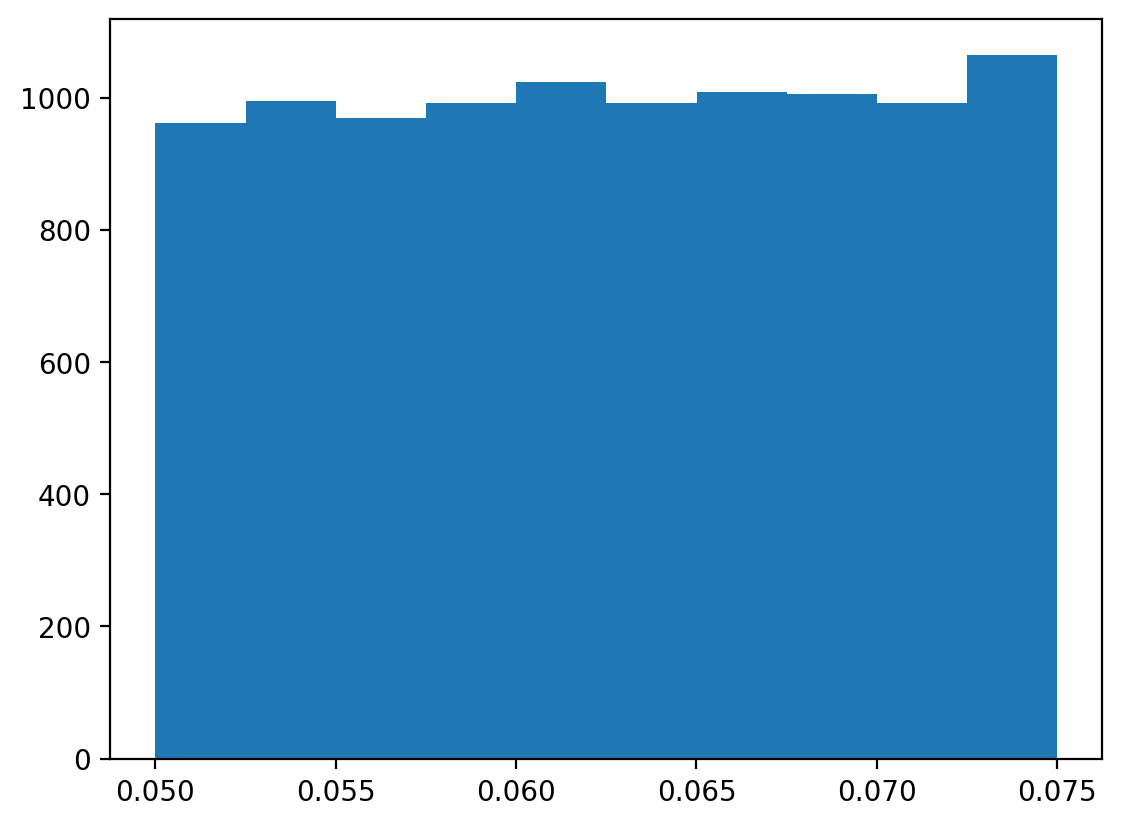

In [6]:
plt.hist(cmb_para[:,2])

In [7]:
names=['Omega_b h^2', 'Omega_c h^2', 'tau','A_s', 'n_s', 'h']
for i in range(6):
    if i!=3:
        print (r"{:s}:[{:.4f},{:.4f}]".format(names[i],np.min(cmb_para[:,i]),np.max(cmb_para[:,i])))
    else:
        print (r"{:s}:[{:.4e},{:.4e}]".format(names[i],np.min(cmb_para[:,i]),np.max(cmb_para[:,i])))

Omega_b h^2:[0.0074,0.0445]
Omega_c h^2:[0.0362,0.1897]
tau:[0.0500,0.0750]
A_s:[1.6001e-09,2.2667e-09]
n_s:[0.9333,1.0000]
h:[0.6000,0.8000]


<a id='create_cmb_data'></a>
### Generate the TT/TE/EE data (re-generate if need)

In [ ]:
import os
import numpy as np
import multiprocessing
import camb
from camb import model, initialpower

cmb_para=np.load('./data/camb_new_processed/parameters.npy')
n_sample=cmb_para.shape[0]

def cal_camb(i):
    camb_TT_new=np.zeros((2499+6)) # l={2,3,...2500}, n_param = 6
    camb_TE_new=np.zeros((2499+6))
    camb_EE_new=np.zeros((2499+6))
    
    #Set up a new set of parameters for CAMB
    pars = camb.CAMBparams()
    #This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
    pars.set_cosmology(H0=cmb_para[i,5]*100, ombh2=cmb_para[i,0], omch2=cmb_para[i,1], mnu=0.06, omk=0, tau=cmb_para[i,2])
    pars.InitPower.set_params(As=cmb_para[i,3], ns=cmb_para[i,4], r=0)
    pars.set_for_lmax(2500, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
    unlensedCL=powers['unlensed_scalar']
    camb_TT_new[6:]=unlensedCL[2:2501,0] # TT
    #camb_TE_new[6:]=unlensedCL[2:2501,3] # TE
    #camb_EE_new[6:]=unlensedCL[2:2501,1] # EE
    camb_TT_new[:6]=cmb_para[i,:]
    #camb_TE_new[:6]=cmb_para[i,:]
    #camb_EE_new[:6]=cmb_para[i,:]

    np.save(f'./data/camb_new/camb_TT_{i}.npy', camb_TT_new)
    #np.save(f'./data/cmb/camb_new/camb_TE_{i}.npy', camb_TE_new)
    #np.save(f'./data/cmb/camb_new/camb_EE_{i}.npy', camb_EE_new)

for i in range(6616,n_sample):
    cal_camb(i)
#if __name__ == '__main__':
##    cores = multiprocessing.cpu_count()
#    print (cores)
#    pool = multiprocessing.Pool(processes=20)
#    num = range(n_sample)
#    pool.map(cal_camb, num)

<a id='noised_data'></a>
### Create noised data

Data: CMB $C_l$ (TT), maximum $l$: 2500

Data variance: $Var = \frac{2}{2l+1}C_l^2$

The model we used in **camb** package considers "one massive neutrino and helium set using BBN consistency" — $m_\nu=0.06$. Also, curvature of the universe $\Omega_k=0$, the tensor-to-scalar ratio $r=0$ and unlensed $C_l$ is calculated.

Preprocessing: 
1. Parameters:
$x^\prime=\frac{x-min(x)}{max(x)-min(x)}$
2. Data:
$C_l = C_l + N(0,\mathrm{sqrt}(Var))-\mathrm{min}+1$ (positive values), $C_l^\prime=log_{10}(C_l)$, $C_l^{\prime \prime}=\frac{C_l^\prime-min(C_l^\prime)}{max(C_l^\prime)-min(C_l^\prime)}$
3. Error propagation

In [90]:
import glob
files=glob.glob('./data/camb_new/*TT*npy')
data=[]
for i in range(len(files)):
    d=np.load(files[i])
    data.append(d)
data=np.array(data)
l=np.arange(2,2501)

error=(2/(2*l+1))*data[:,6:]**2

np.random.seed(0)
data_noise = np.random.normal(0,np.sqrt(error))+data[:,6:]
min_temp = np.min(data_noise)
data_noise = data_noise - min_temp + 1 # Ensure a positive array

#### The rescaled powerspectra

In [3]:
para_min=np.min(data[:,:6],axis=0)
para_max=np.max(data[:,:6],axis=0)
para_norm=(data[:,:6]-para_min)/(para_max-para_min)

data_min=np.min(np.log10(data_noise),axis=0)
data_max=np.max(np.log10(data_noise),axis=0)

data_norm=(np.log10(data_noise)-data_min)/(data_max-data_min)
err_norm=error/(data_max-data_min)**2/(data_noise*np.log(10))**2

np.save('./data/camb_new_processed/p_normed_new_noised.npy',para_norm)
np.save('./data/camb_new_processed/d_normed_new_noised.npy',data_norm)
np.save('./data/camb_new_processed/e_normed_new_noised.npy',err_norm)

In [4]:
np.save('./data/camb_new_processed/min_temp.npy',min_temp)
np.save('./data/camb_new_processed/data_min.npy',data_min)
np.save('./data/camb_new_processed/data_max.npy',data_max)

#### The rescaled mean of the powerspectra

In [5]:
data_noise_mean = data[:,6:]
data_noise_mean = data_noise_mean - min_temp + 1

In [6]:
# Save the mean spectra
data_norm_mean=(np.log10(data_noise_mean)-data_min)/(data_max-data_min)
np.save('./data/camb_new_processed/d_normed_new_noised_mean.npy',data_norm_mean)

([<matplotlib.axis.XTick at 0x7fed0e4e2c10>,
 [Text(2, 0, '2'),
  Text(500, 0, '500'),
  Text(1000, 0, '1000'),
  Text(1500, 0, '1500'),
  Text(2000, 0, '2000'),
  Text(2500, 0, '2500')])

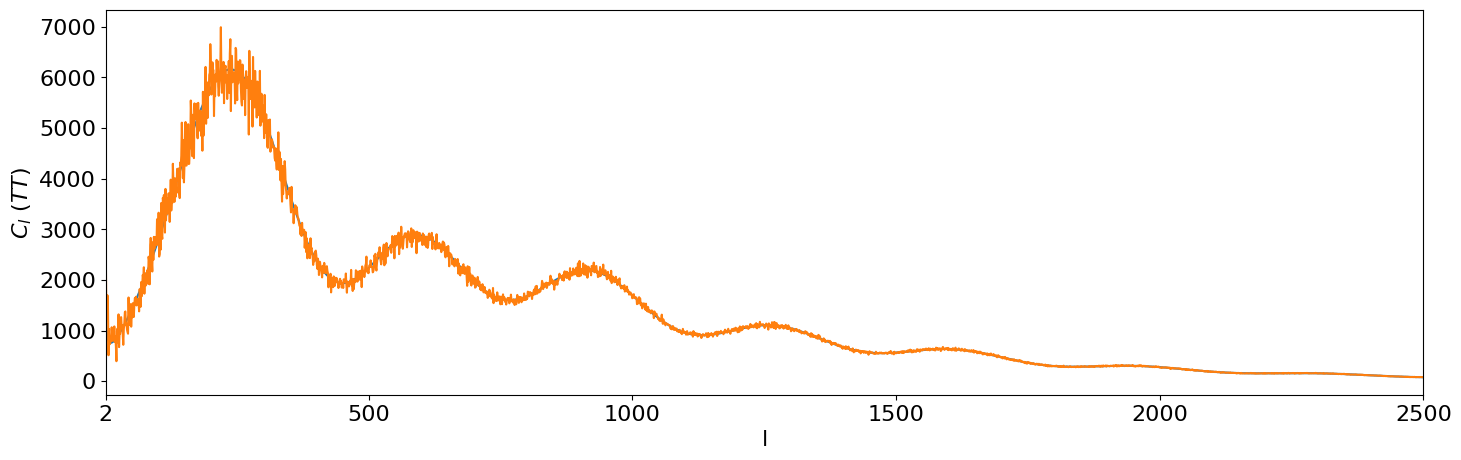

In [94]:
#%matplotlib widget

import glob
files=glob.glob('./data/camb_new/*TT*npy')
data=[]
for i in range(len(files)):
    d=np.load(files[i])
    data.append(d)
data=np.array(data)
l=np.arange(2,2501)

error=(2/(2*l+1))*data[:,6:]**2

np.random.seed(0)
data_noise = np.random.normal(0,np.sqrt(error))+data[:,6:]

plt.figure(figsize=(17,5))

ax = plt.subplot(1, 1, 1)
l = np.arange(2,2501)
plt.plot(l,data[0,6:],label='Mean')
plt.plot(l,data_noise[0],label='With cosmic variance')
plt.xlabel('l',fontsize=16)
plt.ylabel(r'$C_l\ (TT)$',fontsize=16)
#plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.xlim(2,2500)
plt.xticks([2,500,1000,1500,2000,2500])

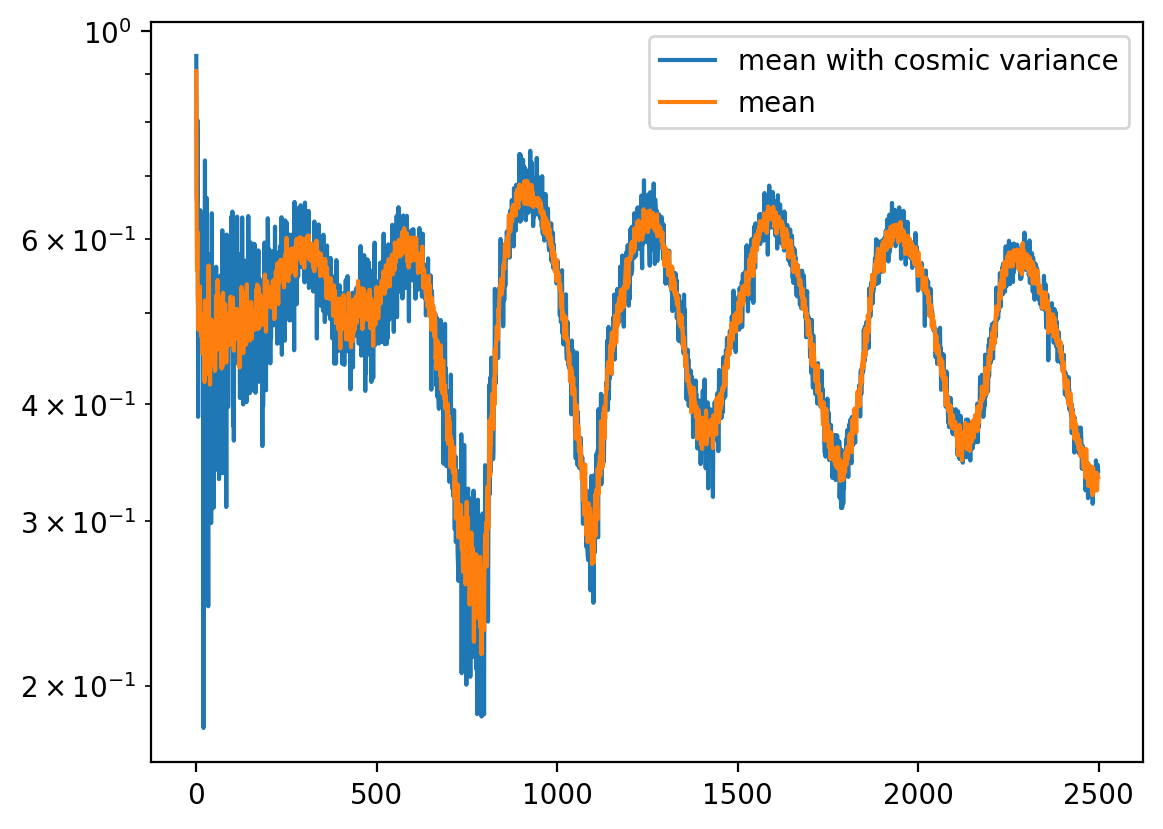

In [12]:
# Plot the data
plt.plot(np.arange(2,2501),data_norm[0],label='mean with cosmic variance')
plt.plot(np.arange(2,2501),data_norm_mean[0],label='mean')
plt.legend()
plt.yscale('log')

<a id='train'></a>
## Train the encoder-decoder
NN architecture: 

input-96(+ReLU)-6(bottleneck)-96(+ReLU)-512(+ReLU)+output, trained with IOB.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7" # depend on the GPU devices

In [2]:
types = 'TT' # CMB PS type
model_name = 'shallow96_noised_test'
name=types+'_'+model_name # model name

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
import torch.optim as optim
from torch.utils.data import random_split
from pytorchtools import EarlyStopping
from random import randint, random
from torch.utils.data import Dataset
from torch import nn
from model_cmb import Encoder_cmb, Decoder_cmb, maskin_cmb
from load_data_cmb import CMBDataset

############################################################### Key parameters to vary
d_encode=6 #128, the bottleneck dimension
lr= 1e-5
num_epochs =2048 #2048
patience=20 # The patience for early stopping of the training. 
################################################################

### Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

### Prepare the data
data_dir = './data/camb_new_processed/d_normed_new_noised_%s.npy'%types
data_mean_dir = './data/camb_new_processed/d_normed_new_noised_mean_%s.npy'%types
para_dir = './data/camb_new_processed/p_normed_new_noised_%s.npy'%types
err_dir = './data/camb_new_processed/e_normed_new_noised_%s.npy'%types

batch_size = 128
dataset = CMBDataset(data_dir,data_mean_dir,para_dir,err_dir)

torch.manual_seed(43)
val_size = 500 
test_size = 500
train_size = len(dataset) - val_size - test_size
X_train, X_valid, X_test= random_split(dataset, [train_size, val_size, test_size])

# data loader setup
train_loader = torch.utils.data.DataLoader(X_train,batch_size=batch_size,shuffle=True,num_workers=0,pin_memory=(device == device))
valid_loader = torch.utils.data.DataLoader(X_valid,batch_size=batch_size,shuffle=True,num_workers=0,pin_memory=(device == device))
test_loader = torch.utils.data.DataLoader(X_test,batch_size=batch_size,shuffle=False,num_workers=0,pin_memory=(device == device))


Selected device: cuda


In [100]:
for data_batch,data_batch_mean,param,err in train_loader:
    print (data_batch.shape,data_batch_mean.shape,err.shape)
    break

torch.Size([128, 1, 2499]) torch.Size([128, 1, 2499]) torch.Size([128, 2499])


In [102]:
### Initialize the networks
encoder = Encoder_cmb(encoded_space_dim=d_encode)
decoder = Decoder_cmb(encoded_space_dim=d_encode)
maskin = maskin_cmb()

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': maskin.parameters()},
    {'params': decoder.parameters()}
]

### Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
maskin.to(device)

### Define the loss function
#loss_fn = torch.nn.MSELoss()
def loss_fn(output, target, weight):
    loss = torch.mean((output - target)**2/weight)
    return loss

### Define an optimizer (both for the encoder and the decoder)
optim = torch.optim.Adam(params_to_optimize, lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', patience=5, factor=0.1)

### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer,epoch):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []

    # Iterate the dataloader
    for data_batch,data_batch_mean,param,err in dataloader:
        data_batch = data_batch.to(device)
        data_batch_mean = data_batch_mean.to(device)
        param = param.to(device)
        err = err.to(device)
        # Encode data
        encoded_data = encoder(param) 
        maskin_data = maskin(encoded_data)
        
        # Initialize the loss
        loss=torch.tensor(0,dtype=torch.float32).to(device)
        
        range_index=torch.arange(1, d_encode+1)
        for x_index in range(d_encode+1):
            mask1 = range_index.le(x_index).unsqueeze(0).to(device)
            loss+=loss_fn(data_batch[:,0,:], decoder(maskin_data*mask1),err)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


### Testing function
def valid_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        conc_out = [] # For the decoded (reconstructed data)
        conc_data = [] # Which is the real input data
        conc_data_mean = [] # For the real mean data (for each set of parameters)
        conc_param = [] # For the parameters
        conc_err = [] # For the cosmic variance
        for data_batch,data_batch_mean,param,err in dataloader:
            data_batch = data_batch.to(device)
            data_batch_mean = data_batch_mean.to(device)
            param = param.to(device)
            err = err.to(device)
            # Encode data
            encoded_data= encoder(param)
            maskin_data = maskin(encoded_data)
            # Decode data
            decoded_data = decoder(maskin_data)
            # Append the network output and the original data to the lists
            conc_out.append(decoded_data.cpu())
            conc_data.append(data_batch.cpu())
            conc_data_mean.append(data_batch_mean.cpu())
            conc_err.append(err.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_data = torch.cat(conc_data)
        conc_data_mean = torch.cat(conc_data_mean)
        conc_err = torch.cat(conc_err)
        # Evaluate global loss
        #val_loss = loss_fn(conc_out, conc_data_mean[:,0,:],conc_err)
        val_loss = loss_fn(conc_out, conc_data[:,0,:],conc_err)
    return val_loss.data

### Initialize the earlystoping
early_stopping = EarlyStopping(patience=patience, verbose=True)

### The training part
# Define the checkpoint path
state_save_early_path='./model/checkpoint_%s.tar'%name

number_of_params = sum(x.numel() for x in decoder.parameters())
print(f"Number of parameters: {number_of_params}")
    
for epoch in range(num_epochs):
    train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim,epoch)
    val_loss = valid_epoch(encoder,decoder,device,valid_loader,loss_fn)
    scheduler.step(val_loss)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {} \t name {}'.format(epoch + 1, num_epochs,train_loss,val_loss,name))
    model_state = {
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'maskin_state_dict': maskin.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'val_loss': val_loss
            }
    early_stopping(val_loss, model_state,state_save_early_path)
    if early_stopping.early_stop or epoch==num_epochs-1:
        if early_stopping.early_stop:
            print("Early stopping")
        print ("Stop training!")
        break



Number of parameters: 1285571

 EPOCH 1/2048 	 train loss 4009.76806640625 	 val loss 522.0109252929688 	 name shallow96_noised
Validation loss decreased (inf --> 522.010925).  Saving model ...

 EPOCH 2/2048 	 train loss 3330.588134765625 	 val loss 432.9777526855469 	 name shallow96_noised
Validation loss decreased (522.010925 --> 432.977753).  Saving model ...

 EPOCH 3/2048 	 train loss 2781.75537109375 	 val loss 361.4820251464844 	 name shallow96_noised
Validation loss decreased (432.977753 --> 361.482025).  Saving model ...

 EPOCH 4/2048 	 train loss 2346.78564453125 	 val loss 303.6090393066406 	 name shallow96_noised
Validation loss decreased (361.482025 --> 303.609039).  Saving model ...

 EPOCH 5/2048 	 train loss 1997.9696044921875 	 val loss 256.8165588378906 	 name shallow96_noised
Validation loss decreased (303.609039 --> 256.816559).  Saving model ...

 EPOCH 6/2048 	 train loss 1716.7493896484375 	 val loss 219.5182342529297 	 name shallow96_noised
Validation loss dec

<a id='test'></a>
## Test in the original space
Also collect (save) the encoder outputs when open all latents

In [124]:
#name='shallow96' # The basic name of this experiments
name=types+'_'+model_name # The name of this experiments

encoded_shape: torch.Size([500, 6])
Weighted loss value: [20.0844086   7.75818219  1.87921366  0.50959543  0.43396109  0.40855701]


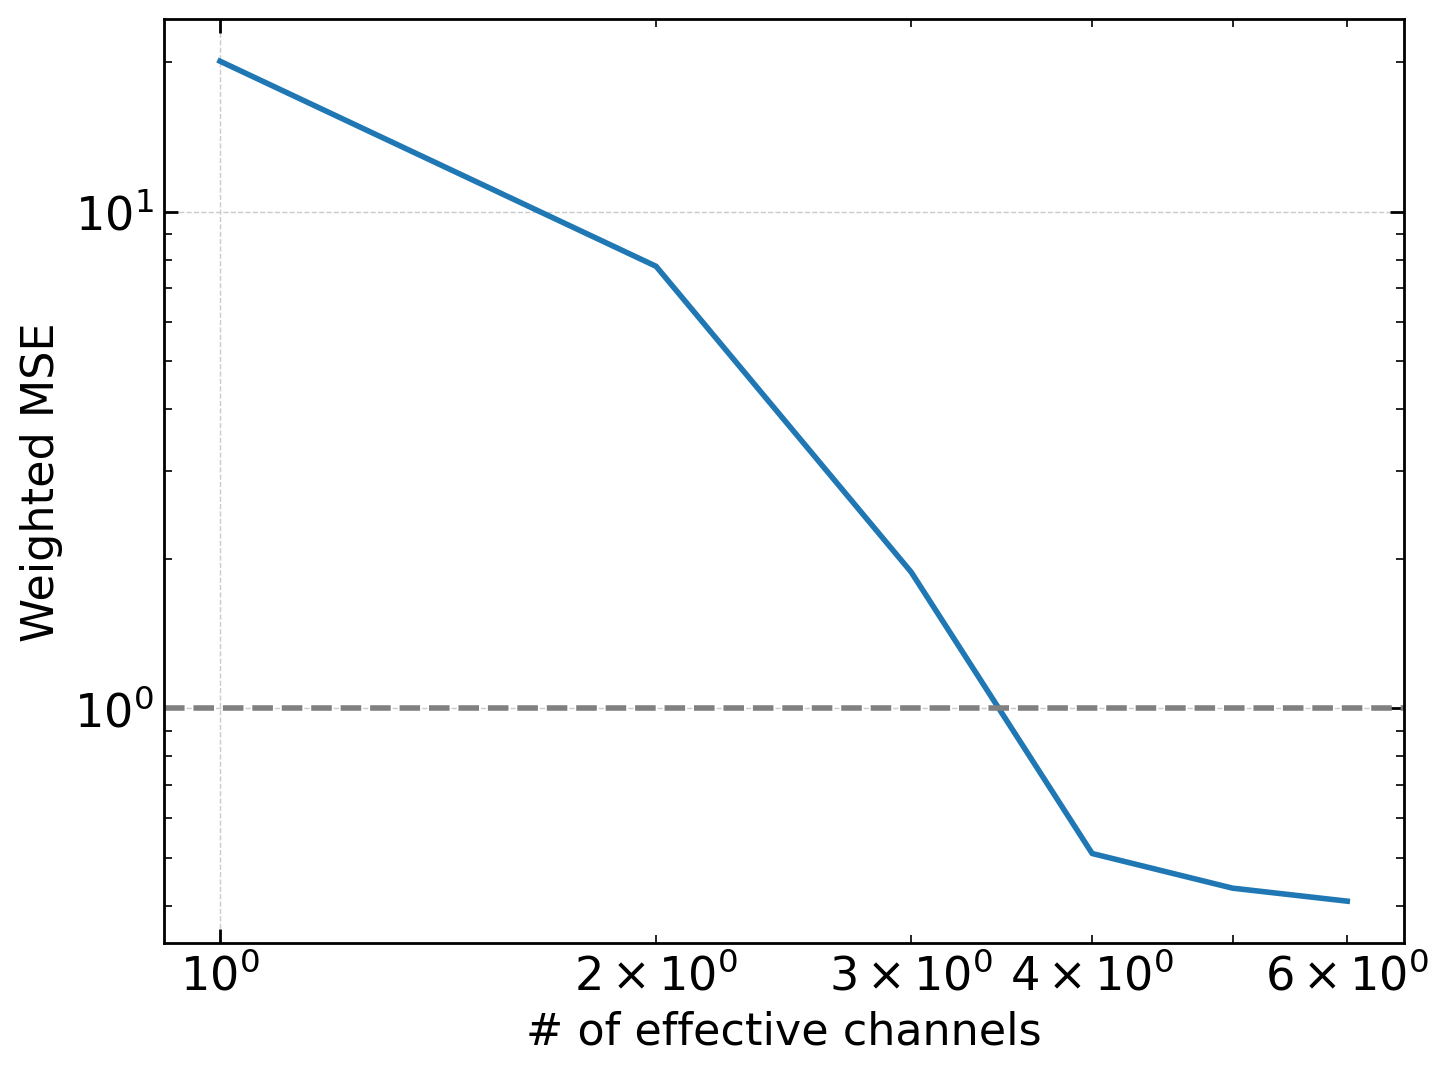

In [160]:
# Inverse process of generating the rescaled data
# Basically only need ``min_temp, data_min, and data_max'', in order to 
# recover the data in the original space from rescaled ones

min_temp = np.load('./data/camb_new_processed/min_temp_%s.npy'%types)
data_min = np.load('./data/camb_new_processed/data_min_%s.npy'%types)
data_max = np.load('./data/camb_new_processed/data_max_%s.npy'%types)

# Reload data_loader shuffle=True
#test_loader = torch.utils.data.DataLoader(X_test,batch_size=batch_size,shuffle=True,num_workers=0,pin_memory=(device == device))


# The two functions to return to the original data space
def trans(data):
    return 10**(data*(data_max-data_min)+data_min)-1+min_temp
def trans_error(data,error):
    return error*((data+1-min_temp)*np.log(10))**2*(data_max-data_min)**2

### Testing function for the retrained model
def test_epoch_original(encoder, decoder, device, dataloader, loss_fn,maskindex):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        conc_out = [] # For the encoded latents
        conc_param = []
        conc_out_encoded = []
        
        conc_data = [] # For the real input data
        conc_data_mean = []
        conc_err = []
        
        # Data untranslated (by the scaling above)
        conc_data_untrans = [] 
        conc_data_mean_untrans = []
        conc_err_untrans = []
        
        # Mask
        range_index=torch.arange(1, d_encode+1)
        mask = range_index.le(maskindex).unsqueeze(0).to(device)

        for data_batch, data_batch_mean, param,err in dataloader:
            data_batch = data_batch.to(device)
            data_batch_mean = data_batch_mean.to(device)
            param = param.to(device)
            err = err.to(device)
            # Encode data
            encoded_data= encoder(param)
            maskin_data = maskin(encoded_data)

            decoded_data = decoder(maskin_data*mask)

            conc_out_encoded.append(maskin_data.cpu())
            conc_param.append(param.cpu())
            
            conc_out.append(trans(decoded_data.cpu()))
            conc_data.append(trans(data_batch.cpu()[:,0,:]))
            conc_data_mean.append(trans(data_batch_mean.cpu()[:,0,:]))
            conc_err.append(trans_error(trans(data_batch.cpu()[:,0,:]),err.cpu()))
            
            conc_data_untrans.append(data_batch.cpu())
            conc_data_mean_untrans.append(data_batch_mean.cpu())
            conc_err_untrans.append(err.cpu())
            
        # Create a single tensor with all the values in the lists
        conc_out_encoded = torch.cat(conc_out_encoded)
        conc_param = torch.cat(conc_param)
        
        conc_out = torch.cat(conc_out)
        conc_data = torch.cat(conc_data)
        conc_data_mean = torch.cat(conc_data_mean)
        conc_err = torch.cat(conc_err)
        
        conc_data_untrans = torch.cat(conc_data_untrans)
        conc_data_mean_untrans = torch.cat(conc_data_mean_untrans)
        conc_err_untrans = torch.cat(conc_err_untrans)
        
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_data_mean[:,:],conc_err)
        #val_loss = loss_fn(conc_out, conc_data[:,:],conc_err)
    return val_loss.data, conc_out_encoded, conc_param,conc_data_mean_untrans[:,0,:], conc_err_untrans, conc_data_untrans

def loss_fn(output, target, weight):
    loss = torch.mean((output - target)**2/weight)
    return loss

### Load only the last model, and mask the bottleneck gradually
test_losses_onloader_onemodel=[]

encoder = Encoder_cmb(encoded_space_dim=d_encode)
decoder = Decoder_cmb(encoded_space_dim=d_encode)
maskin = maskin_cmb()

model_state_save_early_path_checkpoint ='./model/checkpoint_%s.tar'%(name)
checkpoint_model = torch.load(model_state_save_early_path_checkpoint)
encoder.load_state_dict(checkpoint_model['encoder_state_dict'])
decoder.load_state_dict(checkpoint_model['decoder_state_dict'])
maskin.load_state_dict(checkpoint_model['maskin_state_dict'])

encoder.eval()
encoder.to(device)
decoder.eval()
decoder.to(device)
maskin.eval()
maskin.to(device)

for maskindex in range(1,d_encode+1):
    if maskindex==d_encode:
        temp, conc_out_encoded, conc_param, conc_data_mean, conc_err, conc_data=test_epoch_original(encoder, decoder, device, test_loader, loss_fn,maskindex) # Here the test_loader
    else:
        temp, _,_,_,_,_=test_epoch_original(encoder, decoder, device, test_loader, loss_fn,maskindex) # Here the test_loader

    test_losses_onloader_onemodel.append(np.array(temp))

# Save the testing samples for operon use later
np.save('./data/camb_new_processed/param_%s.npy'%name,conc_param)
np.save('./data/camb_new_processed/encoded_%s.npy'%name,conc_out_encoded)
np.save('./data/camb_new_processed/data_%s.npy'%name,conc_data)
np.save('./data/camb_new_processed/data_mean_%s.npy'%name,conc_data_mean)
np.save('./data/camb_new_processed/error_%s.npy'%name,conc_err)

print ("encoded_shape:",conc_out_encoded.shape)
print ("Weighted loss value:",np.array(test_losses_onloader_onemodel))

### Plot the weighted loss
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(1,len(test_losses_onloader_onemodel)+1),test_losses_onloader_onemodel)
ax.set_xlabel('# of effective channels',fontsize=16)
ax.set_ylabel('Weighted MSE',fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')
ax.axhline(1., color="grey", linestyle="--") # The threshold for the weighted error (likelihood)
plt.show()
plt.close()

<a id='operon'></a>
## SR with pyoperon
Change the allowed_symbols may cause the NaN error later for individual expressions
e.g. allowed_symbols='add,sub,mul,aq,sin,constant,variable'is OK, while allowed_symbols='add,mul,pow,constant,variable' will lead to an error

In [187]:
# The basic name for the operon experiments
#operon_name = name
#name = 'shallow96'
name = types+'_'+model_name

#operon_name = 'shallow96_noised'
operon_name = 'run1'

In [188]:
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
from operon_sklearn import SymbolicRegressor
from pyoperon import InfixFormatter, FitLeastSquares, MSE
import csv

def operon_cmb(y,X,test_name,cal_individual):
    '''
    # y: the encoder outputs,[batch,6]
    # X: the cosmological parameters,[batch,6]
    # test_name: a specific name for this test
    # cal_individual: whether to calculate the statistics related to the individual expressions (might encounter NaN bug)
    '''
    # Do test-train split
    X_train = X.copy()
    X_test = X.copy()
    y_train = y.copy()
    y_test = y.copy()
    
    # Make SR class
    reg = SymbolicRegressor(
            #allowed_symbols='add,mul,pow,constant,variable', # cause the NaN error later for individual expressions
            allowed_symbols='add,sub,mul,aq,sin,constant,variable',
            offspring_generator='basic',
            local_iterations=1000,
            max_length=50,
            initialization_method='btc',
            n_threads=32,
            objectives = ['r2', 'length'],
            epsilon = 1e-3,
            random_state=None,
            reinserter='keep-best',
            max_evaluations=int(1e5),
            symbolic_mode=False
            )
    
    # Run fit
    reg.fit(X_train, y_train)
    
    compute_mse = MSE()
    
    # Output pareto front to file 
    print('Outputting pareto')
    with open('./data/sr/pareto_%s.csv'%test_name, 'w') as f:
        writer = csv.writer(f, delimiter=',')
    
        writer.writerow(['length',
                        'r2_train',
                        'r2_test',
                        'mse_train',
                        'mse_test',
                        'scale',
                        'offset',
                        'infix',
        ])
    
        count = 0
        pred_ind = np.zeros((len(reg.pareto_front_),500))
        pareto_mse = np.zeros((len(reg.pareto_front_)))
        for model, model_vars, model_obj, bic in reg.pareto_front_:
            y_pred_train = reg.evaluate_model(model, X_train)
            y_pred_test = reg.evaluate_model(model, X_test)
    
            scale, offset = FitLeastSquares(y_pred_train, y_train)
            y_pred_train = scale * y_pred_train + offset
            y_pred_test = scale * y_pred_test + offset
            
            pred_ind[count] = y_pred_test
            mse = np.mean((y_train- y_pred_train)**2)
            pareto_mse[count] = mse
            #np.save('./data/pred_individuals5_%d.npy'%count,y_pred_test)
            count += 1
    
            variables = { v.Hash : v.Name for v in model_vars }
            writer.writerow([model.Length,
                            r2_score(y_train, y_pred_train),
                            r2_score(y_test, y_pred_test),
                            compute_mse(y_train, y_pred_train),
                            compute_mse(y_test, y_pred_test),
                            scale,
                            offset,
                            InfixFormatter.Format(model, variables, 3),
            ])
        np.save('./data/sr/pred_pareto_%s.npy'%test_name,pred_ind)
        np.save('./data/sr/mse_pareto_%s.npy'%test_name,pareto_mse)
        
    if cal_individual==True:
        # Output currently considered individuals to file
        print(f'Outputting {len(reg.individuals_)} individuals')
        with open('./data/sr/individuals_%s.csv'%test_name, 'w') as f:
            writer = csv.writer(f, delimiter=',')
        
            writer.writerow(['length',
                            'r2_train',
                            'r2_test',
                            'mse_train',
                            'mse_test',
                            'scale',
                            'offset',
                            'infix',
            ])
        
            count = 0
            pred_ind = np.zeros((2000,500))
            for ind in reg.individuals_:
                y_pred_train = reg.evaluate_model(ind.Genotype, X_train)
                y_pred_test = reg.evaluate_model(ind.Genotype, X_test)
        
                scale, offset = FitLeastSquares(y_pred_train, y_train)
                y_pred_train = scale * y_pred_train + offset
                y_pred_test = scale * y_pred_test + offset
        
                pred_ind[count] = y_pred_test
                #np.save('./data/pred_individuals5_%d.npy'%count,y_pred_test)
                count += 1
                
                #print (y_pred_train)
                writer.writerow([ind.Genotype.Length,
                                r2_score(y_train, y_pred_train),
                                r2_score(y_test, y_pred_test),
                                compute_mse(y_train, y_pred_train),
                                compute_mse(y_test, y_pred_test),
                                scale,
                                offset,
                                reg.get_model_string(ind.Genotype, 4)
                ])
            np.save('./data/sr/pred_individuals_%s.npy'%test_name,pred_ind)

In [195]:
n_latent = 6
y=np.load('./data/camb_new_processed/encoded_%s.npy'%name) # the encoder outputs
X=np.load('./data/camb_new_processed/param_%s.npy'%name) # the input cosmological parameters


for i in range(n_latent):
    test_name = types + '_'+ operon_name+'_'+'latent%d'%i
    #operon_cmb(y[:,i],X,test_name,cal_individual=False)
    operon_cmb(y[:,i],X,test_name,cal_individual=True) 

Outputting pareto
Outputting 2000 individuals


Outputting pareto
Outputting 2000 individuals


Outputting pareto
Outputting 2000 individuals


Outputting pareto
Outputting 2000 individuals


Outputting pareto
Outputting 2000 individuals


Outputting pareto
Outputting 2000 individuals


<a id='weighted'></a>
## Inspect the data space (replacement of latents)
replace only one latent in order, no replacement for the above latents

#### Inspect the parato front from the operon

In [200]:
# operon_name
runs = 'run1' 

In [197]:
name

'shallow96_noised'

In [198]:
# Define functions to print expressions that are easy to read
import numpy as np
from IPython.display import display
import sympy as sp
from sympy import *

def pprint(expr):
    display(eval(expr))

X6= Symbol('X6')
X1 = Symbol('X1')
X2 = Symbol('X2')
X3 = Symbol('X3')
X4 = Symbol('X4')
X5 = Symbol('X5')

In [193]:
# Inverse process of generating the rescaled data
# Basically only need ``min_temp, data_min, and data_max'', in order to 
# recover the data in the original space from rescaled ones

min_temp = np.load('./data/camb_new_processed/min_temp_%s.npy'%types)
data_min = np.load('./data/camb_new_processed/data_min_%s.npy'%types)
data_max = np.load('./data/camb_new_processed/data_max_%s.npy'%types)

def trans(data):
    return 10**(data*(data_max-data_min)+data_min)-1+min_temp
def trans_error(data,error):
    #print (data.shape,error.shape)
    return error*((data+1-min_temp)*np.log(10))**2*(data_max-data_min)**2

The weighted MSE: [[4.06627491e+01 1.45877964e+01 1.29501906e+00 ... 5.07550004e+00
  2.23031129e+01 6.84330102e+01]
 [4.80426717e+01 7.64621302e+00 1.06728055e+01 ... 2.14673181e+01
  6.10716853e-01 4.95498889e+00]
 [1.28227909e+01 1.79865558e+00 3.98281455e+01 ... 1.77979696e+01
  2.09065537e+01 2.76502036e+01]
 ...
 [9.63443767e-02 4.35925583e-02 3.92679367e+00 ... 6.19633713e-01
  9.76005428e-01 4.62511705e+00]
 [1.04172443e-01 7.36301956e-01 1.78167003e+00 ... 5.88497261e-01
  2.80795874e+00 2.94834050e-01]
 [2.72988789e-01 1.99508541e-01 2.65678475e-01 ... 8.14559984e-01
  3.88887507e-01 3.11745413e-01]]


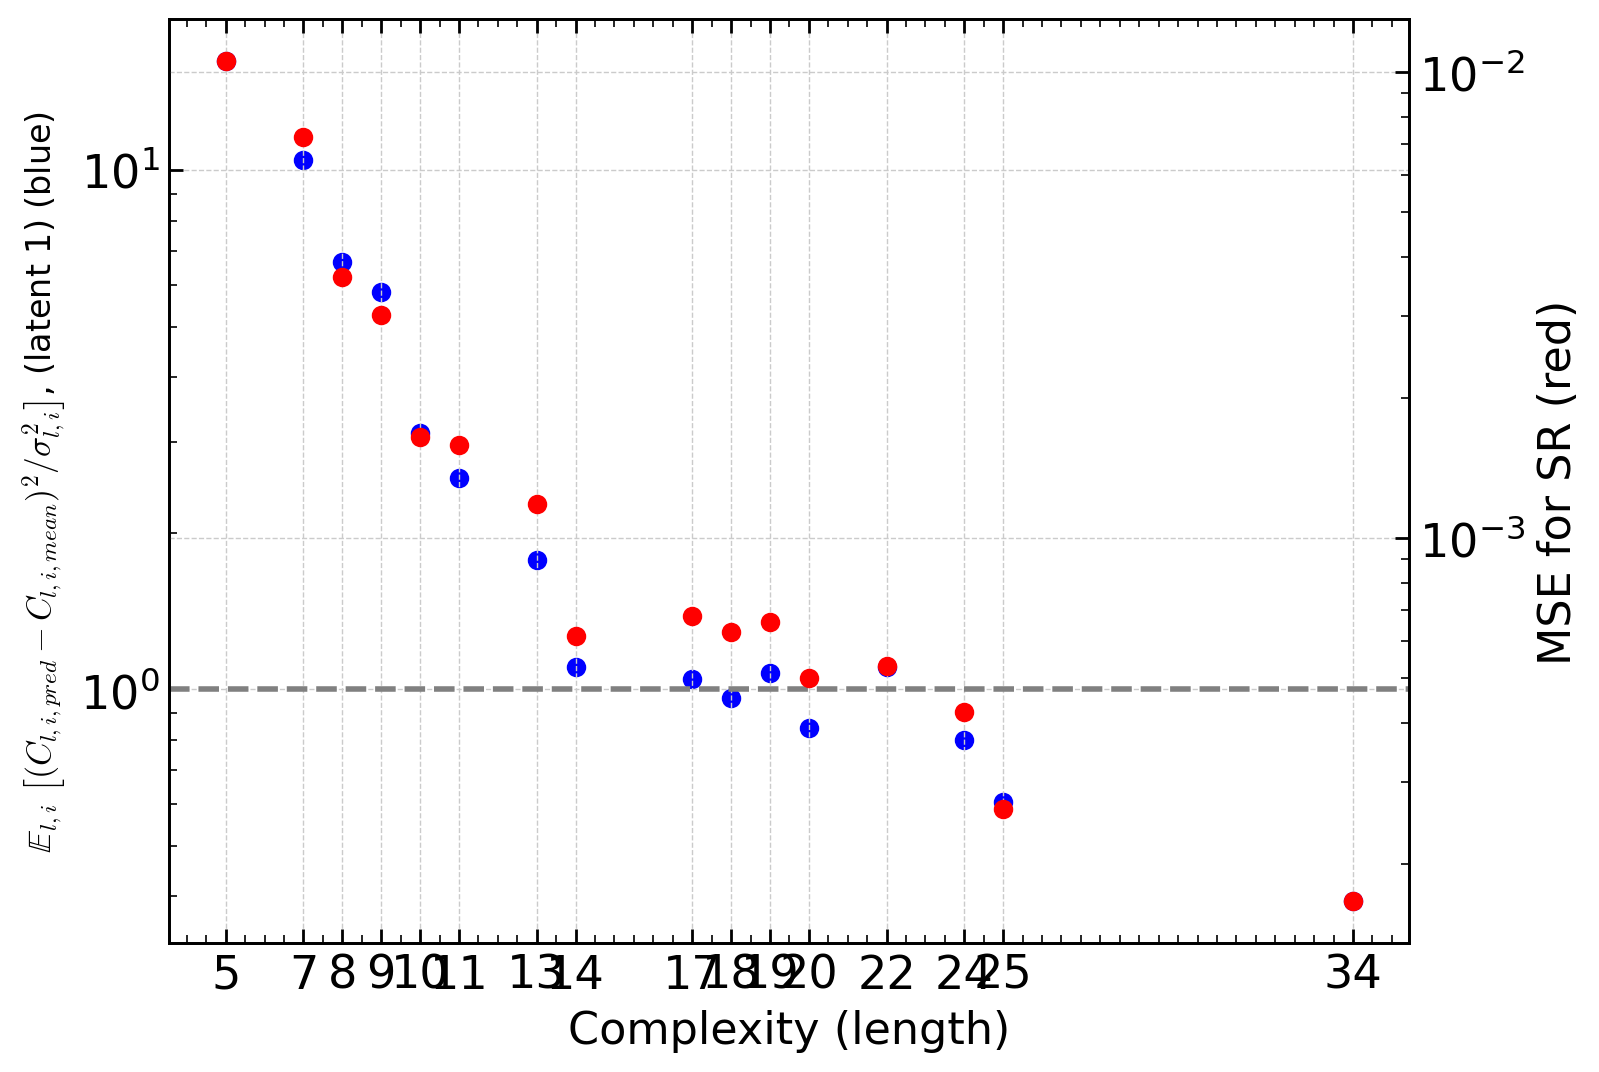

raw expression: ((-0.273) + ((-4.884) * ((-0.090) * X2)))
*****


0.43956*X2 - 0.273

***********************************
raw expression: (0.060 + (0.889 * (((-1.350) * X1) / (sqrt(1 + ((-9.467) * X2) ^ 2)))))
*****


-0.126771944649836*X1/sqrt(X2**2 + 0.011157714529182) + 0.06

***********************************
raw expression: ((-0.058) + (0.331 * ((1.524 * X2) - sin((2.317 * X1)))))
*****


0.504444*X2 - 0.331*sin(2.317*X1) - 0.058

***********************************
raw expression: ((-0.079) + (0.959 * (((-0.168) * X4) + (((-0.371) * X1) - ((-0.547) * X2)))))
*****


-0.355789*X1 + 0.524573*X2 - 0.161112*X4 - 0.079

***********************************
raw expression: (0.016 + (0.328 * (((1.563 * X2) - (0.493 * X4)) + sin(((-2.325) * X1)))))
*****


0.512664*X2 - 0.161704*X4 - 0.328*sin(2.325*X1) + 0.016

***********************************
raw expression: (0.004 + (1.002 * ((((-0.264) * X4) + (((-0.719) * X1) - ((-0.700) * X2))) / (sqrt(1 + ((-2.336) * X6) ^ 2)))))
*****


0.004 + 0.428938356164384*(-0.719*X1 + 0.7*X2 - 0.264*X4)/sqrt(X6**2 + 0.183254362919872)

***********************************
raw expression: (0.101 + (1.017 * ((((-0.204) * X4) + (((-0.600) * X1) - (((-0.617) * X2) + 0.154))) / (sqrt(1 + ((-1.716) * X6) ^ 2)))))
*****


0.101 + 0.592657342657343*(-0.6*X1 + 0.617*X2 - 0.204*X4 - 0.154)/sqrt(X6**2 + 0.339598241696144)

***********************************
raw expression: (0.031 + (0.103 * (sin(((-4.748) * X1)) - ((((-4.326) * X2) - ((-1.516) * X4)) + ((5.553 * X1) + ((-1.228) * X6))))))
*****


-0.571959*X1 + 0.445578*X2 - 0.156148*X4 + 0.126484*X6 - 0.103*sin(4.748*X1) + 0.031

***********************************
raw expression: (0.053 + (1.065 * sin((((((-0.196) * X4) + (sin(((2.348 * X1) / (sqrt(1 + (0.992 * X2) ^ 2)))) * (-0.420))) - ((-0.532) * X2)) / (sqrt(1 + ((-1.531) * X6) ^ 2))))))
*****


1.065*sin(0.653167864141084*(0.532*X2 - 0.196*X4 - 0.42*sin(2.348*X1/sqrt(0.984064*X2**2 + 1)))/sqrt(X6**2 + 0.426628258746626)) + 0.053

***********************************
raw expression: (0.048 + (0.711 * ((sin(sin(((-1.864) * X1))) - (sin(((((-0.830) * X1) + ((-2.732) * X2)) / (sqrt(1 + 2.621 ^ 2)))) + (0.290 * X4))) / (sqrt(1 + (1.414 * X6) ^ 2)))))
*****


0.048 + 0.502828854314003*(-0.29*X4 + sin(0.295869795721159*X1 + 0.973875038446031*X2) - sin(sin(1.864*X1)))/sqrt(X6**2 + 0.500151045615776)

***********************************
raw expression: ((-0.010) + (0.661 * ((((-0.239) * X4) + sin((sin(((-1.749) * X1)) - (((((-0.630) * X1) - (0.211 * X6)) / (sqrt(1 + ((-1.287) * X2) ^ 2))) - (0.873 * X2))))) - 0.064)))
*****


-0.157979*X4 - 0.661*sin(-0.873*X2 + 0.777000777000777*(-0.63*X1 - 0.211*X6)/sqrt(X2**2 + 0.603730207459811) + sin(1.749*X1)) - 0.052304

***********************************
raw expression: ((-0.024) + (0.505 * (((sin(((-0.317) * X4)) + (((-0.986) * X1) - ((-0.238) * X6))) + sin((sin(((-2.127) * X1)) + ((1.412 * X1) - ((-1.387) * X2))))) - (0.271 * X2))))
*****


-0.49793*X1 - 0.136855*X2 + 0.12019*X6 - 0.505*sin(0.317*X4) + 0.505*sin(1.412*X1 + 1.387*X2 - sin(2.127*X1)) - 0.024

***********************************
raw expression: ((-0.000) + (1.000 * (((((-0.156) * X4) + ((0.002 * X1) - ((-0.130) * X6))) - (1.453 - (0.448 * X2))) - ((((-0.473) / (sqrt(1 + ((-6.345) * X1) ^ 2))) - ((-0.030) * X5)) + sin((-14.138))))))
*****


0.002*X1 + 0.448*X2 - 0.156*X4 - 0.03*X5 + 0.13*X6 - 0.4530003469935 + 0.0745468873128448/sqrt(X1**2 + 0.0248391509729806)

***********************************
raw expression: (0.024 + (0.414 * (sin((((0.402 * X6) / (sqrt(1 + (-0.004) ^ 2))) - (((sin(((2.185 * X1) / (sqrt(1 + (0.615 * X2) ^ 2)))) * 1.127) - ((-0.104) * X5)) - ((-0.332) * X2)))) + sin((((-0.425) * X4) + (1.542 * X2))))))
*****


0.414*sin(1.542*X2 - 0.425*X4) - 0.414*sin(0.332*X2 + 0.104*X5 - 0.401996784038592*X6 + 1.127*sin(2.185*X1/sqrt(0.378225*X2**2 + 1))) + 0.024

***********************************
raw expression: ((-0.159) + (0.983 * (((0.153 * X6) / (sqrt(1 + ((-1.287) * X2) ^ 2))) - ((((0.161 * X4) + (0.029 * X1)) - (((0.136 * X2) + 0.920) * (((-0.319) / (sqrt(1 + (4.209 * X2) ^ 2))) - ((-0.479) / (sqrt(1 + (7.518 * X1) ^ 2)))))) - (0.212 * X2)))))
*****


-0.028507*X1 + 0.208396*X2 - 0.158263*X4 + 0.11686013986014*X6/sqrt(X2**2 + 0.603730207459811) + 0.983*(0.136*X2 + 0.92)*(-0.0757899738655263/sqrt(X2**2 + 0.0564471667784038) + 0.0637137536578877/sqrt(X1**2 + 0.0176927506643451)) - 0.159

***********************************
raw expression: (0.040 + (1.105 * ((((((-1.289) * X1) - ((-0.024) * X4)) / (sqrt(1 + (((0.211 * X2) - ((-0.317) * X4)) - ((2.843 * X1) + (0.972 * X6))) ^ 2))) + (((-0.107) * X5) / (sqrt(1 + (-3.682) ^ 2)))) + (((sin((((-0.159) * X4) + ((0.273 * X1) - ((-1.564) * X2)))) - sin((0.192 * X4))) + sin(((-0.162) * X1))) * 0.393))))
*****


-0.0309890501629842*X5 + 0.388673935983116*(-1.289*X1 + 0.024*X4)/sqrt((-X1 + 0.0742173760112557*X2 + 0.111501934576152*X4 - 0.341892367217728*X6)**2 + 0.123721814469489) - 0.434265*sin(0.162*X1) - 0.434265*sin(0.192*X4) + 0.434265*sin(0.273*X1 + 1.564*X2 - 0.159*X4) + 0.04

***********************************
The weighted MSE: [[3.20139614 3.2014731  0.54644978 ... 1.67827785 2.27383996 2.02700242]
 [2.72108471 2.58184158 0.39154049 ... 2.33723917 1.79816003 1.10546513]
 [1.25021536 0.24406688 0.09623314 ... 0.13396442 2.55513629 0.91583551]
 ...
 [0.50873608 0.12566055 0.67056558 ... 0.15676701 0.91191681 0.3167721 ]
 [0.22406176 0.1259838  0.75314025 ... 0.14251495 0.73682096 0.29002092]
 [0.38155581 0.13853907 0.38005724 ... 0.14706852 0.46885371 0.25737656]]


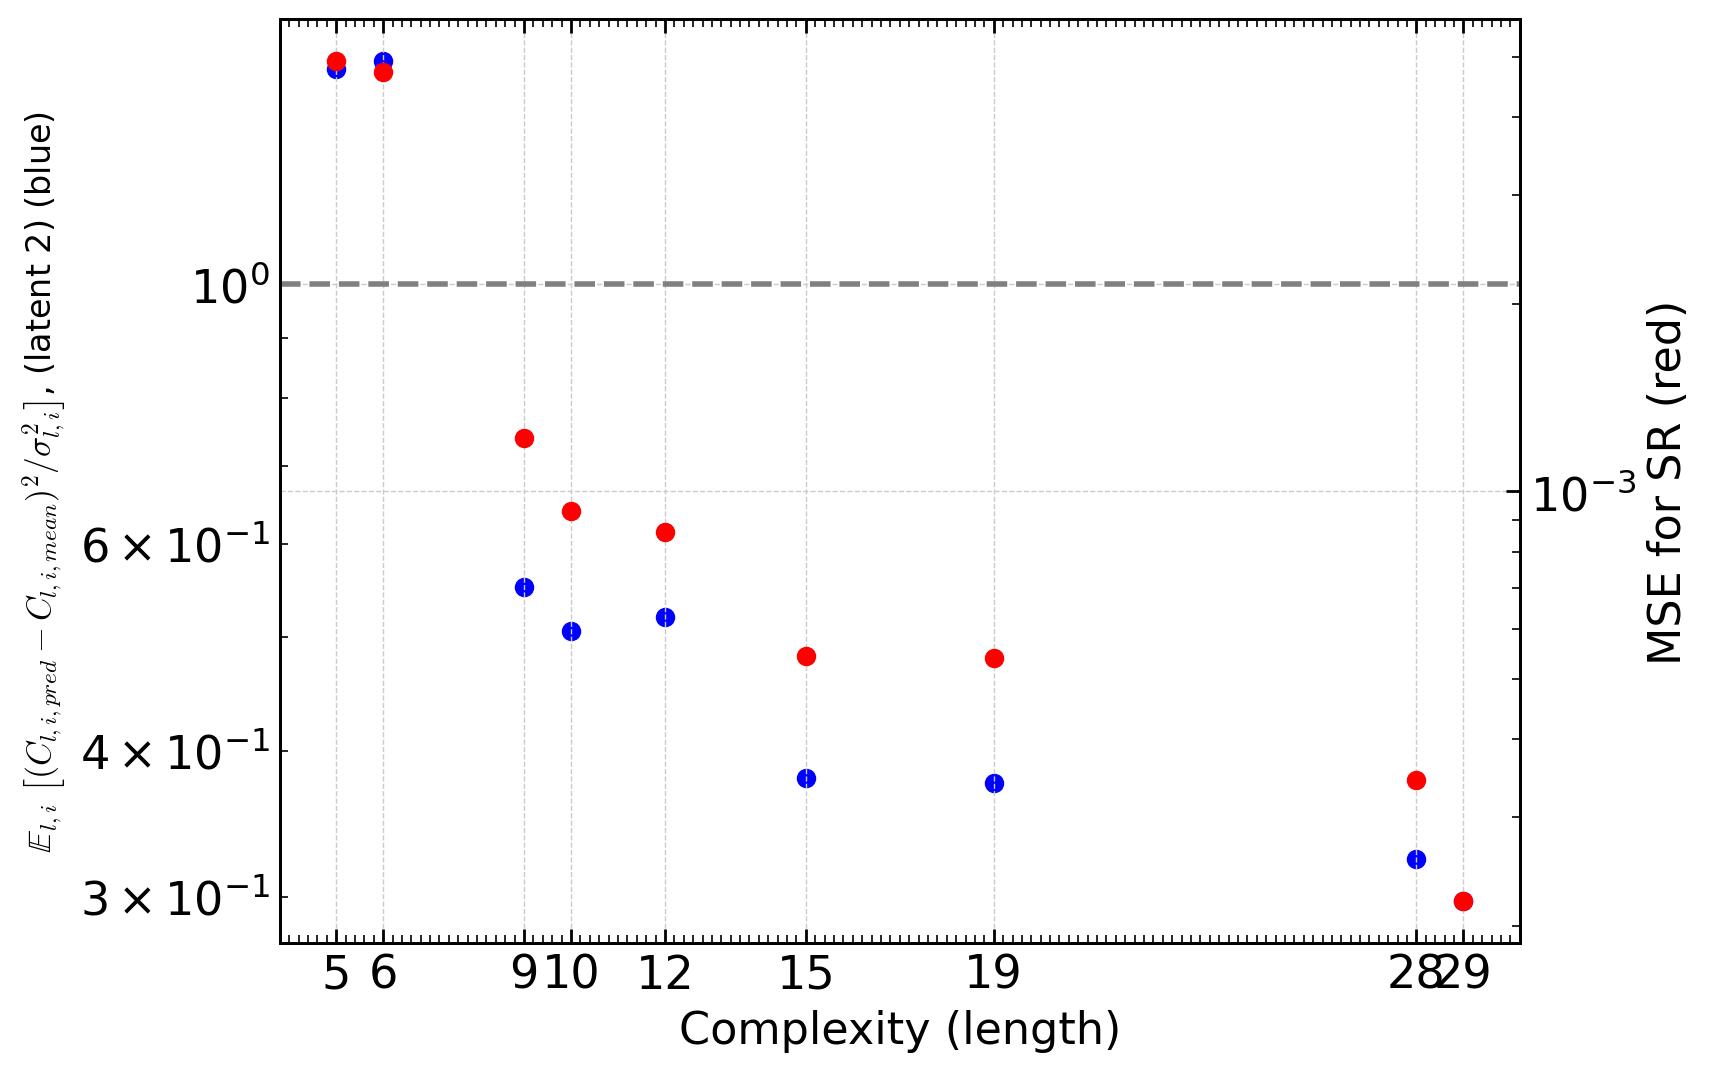

raw expression: ((-0.399) + (2.291 * (0.598 * X2)))
*****


1.370018*X2 - 0.399

***********************************
raw expression: ((-0.430) + (1.675 * sin((0.900 * X2))))
*****


1.675*sin(0.9*X2) - 0.43

***********************************
raw expression: (0.000 + (1.000 * ((-0.466) - (((-0.240) * X6) + ((-1.220) * X2)))))
*****


1.22*X2 + 0.24*X6 - 0.466

***********************************
raw expression: ((-1.346) + (2.705 * sin((0.312 - (((-0.107) * X6) + ((-0.560) * X2))))))
*****


2.705*sin(0.56*X2 + 0.107*X6 + 0.312) - 1.346

***********************************
raw expression: ((-0.001) + (0.996 * (((-0.435) - (0.069 * X4)) - (sin(((-0.243) * X6)) - (1.230 * X2)))))
*****


1.22508*X2 - 0.068724*X4 + 0.996*sin(0.243*X6) - 0.43426

***********************************
raw expression: ((-0.002) + (0.992 * (((-0.478) + (0.424 * X2)) + (((0.245 * X6) + ((-0.071) * X4)) - sin(sin(((-1.008) * X2)))))))
*****


0.420608*X2 - 0.070432*X4 + 0.24304*X6 + 0.992*sin(sin(1.008*X2)) - 0.476176

***********************************
raw expression: (0.003 + (1.005 * ((-0.070) + ((((0.241 * X6) + (1.798 * X2)) + ((-0.070) * X4)) + ((-1.031) / (sqrt(1 + (2.278 - ((0.002 * X6) - ((-2.017) * X2))) ^ 2)))))))
*****


1.80699*X2 - 0.07035*X4 + 0.242205*X6 - 0.06735 - 0.454852941176471/sqrt((-0.885425812115891*X2 - 0.000877963125548727*X6 + 1)**2 + 0.192704812455822)

***********************************
raw expression: ((-0.150) + (3.554 * (((sin(((sin((-0.091)) / (sqrt(1 + ((217.850 * X6) / (sqrt(1 + (-106.882) ^ 2))) ^ 2))) + ((2.710 * X2) / (sqrt(1 + 3.340 ^ 2))))) + (sin((0.784 * X1)) - (0.020 * X4))) - ((1.083 * X1) / (sqrt(1 + ((-0.280) * X6) ^ 2)))) + ((0.330 * X1) - (0.393 * X2)))))
*****


1.17282*X1 - 3.848982*X1/sqrt(0.0784*X6**2 + 1) - 1.396722*X2 - 0.07108*X4 + 3.554*sin(0.784*X1) + 3.554*sin(0.77728643869075*X2 - 0.0445869580030378/sqrt(X6**2 + 0.240731005709236)) - 0.15

***********************************
raw expression: ((-0.002) + (1.005 * ((((((-14.000) + (((-7.302) * X1) + ((865.260 * X2) / (sqrt(1 + (-188.649) ^ 2))))) / (sqrt(1 + (((-1.954) * X1) - ((0.366 * X6) + 3.634)) ^ 2))) + 3.218) + (((0.078 * X4) - ((-0.646) * X2)) / (sqrt(1 + ((14.722 * X2) / (sqrt(1 + ((-17.372) * X1) ^ 2))) ^ 2)))) + ((-0.127) * X4))))
*****


-0.127635*X4 + 1.005*(0.646*X2 + 0.078*X4)/sqrt(0.718181122445869*X2**2/(X1**2 + 0.00331360211400392) + 1) + 3.23209 + 0.276554760594386*(-7.302*X1 + 4.58654879581885*X2 - 14.0)/sqrt((-0.537699504678041*X1 - 0.100715465052284*X6 - 1)**2 + 0.0757234084378291)

***********************************
The weighted MSE: [[ 2.40554798  5.07262231 13.51719371 ...  5.13840518  0.45342486
   2.69657719]
 [ 2.36919608  4.14615053 16.29926684 ...  3.84221682  0.67365548
   1.08304913]
 [ 0.19581978  2.9019991   2.68211865 ...  1.77813625  0.87875868
   0.23790744]
 ...
 [ 0.18003799  0.49776678  0.17003021 ...  0.22977373  0.64535037
   1.2170675 ]
 [ 0.11954019  0.14431073  0.15625377 ...  0.21090054  0.49108296
   0.2394682 ]
 [ 0.14909039  0.27400364  0.3493848  ...  0.12768639  0.47947151
   0.23689199]]


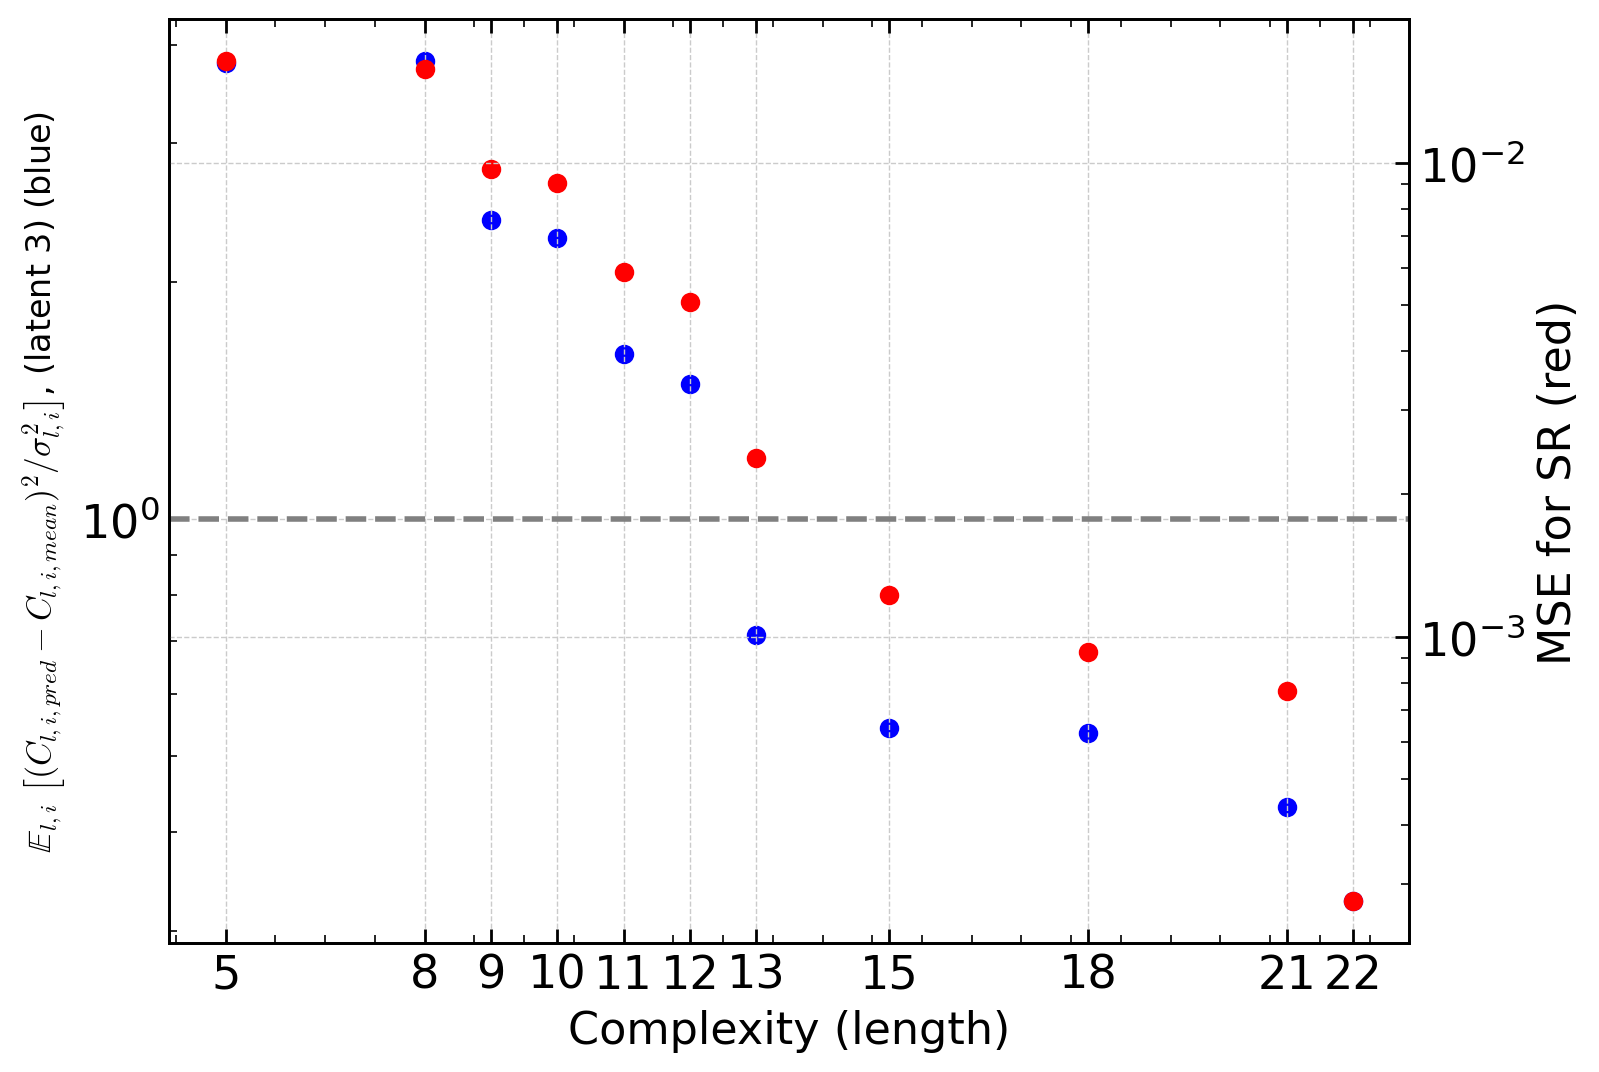

raw expression: (0.578 + ((-4.248) * (0.213 * X2)))
*****


0.578 - 0.904824*X2

***********************************
raw expression: (0.644 + ((-4.354) * ((0.288 * X2) / (sqrt(1 + sin((1.312 * X2)) ^ 2)))))
*****


-1.253952*X2/sqrt(sin(1.312*X2)**2 + 1) + 0.644

***********************************
raw expression: (0.000 + (1.000 * ((((-0.991) * X2) - (-0.446)) - ((-0.396) * X1))))
*****


0.396*X1 - 0.991*X2 + 0.446

***********************************
raw expression: (0.040 + (0.912 * ((0.506 - ((-0.434) * X1)) - sin((1.364 * X2)))))
*****


0.395808*X1 - 0.912*sin(1.364*X2) + 0.501472

***********************************
raw expression: ((-0.000) + (1.000 * ((((-0.853) * X2) - (-0.481)) - ((0.261 * X6) - (0.510 * X1)))))
*****


0.51*X1 - 0.853*X2 - 0.261*X6 + 0.481

***********************************
raw expression: (0.113 + (0.741 * ((((-0.361) * X6) - ((-0.692) * X1)) + (0.583 + sin(((-1.539) * X2))))))
*****


0.512772*X1 - 0.267501*X6 - 0.741*sin(1.539*X2) + 0.545003

***********************************
raw expression: ((-0.000) + (1.000 * (((((-0.266) * X6) - (0.835 * X2)) - (-0.473)) + ((0.721 * X1) / (sqrt(1 + (2.055 * X4) ^ 2))))))
*****


0.350851581508516*X1/sqrt(X4**2 + 0.236797082659942) - 0.835*X2 - 0.266*X6 + 0.473

***********************************
raw expression: ((-0.000) + (1.000 * ((((1.106 / (sqrt(1 + (2.930 * X2) ^ 2))) / (sqrt(1 + ((-0.945) * X4) ^ 2))) - (((-0.512) * X1) - ((-0.281) * X6))) + (-0.522))))
*****


0.512*X1 - 0.281*X6 - 0.522 + 0.377474402730375/(sqrt(X2**2 + 0.116483593285886)*sqrt(0.893025*X4**2 + 1))

***********************************
raw expression: ((-0.071) + (1.174 * ((((-0.021) * X5) - (((sin(((0.221 * X4) - ((-0.249) * X6))) - (-2.247)) / (sqrt(1 + ((-0.691) * X1) ^ 2))) - 2.909)) - (0.717 * X2))))
*****


-0.841758*X2 - 0.024654*X5 + 3.344166 - 1.174*(sin(0.221*X4 + 0.249*X6) + 2.247)/sqrt(0.477481*X1**2 + 1)

***********************************
raw expression: (0.003 + (0.985 * ((((((-0.277) * X6) - ((-0.232) * X2)) - (-0.464)) + ((0.534 * X1) / (sqrt(1 + (0.209 * X4) ^ 2)))) + ((sin(((-0.239) * X4)) - (-0.191)) - sin((1.347 * X2))))))
*****


0.52599*X1/sqrt(0.043681*X4**2 + 1) + 0.22852*X2 - 0.272845*X6 - 0.985*sin(1.347*X2) - 0.985*sin(0.239*X4) + 0.648175

***********************************
raw expression: (0.003 + (0.993 * ((((-0.385) * X2) + ((0.507 / (sqrt(1 + ((-4.110) * X2) ^ 2))) - ((0.038 * X1) + (0.280 * X6)))) - (((sin((0.256 * X4)) - (-2.406)) / (sqrt(1 + ((-0.803) * X1) ^ 2))) - 2.619))))
*****


-0.037734*X1 - 0.382305*X2 - 0.27804*X6 + 2.603667 + 0.122494160583942/sqrt(X2**2 + 0.0591992706649854) - 0.993*(sin(0.256*X4) + 2.406)/sqrt(0.644809*X1**2 + 1)

***********************************
The weighted MSE: [[1.77253308 0.18054954 1.68086918 ... 1.51800058 0.79464317 1.20717387]
 [0.28051363 0.28082344 0.28253195 ... 0.13712111 0.33792929 0.39753467]
 [0.1657812  0.24120005 0.24081234 ... 0.13489177 0.42942833 0.24019275]
 ...
 [0.13916711 0.15139027 0.2095942  ... 0.23456852 0.48674479 0.43714322]
 [0.22936161 0.15763479 0.2187575  ... 0.27203354 0.46586132 0.61547261]
 [0.19504366 0.14314306 0.22218474 ... 0.20921221 0.43228974 0.46572522]]


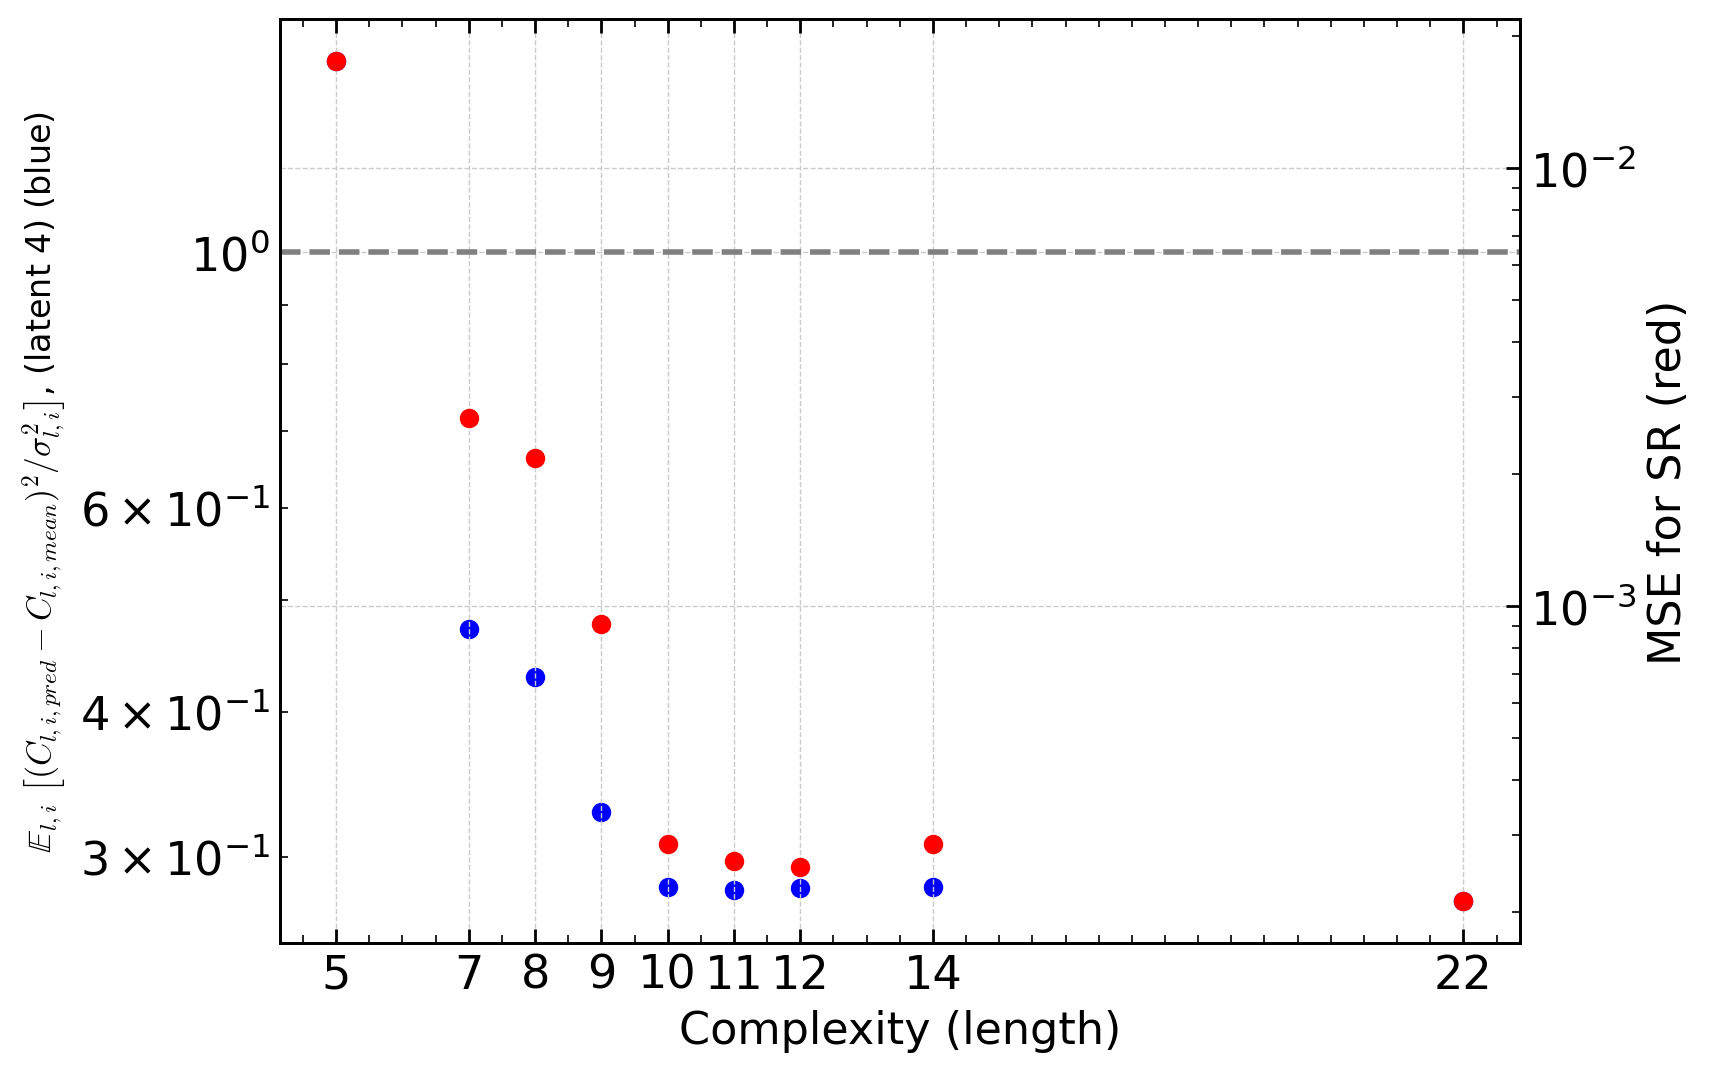

raw expression: (0.162 + (0.786 * (1.459 * X2)))
*****


1.146774*X2 + 0.162

***********************************
raw expression: ((-0.034) + (1.034 * ((0.984 * X2) - ((-0.569) * X1))))
*****


0.588346*X1 + 1.017456*X2 - 0.034

***********************************
raw expression: ((-0.085) + (0.964 * ((0.611 * X1) + sin((1.296 * X2)))))
*****


0.589004*X1 + 0.964*sin(1.296*X2) - 0.085

***********************************
raw expression: ((-0.058) + (1.074 * (((0.475 * X1) + (0.166 * X6)) - ((-0.861) * X2))))
*****


0.51015*X1 + 0.924714*X2 + 0.178284*X6 - 0.058

***********************************
raw expression: ((-0.115) + (0.833 * ((0.221 * X6) - (((-0.610) * X1) + sin(((-1.414) * X2))))))
*****


0.50813*X1 + 0.184093*X6 + 0.833*sin(1.414*X2) - 0.115

***********************************
raw expression: ((-0.124) + (1.045 * ((0.487 * X1) - sin((sin(((-0.207) * X6)) - (1.118 * X2))))))
*****


0.508915*X1 + 1.045*sin(1.118*X2 + sin(0.207*X6)) - 0.124

***********************************
raw expression: ((-1.426) + (2.416 * ((0.210 * X1) - sin((((-0.563) - (0.115 * X6)) - (0.630 * X2))))))
*****


0.50736*X1 + 2.416*sin(0.63*X2 + 0.115*X6 + 0.563) - 1.426

***********************************
raw expression: ((-0.000) + (1.000 * (((((-0.610) * X1) + (sin(((-1.414) * X2)) + 0.138)) * (-0.833)) - ((-0.184) * X6))))
*****


0.50813*X1 + 0.184*X6 + 0.833*sin(1.414*X2) - 0.114954

***********************************
raw expression: ((-0.000) + (1.000 * (((((-6.181) * X1) + (sin(((-3.819) * X2)) + (sin(((-1.134) * X6)) - (-1.736)))) * (-0.082)) + ((sin((0.107 * X6)) + (0.949 * X2)) + (0.023 * X5)))))
*****


0.506842*X1 + 0.949*X2 + 0.023*X5 + 0.082*sin(3.819*X2) + 1.0*sin(0.107*X6) + 0.082*sin(1.134*X6) - 0.142352

***********************************
The weighted MSE: [[0.14562128 0.15123626 0.14947729 ... 0.2645403  0.42615827 0.28199772]
 [0.18324603 0.18078969 0.17844453 ... 0.17992805 0.42894671 0.34160475]
 [0.13932451 0.16142609 0.21653298 ... 0.17154277 0.43973982 0.26445633]
 ...
 [0.11598547 0.14305675 0.22869071 ... 0.16682354 0.43094167 0.24128393]
 [0.11554585 0.14150541 0.22720216 ... 0.16594327 0.43142983 0.2418665 ]
 [0.11578882 0.14513887 0.22505007 ... 0.16574777 0.43606464 0.2422503 ]]


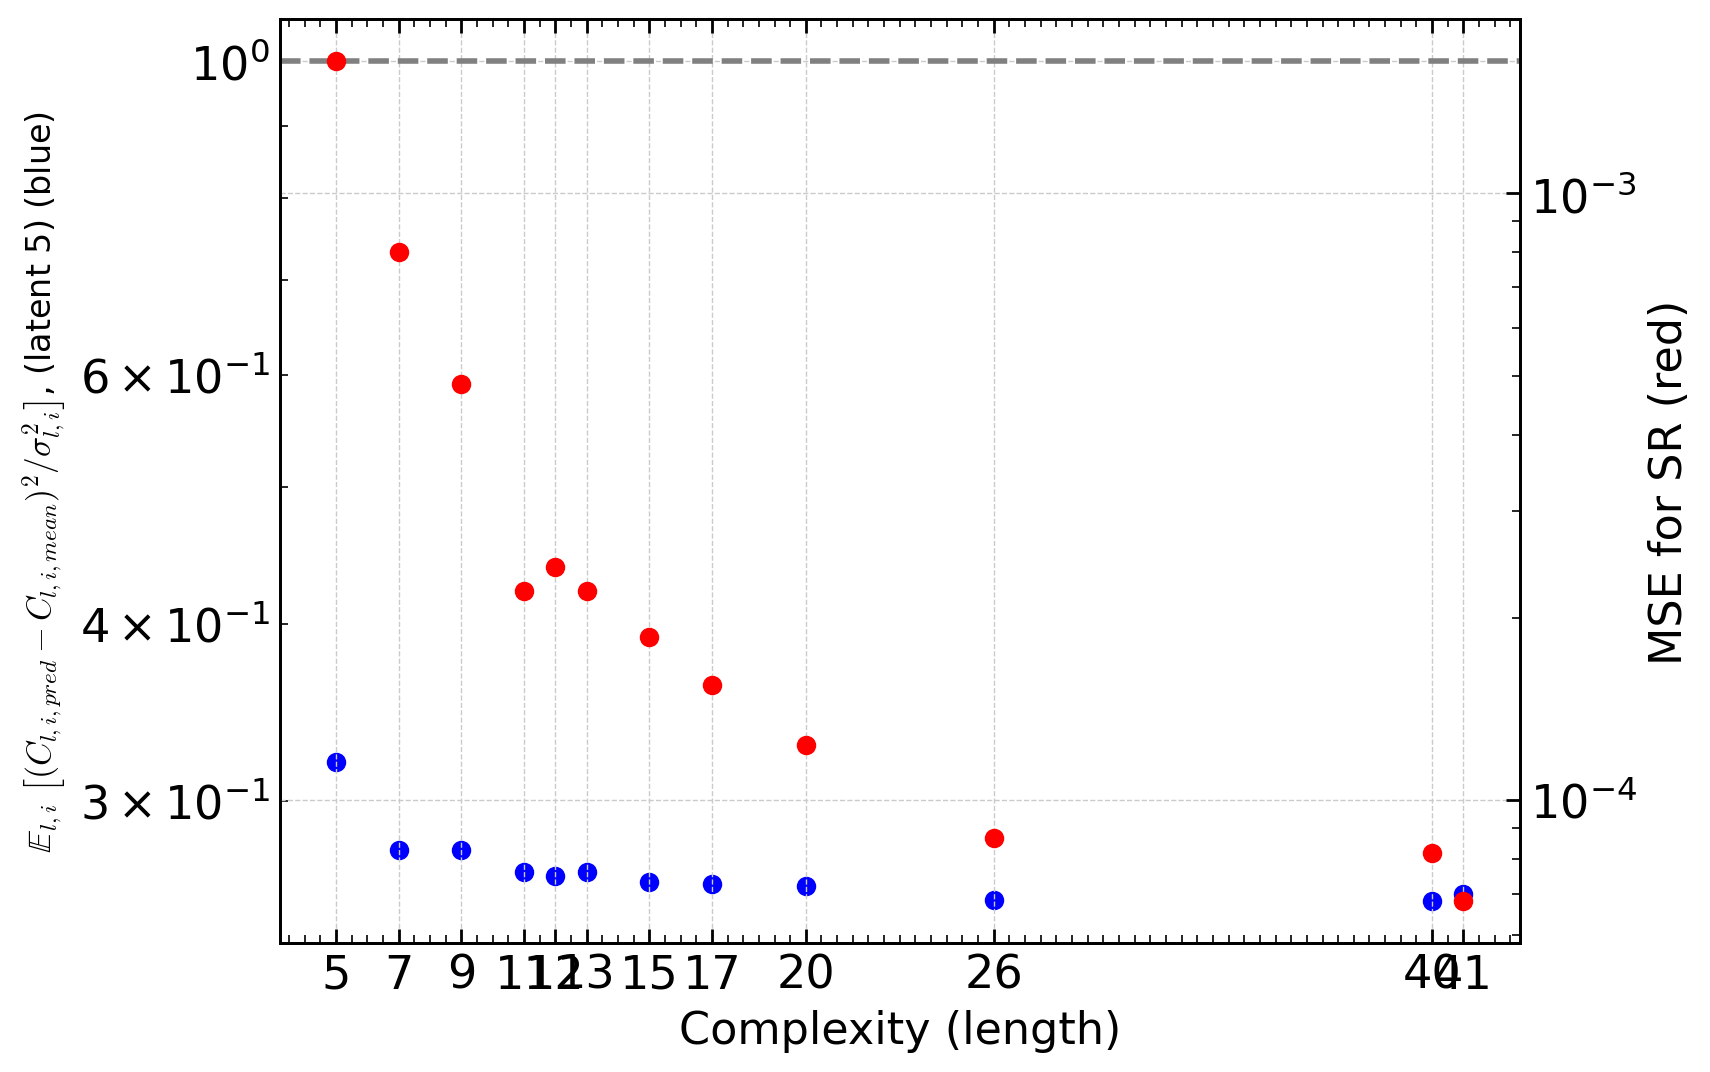

raw expression: ((-0.064) + ((-6.694) * ((-0.016) * X2)))
*****


0.107104*X2 - 0.064

***********************************
raw expression: ((-0.032) + (0.940 * ((0.191 * X2) - (0.123 * X6))))
*****


0.17954*X2 - 0.11562*X6 - 0.032

***********************************
raw expression: ((-0.009) + (0.987 * ((0.185 * X2) - ((0.093 * X1) - ((-0.089) * X6)))))
*****


-0.091791*X1 + 0.182595*X2 - 0.087843*X6 - 0.009

***********************************
raw expression: ((-0.038) + (0.969 * ((((-0.091) * X6) + (0.057 * X5)) + ((0.186 * X2) + ((-0.090) * X1)))))
*****


-0.08721*X1 + 0.180234*X2 + 0.055233*X5 - 0.088179*X6 - 0.038

***********************************
raw expression: ((-0.024) + (0.158 * ((((-0.870) * X1) / (sqrt(1 + (2.391 * X5) ^ 2))) - ((0.537 * X6) - sin((1.540 * X2))))))
*****


-0.0574905897114178*X1/sqrt(X5**2 + 0.174920555456725) - 0.084846*X6 + 0.158*sin(1.54*X2) - 0.024

***********************************
raw expression: (0.000 + (1.000 * ((((0.180 * X2) - (0.088 * X1)) + ((-0.038) - (0.088 * X6))) - ((-0.056) * X5))))
*****


-0.088*X1 + 0.18*X2 + 0.056*X5 - 0.088*X6 - 0.038

***********************************
raw expression: (0.000 + (1.000 * (((0.054 * X5) - ((0.054 + (0.087 * X6)) + (((-0.261) * X2) / (sqrt(1 + ((-1.207) * X2) ^ 2))))) + ((-0.089) * X1))))
*****


-0.089*X1 + 0.216238608119304*X2/sqrt(X2**2 + 0.686412936412765) + 0.054*X5 - 0.087*X6 - 0.054

***********************************
raw expression: ((-0.000) + (1.000 * (((0.182 * X2) - (0.086 * X1)) + ((-0.657) - ((((-0.632) - ((-0.089) * X6)) + ((-0.056) * X5)) - ((-0.030) * X4))))))
*****


-0.086*X1 + 0.182*X2 - 0.03*X4 + 0.056*X5 - 0.089*X6 - 0.025

***********************************
raw expression: ((-0.000) + (1.000 * (((sin((((0.218 * X2) / (sqrt(1 + ((-1.317) * X4) ^ 2))) - (0.089 * X6))) + (((-0.040) + (0.009 * X4)) - ((-0.057) * X5))) + (-0.004)) - (0.084 * X1))))
*****


-0.084*X1 + 0.009*X4 + 0.057*X5 + 1.0*sin(0.165527714502658*X2/sqrt(X4**2 + 0.576538680844906) - 0.089*X6) - 0.044

***********************************
raw expression: (0.003 + (0.994 * ((((-0.088) * X1) + ((((-0.099) / (sqrt(1 + ((-1.751) * X5) ^ 2))) + 0.041) - (((((15.177 * X2) / (sqrt(1 + ((-1.074) * X4) ^ 2))) - (5.484 * X6)) - sin(((-4.432) * X2))) * ((-0.016) - ((-0.002) * X6))))) / (sqrt(1 + ((-0.351) * X2) ^ 2)))))
*****


0.003 + 0.994*(-0.088*X1 - (0.002*X6 - 0.016)*(14.1312849162011*X2/sqrt(X4**2 + 0.86694478255291) - 5.484*X6 + sin(4.432*X2)) + 0.041 - 0.05653912050257/sqrt(X5**2 + 0.326157754025521))/sqrt(0.123201*X2**2 + 1)

***********************************
raw expression: (0.000 + (1.000 * ((((-0.086) * X1) - 0.096) - ((sin(((((-0.196) * X2) / (sqrt(1 + ((-1.502) * X4) ^ 2))) - ((-0.057) * X6))) + (((-0.027) + ((-0.010) * X4)) - (0.057 * X5))) - ((((((-0.169) / (sqrt(1 + ((-0.472) * X5) ^ 2))) + ((-0.267) * X2)) - ((-0.414) * (0.548 * X6))) * sin((((-8.609) * X2) / (sqrt(1 + (-2.549) ^ 2))))) * (((-0.229) * X2) - sin((-0.265))))))))
*****


-0.086*X1 + 0.01*X4 + 0.057*X5 - 1.0*(0.261909268149524 - 0.229*X2)*(-0.267*X2 + 0.226872*X6 - 0.169/sqrt(0.222784*X5**2 + 1))*sin(3.14410714787647*X2) + 1.0*sin(0.130492676431425*X2/sqrt(X4**2 + 0.44326162542265) - 0.057*X6) - 0.069

***********************************
raw expression: ((-0.006) + (1.236 * ((((-0.017) * X2) - ((((-0.928) * X2) - (((((-0.248) * X4) + ((0.542 * X4) / (sqrt(1 + ((-4.134) * X6) ^ 2)))) + (((-5.093) / (sqrt(1 + ((-0.260) * X4) ^ 2))) - (0.395 * X6))) * ((0.043 * X2) + ((0.125 + ((-0.030) * X4)) - (0.009 * X5))))) + sin(sin(((-0.196) * X1))))) - (sin(sin(((-2.483) + (((-0.229) * X4) - (0.592 * X2))))) - ((-0.264) * X1)))))
*****


-0.326304*X1 + 1.125996*X2 + 1.236*(0.043*X2 - 0.03*X4 - 0.009*X5 + 0.125)*(-0.248*X4 + 0.131107885824867*X4/sqrt(X6**2 + 0.0585139013816068) - 0.395*X6 - 5.093/sqrt(0.0676*X4**2 + 1)) + 1.236*sin(sin(0.196*X1)) + 1.236*sin(sin(0.592*X2 + 0.229*X4 + 2.483)) - 0.006

***********************************
The weighted MSE: [[0.1579949  0.14016131 0.22535379 ... 0.15697222 0.44084081 0.24279214]
 [0.14530939 0.13933697 0.24083273 ... 0.15377364 0.41800167 0.25420136]
 [0.14558251 0.14577606 0.24392337 ... 0.15376015 0.41732312 0.24197188]
 ...
 [0.12658133 0.14013678 0.23033059 ... 0.15375254 0.39305469 0.24706827]
 [0.13487757 0.13688021 0.22908185 ... 0.15381556 0.41103088 0.24359951]
 [0.12498622 0.14159431 0.22856548 ... 0.15378299 0.39904424 0.24648888]]


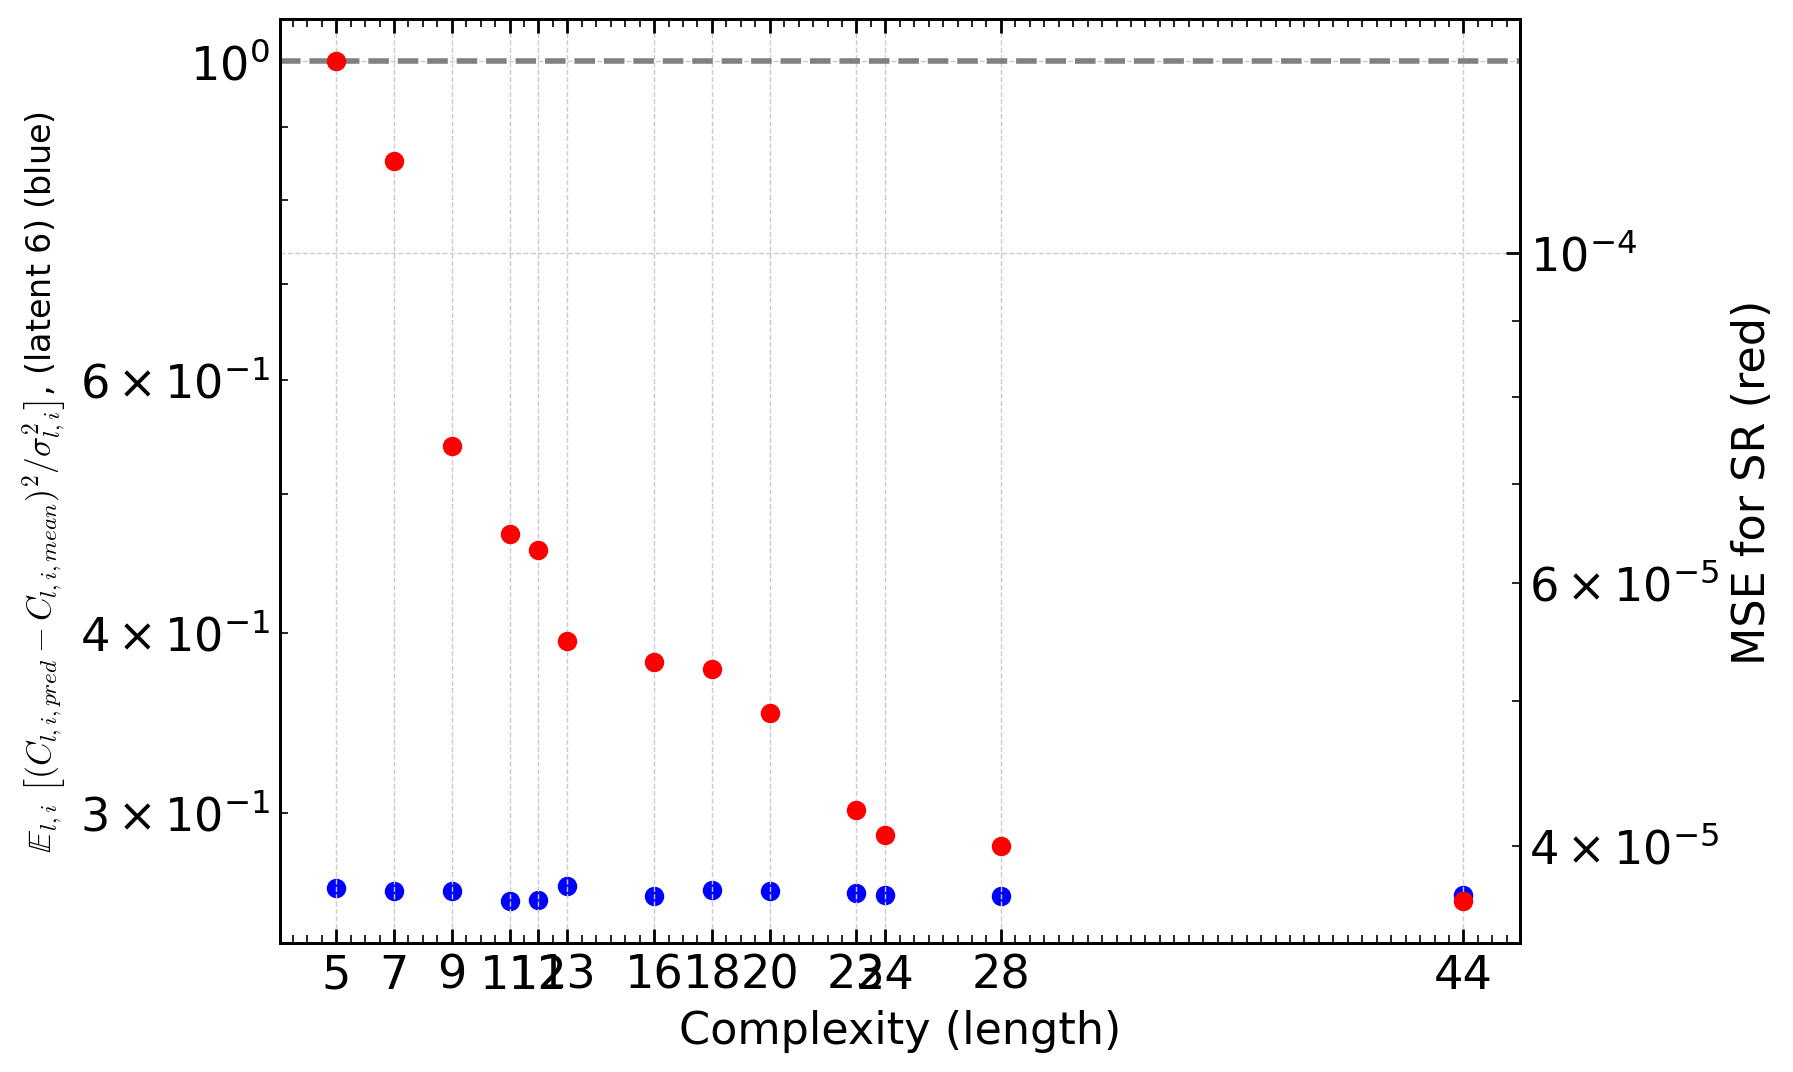

raw expression: (0.007 + (2.152 * ((-0.009) * X5)))
*****


0.007 - 0.019368*X5

***********************************
raw expression: ((-0.000) + (0.999 * ((0.016 * X4) - (0.021 * X5))))
*****


0.015984*X4 - 0.020979*X5

***********************************
raw expression: (0.000 + (1.002 * (((-0.021) * X5) + ((0.087 * X4) / (sqrt(1 + ((-20.080) * X1) ^ 2))))))
*****


0.00434133466135458*X4/sqrt(X1**2 + 0.00248011936318471) - 0.021042*X5

***********************************
raw expression: ((-0.000) + (0.991 * ((((-0.029) * X5) / (sqrt(1 + (2.181 * X1) ^ 2))) + ((0.094 * X4) / (sqrt(1 + (17.632 * X1) ^ 2))))))
*****


0.00528323502722323*X4/sqrt(X1**2 + 0.00321659843017645) - 0.0131769830353049*X5/sqrt(X1**2 + 0.210227085195157)

***********************************
raw expression: (0.001 + (0.891 * ((sin(((0.101 * X4) / (sqrt(1 + (14.485 * X1) ^ 2)))) + ((-0.037) * X5)) / (sqrt(1 + (2.905 * X1) ^ 2)))))
*****


0.001 + 0.30671256454389*(-0.037*X5 + sin(0.00697273041076976*X4/sqrt(X1**2 + 0.00476609836106984)))/sqrt(X1**2 + 0.11849710126466)

***********************************
raw expression: (0.005 + (1.035 * (((((-0.015) * X6) + ((-0.031) * X5)) + ((0.081 * X4) / (sqrt(1 + ((-12.682) * X1) ^ 2)))) / (sqrt(1 + (2.981 * X1) ^ 2)))))
*****


0.005 + 0.34719892653472*(0.00638700520422646*X4/sqrt(X1**2 + 0.00621762467288766) - 0.031*X5 - 0.015*X6)/sqrt(X1**2 + 0.112532002694916)

***********************************
raw expression: ((-0.000) + (0.989 * ((sin(((0.108 * X4) / (sqrt(1 + (13.125 * X1) ^ 2)))) / (sqrt(1 + (1.902 * X6) ^ 2))) - ((0.012 + (0.020 * X5)) + ((-0.022) * X1)))))
*****


0.021758*X1 - 0.01978*X5 - 0.011868 + 0.519978969505783*sin(0.00822857142857143*X4/sqrt(X1**2 + 0.00580498866213152))/sqrt(X6**2 + 0.276426054371899)

***********************************
raw expression: ((-0.002) + (0.977 * ((sin((((1.043 * X5) - 3.040) / (sqrt(1 + ((-0.743) * X6) ^ 2)))) - ((((-3.212) * X4) / (sqrt(1 + ((-16.693) * X1) ^ 2))) - (0.826 * X1))) / (sqrt(1 + (-31.275) ^ 2)))))
*****


0.0257902411294326*X1 + 0.00600781427628154*X4/sqrt(X1**2 + 0.00358865090443387) + 0.0312230522148094*sin((1.043*X5 - 3.04)/sqrt(0.552049*X6**2 + 1)) - 0.002

***********************************
raw expression: (0.000 + (1.002 * (((((-0.030) * X5) - ((-0.118) * X4)) / (sqrt(1 + ((-2.598) * X1) ^ 2))) + ((sin(((-5.218) * X1)) + (((-0.865) * X6) + (-1.467))) * ((-0.756) * ((-0.038) * X4))))))
*****


0.028785456*X4*(-0.865*X6 - sin(5.218*X1) - 1.467) + 0.38568129330254*(0.118*X4 - 0.03*X5)/sqrt(X1**2 + 0.148156840016096)

***********************************
raw expression: (0.014 + (1.183 * ((sin((sin(sin(((-0.010) * X5))) - (0.020 * X4))) - ((-0.047) * X1)) + ((((-0.013) * X5) + sin((((0.074 * X4) / (sqrt(1 + ((-1.265) * X6) ^ 2))) - (0.173 * X1)))) / (sqrt(1 + (4.439 * X1) ^ 2))))))
*****


0.055601*X1 - 1.183*sin(0.02*X4 + sin(sin(0.01*X5))) + 0.014 + 0.26650146429376*(-0.013*X5 - sin(0.173*X1 - 0.058498023715415*X4/sqrt(X6**2 + 0.624912121732881)))/sqrt(X1**2 + 0.0507492595302415)

***********************************
raw expression: (0.000 + (1.000 * ((((-0.014) * X4) + ((sin(((-5.358) * X1)) + (((1.545 - (((-6.812) * X4) / (sqrt(1 + (5.556 * X1) ^ 2)))) + ((-2.238) * X5)) / (sqrt(1 + (1.392 * X6) ^ 2)))) * (0.012 + ((-0.001) * X6)))) - 0.009)))
*****


-0.014*X4 + 1.0*(0.012 - 0.001*X6)*(-sin(5.358*X1) + 0.718390804597701*(1.2260619150468*X4/sqrt(X1**2 + 0.0323948166220136) - 2.238*X5 + 1.545)/sqrt(X6**2 + 0.516085348130533)) - 0.009

***********************************
raw expression: ((-0.000) + (1.000 * (((((1.179 * X5) / (sqrt(1 + (0.090 * X4) ^ 2))) - (sin((1.126 - (0.014 * X6))) + ((((-0.892) - ((2.886 * X4) / (sqrt(1 + (5.296 * X1) ^ 2)))) + (1.205 * X5)) / (sqrt(1 + ((-0.189) * X6) ^ 2))))) - ((-0.029) * X1)) + (((-2.792) * X4) / (sqrt(1 + ((-5.172) * X1) ^ 2))))))
*****


0.029*X1 - 0.539829853054911*X4/sqrt(X1**2 + 0.0373837589399521) + 1.179*X5/sqrt(0.0081*X4**2 + 1) + 1.0*sin(0.014*X6 - 1.126) - 1.0*(-0.544939577039275*X4/sqrt(X1**2 + 0.0356536541287502) + 1.205*X5 - 0.892)/sqrt(0.035721*X6**2 + 1)

***********************************
raw expression: ((-0.000) + (1.000 * (((-0.022) - ((-0.018) * (2.904 * (((2.140 * X4) / (sqrt(1 + ((-59.844) * X1) ^ 2))) + (((383.536 * X3) * (((-0.289) * X4) / (sqrt(1 + ((-3391.371) * X1) ^ 2)))) + ((((-0.108) * X5) - 0.637) / (sqrt(1 + (2.961 * X6) ^ 2)))))))) + (((-0.015) * X4) + ((sin(((-5.267) * X1)) + (((5.648 - (((-5.786) * X4) / (sqrt(1 + (4.501 * X1) ^ 2)))) + ((-1.972) * X5)) / (sqrt(1 + (1.743 * X6) ^ 2)))) * (0.011 + (0.000 * X6)))))))
*****


-0.00170843237318713*X3*X4/sqrt(X1**2 + 8.6945957732375e-8) - 0.015*X4 + 0.00186922799278123*X4/sqrt(X1**2 + 0.000279227875148112) + 0.0176534954407295*(-0.108*X5 - 0.637)/sqrt(X6**2 + 0.114057325896339) - 0.011*sin(5.267*X1) - 0.022 + 0.00631095811818703*(1.28549211286381*X4/sqrt(X1**2 + 0.0493607754893738) - 1.972*X5 + 5.648)/sqrt(X6**2 + 0.329158614624056)

***********************************


In [212]:
torch.manual_seed(43)
import pandas as pd

### Testing function for the retrained model
def test_epoch_replace(encoder, decoder, device, dataloader, loss_fn,maskindex, ind, ind_var):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for (1) batch of 500 testing samples
        conc_out = [] 
        conc_data_mean = [] 
        conc_err = []
        
        # Mask
        range_index=torch.arange(1, d_encode+1)
        mask = range_index.le(maskindex).unsqueeze(0).to(device)

        count = 0

        #param = torch.tensor(np.float32(np.load('./data/camb_new_processed/param_%s_%s.npy'%(types,name))))
        #data_batch_mean = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_mean_%s_%s.npy'%(types,name))))
        #err = torch.tensor(np.float32(np.load('./data/camb_new_processed/error_%s_%s.npy'%(types,name))))
        #data_batch = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_%s_%s.npy'%(types,name))))
        
        param = torch.tensor(np.float32(np.load('./data/camb_new_processed/param_%s.npy'%(name))))
        data_batch_mean = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_mean_%s.npy'%(name))))
        err = torch.tensor(np.float32(np.load('./data/camb_new_processed/error_%s.npy'%(name))))
        data_batch = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_%s.npy'%(name))))
            
        data_batch = data_batch.to(device)
        param = param.to(device)
        err = err.to(device)
        #data = data.to(device)
        
        # Encode data
        encoded_data= encoder(param)
        maskin_data = maskin(encoded_data)
        
        # Replacement
        sr_pred_i = sr_pred[ind] # Dimension: each ind has 500, the # of the testing samples
        maskin_data[:,ind_var] = sr_pred_i.to(device)
        
        # Decode data
        #decoded_data = decoder(maskin_data*mask)
        decoded_data = decoder(maskin_data)
        
        conc_out.append(trans(decoded_data.cpu()))
        conc_data_mean.append(trans(data_batch_mean[:,:]))
        conc_err.append(trans_error(trans(data_batch.cpu()[:,0,:]),err.cpu()))
                               
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_data_mean = torch.cat(conc_data_mean)
        conc_err = torch.cat(conc_err)

        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_data_mean[:,:],conc_err)
    return val_loss.data

### Define the loss function
#loss_fn = torch.nn.MSELoss()
def loss_fn(output, target, weight):
    loss = torch.mean((output - target)**2/weight,1)
    return loss

encoder = Encoder_cmb(encoded_space_dim=d_encode)
decoder = Decoder_cmb(encoded_space_dim=d_encode)
maskin = maskin_cmb()

model_state_save_early_path_checkpoint ='./model/checkpoint_%s.tar'%(name)
checkpoint_model = torch.load(model_state_save_early_path_checkpoint)
encoder.load_state_dict(checkpoint_model['encoder_state_dict'])
decoder.load_state_dict(checkpoint_model['decoder_state_dict'])
maskin.load_state_dict(checkpoint_model['maskin_state_dict'])

encoder.eval()
encoder.to(device)
decoder.eval()
decoder.to(device)
maskin.eval()
maskin.to(device)

maskindex = 6

for ind_var in range(maskindex):
    #test_name = operon_name+'latent%d'%ind_var # index of the latent variable
    test_name = types+'_'+runs+'_'+'latent%d'%ind_var # index of the latent variable
    test_losses_onloader_onemodel_parato=[]
    
    # Symbolic regression (sr) predictions
    # sr prediction: [len(expressions),500]
    sr_pred = torch.tensor(np.float32(np.load('./data/sr/pred_pareto_%s.npy'%test_name))) 
    # mse: [len(expressions),]
    mse_pred = np.load('./data/sr/mse_pareto_%s.npy'%test_name) 
    # expressions: [len(expressions),]
    data0=pd.read_csv('./data/sr/pareto_%s.csv'%test_name) 

    # Lengh of the points in the parato front
    num_plot = len(sr_pred)
    for ind in range(num_plot):
        temp=test_epoch_replace(encoder, decoder, device, test_loader, loss_fn,maskindex, ind, ind_var) # Here the test_loader
        test_losses_onloader_onemodel_parato.append(np.array(temp))
        
    # Complexity of the expressions
    test_losses_onloader_onemodel_parato = np.array(test_losses_onloader_onemodel_parato)
    complexity=pd.read_csv('./data/sr/pareto_%s.csv'%test_name)['length'].values
    
    ### Plot the results
    # The weighted loss
    fig,ax = plt.subplots(figsize=(8,6))
    ax.scatter(complexity[:num_plot],np.percentile(test_losses_onloader_onemodel_parato,50,axis=1), c='blue')
    ax.set_xlabel('Complexity (length)',fontsize=16)
    #ax.set_ylabel('Weighted MSE (latent%d) for Pareto (blue)'%(ind_var+1),fontsize=16)
    ax.set_ylabel(r'$\mathbb{E}_{l,i}\ \left[(C_{l,i,pred}-C_{l,i,mean})^2/\sigma_{l,i}^2 \right]$, (latent %d) (blue)'%(ind_var+1),fontsize=12)

    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.axhline(1., color="grey", linestyle="--") # The threshold for the weighted error (likelihood)
    plt.xticks(list(np.sort(complexity)))

    # Create a second axis for the mse plots
    ax2=ax.twinx()
    ax2.scatter(complexity[:num_plot],mse_pred,color='r')
    ax2.set_yscale('log')
    ax2.set_ylabel('MSE for SR (red)',fontsize=16)
    
    print ('The weighted MSE:',np.array(test_losses_onloader_onemodel_parato))
    plt.show()
    plt.close()
    for i in range(len(complexity)):
        print ('raw expression:',data0['infix'][i])
        print ('*****')
        pprint (data0['infix'][i].replace('^','**'))
        print ('***********************************')

(16, 500)
The weighted MSE: [[4.06627491e+01 1.45877964e+01 1.29501906e+00 ... 5.07550004e+00
  2.23031129e+01 6.84330102e+01]
 [4.80426717e+01 7.64621302e+00 1.06728055e+01 ... 2.14673181e+01
  6.10716853e-01 4.95498889e+00]
 [1.28227909e+01 1.79865558e+00 3.98281455e+01 ... 1.77979696e+01
  2.09065537e+01 2.76502036e+01]
 ...
 [9.63443767e-02 4.35925583e-02 3.92679367e+00 ... 6.19633713e-01
  9.76005428e-01 4.62511705e+00]
 [1.04172443e-01 7.36301956e-01 1.78167003e+00 ... 5.88497261e-01
  2.80795874e+00 2.94834050e-01]
 [2.72988789e-01 1.99508541e-01 2.65678475e-01 ... 8.14559984e-01
  3.88887507e-01 3.11745413e-01]]


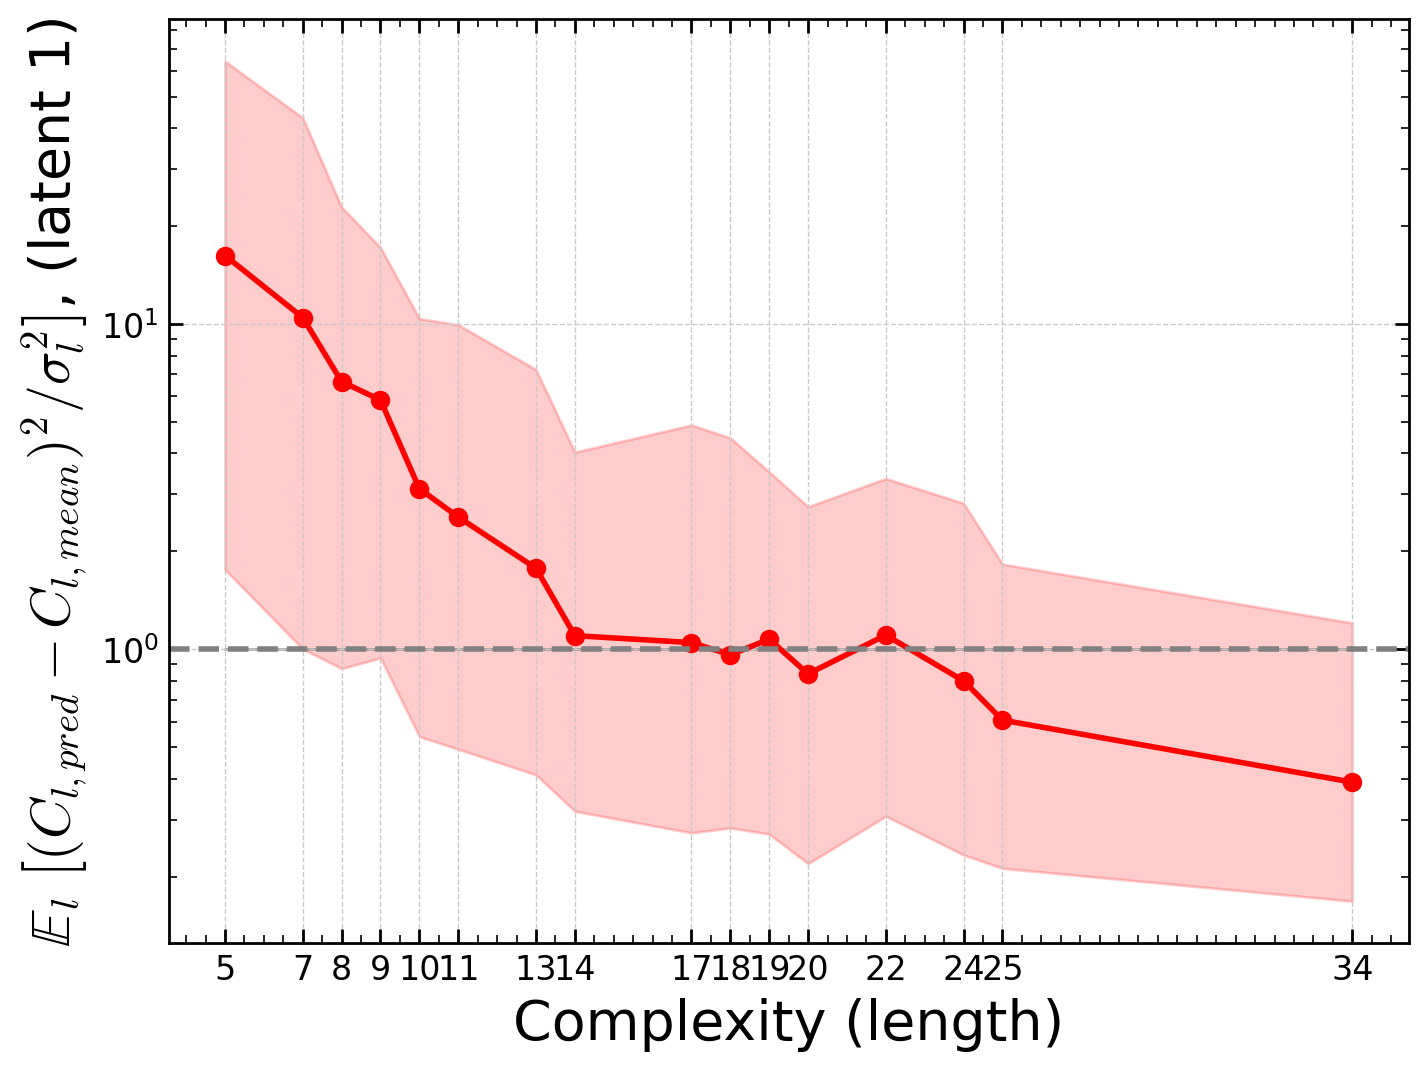

raw expression: ((-0.273) + ((-4.884) * ((-0.090) * X2)))
*****


0.43956*X2 - 0.273

***********************************
raw expression: (0.060 + (0.889 * (((-1.350) * X1) / (sqrt(1 + ((-9.467) * X2) ^ 2)))))
*****


-0.126771944649836*X1/sqrt(X2**2 + 0.011157714529182) + 0.06

***********************************
raw expression: ((-0.058) + (0.331 * ((1.524 * X2) - sin((2.317 * X1)))))
*****


0.504444*X2 - 0.331*sin(2.317*X1) - 0.058

***********************************
raw expression: ((-0.079) + (0.959 * (((-0.168) * X4) + (((-0.371) * X1) - ((-0.547) * X2)))))
*****


-0.355789*X1 + 0.524573*X2 - 0.161112*X4 - 0.079

***********************************
raw expression: (0.016 + (0.328 * (((1.563 * X2) - (0.493 * X4)) + sin(((-2.325) * X1)))))
*****


0.512664*X2 - 0.161704*X4 - 0.328*sin(2.325*X1) + 0.016

***********************************
raw expression: (0.004 + (1.002 * ((((-0.264) * X4) + (((-0.719) * X1) - ((-0.700) * X2))) / (sqrt(1 + ((-2.336) * X6) ^ 2)))))
*****


0.004 + 0.428938356164384*(-0.719*X1 + 0.7*X2 - 0.264*X4)/sqrt(X6**2 + 0.183254362919872)

***********************************
raw expression: (0.101 + (1.017 * ((((-0.204) * X4) + (((-0.600) * X1) - (((-0.617) * X2) + 0.154))) / (sqrt(1 + ((-1.716) * X6) ^ 2)))))
*****


0.101 + 0.592657342657343*(-0.6*X1 + 0.617*X2 - 0.204*X4 - 0.154)/sqrt(X6**2 + 0.339598241696144)

***********************************
raw expression: (0.031 + (0.103 * (sin(((-4.748) * X1)) - ((((-4.326) * X2) - ((-1.516) * X4)) + ((5.553 * X1) + ((-1.228) * X6))))))
*****


-0.571959*X1 + 0.445578*X2 - 0.156148*X4 + 0.126484*X6 - 0.103*sin(4.748*X1) + 0.031

***********************************
raw expression: (0.053 + (1.065 * sin((((((-0.196) * X4) + (sin(((2.348 * X1) / (sqrt(1 + (0.992 * X2) ^ 2)))) * (-0.420))) - ((-0.532) * X2)) / (sqrt(1 + ((-1.531) * X6) ^ 2))))))
*****


1.065*sin(0.653167864141084*(0.532*X2 - 0.196*X4 - 0.42*sin(2.348*X1/sqrt(0.984064*X2**2 + 1)))/sqrt(X6**2 + 0.426628258746626)) + 0.053

***********************************
raw expression: (0.048 + (0.711 * ((sin(sin(((-1.864) * X1))) - (sin(((((-0.830) * X1) + ((-2.732) * X2)) / (sqrt(1 + 2.621 ^ 2)))) + (0.290 * X4))) / (sqrt(1 + (1.414 * X6) ^ 2)))))
*****


0.048 + 0.502828854314003*(-0.29*X4 + sin(0.295869795721159*X1 + 0.973875038446031*X2) - sin(sin(1.864*X1)))/sqrt(X6**2 + 0.500151045615776)

***********************************
raw expression: ((-0.010) + (0.661 * ((((-0.239) * X4) + sin((sin(((-1.749) * X1)) - (((((-0.630) * X1) - (0.211 * X6)) / (sqrt(1 + ((-1.287) * X2) ^ 2))) - (0.873 * X2))))) - 0.064)))
*****


-0.157979*X4 - 0.661*sin(-0.873*X2 + 0.777000777000777*(-0.63*X1 - 0.211*X6)/sqrt(X2**2 + 0.603730207459811) + sin(1.749*X1)) - 0.052304

***********************************
raw expression: ((-0.024) + (0.505 * (((sin(((-0.317) * X4)) + (((-0.986) * X1) - ((-0.238) * X6))) + sin((sin(((-2.127) * X1)) + ((1.412 * X1) - ((-1.387) * X2))))) - (0.271 * X2))))
*****


-0.49793*X1 - 0.136855*X2 + 0.12019*X6 - 0.505*sin(0.317*X4) + 0.505*sin(1.412*X1 + 1.387*X2 - sin(2.127*X1)) - 0.024

***********************************
raw expression: ((-0.000) + (1.000 * (((((-0.156) * X4) + ((0.002 * X1) - ((-0.130) * X6))) - (1.453 - (0.448 * X2))) - ((((-0.473) / (sqrt(1 + ((-6.345) * X1) ^ 2))) - ((-0.030) * X5)) + sin((-14.138))))))
*****


0.002*X1 + 0.448*X2 - 0.156*X4 - 0.03*X5 + 0.13*X6 - 0.4530003469935 + 0.0745468873128448/sqrt(X1**2 + 0.0248391509729806)

***********************************
raw expression: (0.024 + (0.414 * (sin((((0.402 * X6) / (sqrt(1 + (-0.004) ^ 2))) - (((sin(((2.185 * X1) / (sqrt(1 + (0.615 * X2) ^ 2)))) * 1.127) - ((-0.104) * X5)) - ((-0.332) * X2)))) + sin((((-0.425) * X4) + (1.542 * X2))))))
*****


0.414*sin(1.542*X2 - 0.425*X4) - 0.414*sin(0.332*X2 + 0.104*X5 - 0.401996784038592*X6 + 1.127*sin(2.185*X1/sqrt(0.378225*X2**2 + 1))) + 0.024

***********************************
raw expression: ((-0.159) + (0.983 * (((0.153 * X6) / (sqrt(1 + ((-1.287) * X2) ^ 2))) - ((((0.161 * X4) + (0.029 * X1)) - (((0.136 * X2) + 0.920) * (((-0.319) / (sqrt(1 + (4.209 * X2) ^ 2))) - ((-0.479) / (sqrt(1 + (7.518 * X1) ^ 2)))))) - (0.212 * X2)))))
*****


-0.028507*X1 + 0.208396*X2 - 0.158263*X4 + 0.11686013986014*X6/sqrt(X2**2 + 0.603730207459811) + 0.983*(0.136*X2 + 0.92)*(-0.0757899738655263/sqrt(X2**2 + 0.0564471667784038) + 0.0637137536578877/sqrt(X1**2 + 0.0176927506643451)) - 0.159

***********************************
raw expression: (0.040 + (1.105 * ((((((-1.289) * X1) - ((-0.024) * X4)) / (sqrt(1 + (((0.211 * X2) - ((-0.317) * X4)) - ((2.843 * X1) + (0.972 * X6))) ^ 2))) + (((-0.107) * X5) / (sqrt(1 + (-3.682) ^ 2)))) + (((sin((((-0.159) * X4) + ((0.273 * X1) - ((-1.564) * X2)))) - sin((0.192 * X4))) + sin(((-0.162) * X1))) * 0.393))))
*****


-0.0309890501629842*X5 + 0.388673935983116*(-1.289*X1 + 0.024*X4)/sqrt((-X1 + 0.0742173760112557*X2 + 0.111501934576152*X4 - 0.341892367217728*X6)**2 + 0.123721814469489) - 0.434265*sin(0.162*X1) - 0.434265*sin(0.192*X4) + 0.434265*sin(0.273*X1 + 1.564*X2 - 0.159*X4) + 0.04

***********************************
(9, 500)
The weighted MSE: [[3.20139614 3.2014731  0.54644978 ... 1.67827785 2.27383996 2.02700242]
 [2.72108471 2.58184158 0.39154049 ... 2.33723917 1.79816003 1.10546513]
 [1.25021536 0.24406688 0.09623314 ... 0.13396442 2.55513629 0.91583551]
 ...
 [0.50873608 0.12566055 0.67056558 ... 0.15676701 0.91191681 0.3167721 ]
 [0.22406176 0.1259838  0.75314025 ... 0.14251495 0.73682096 0.29002092]
 [0.38155581 0.13853907 0.38005724 ... 0.14706852 0.46885371 0.25737656]]


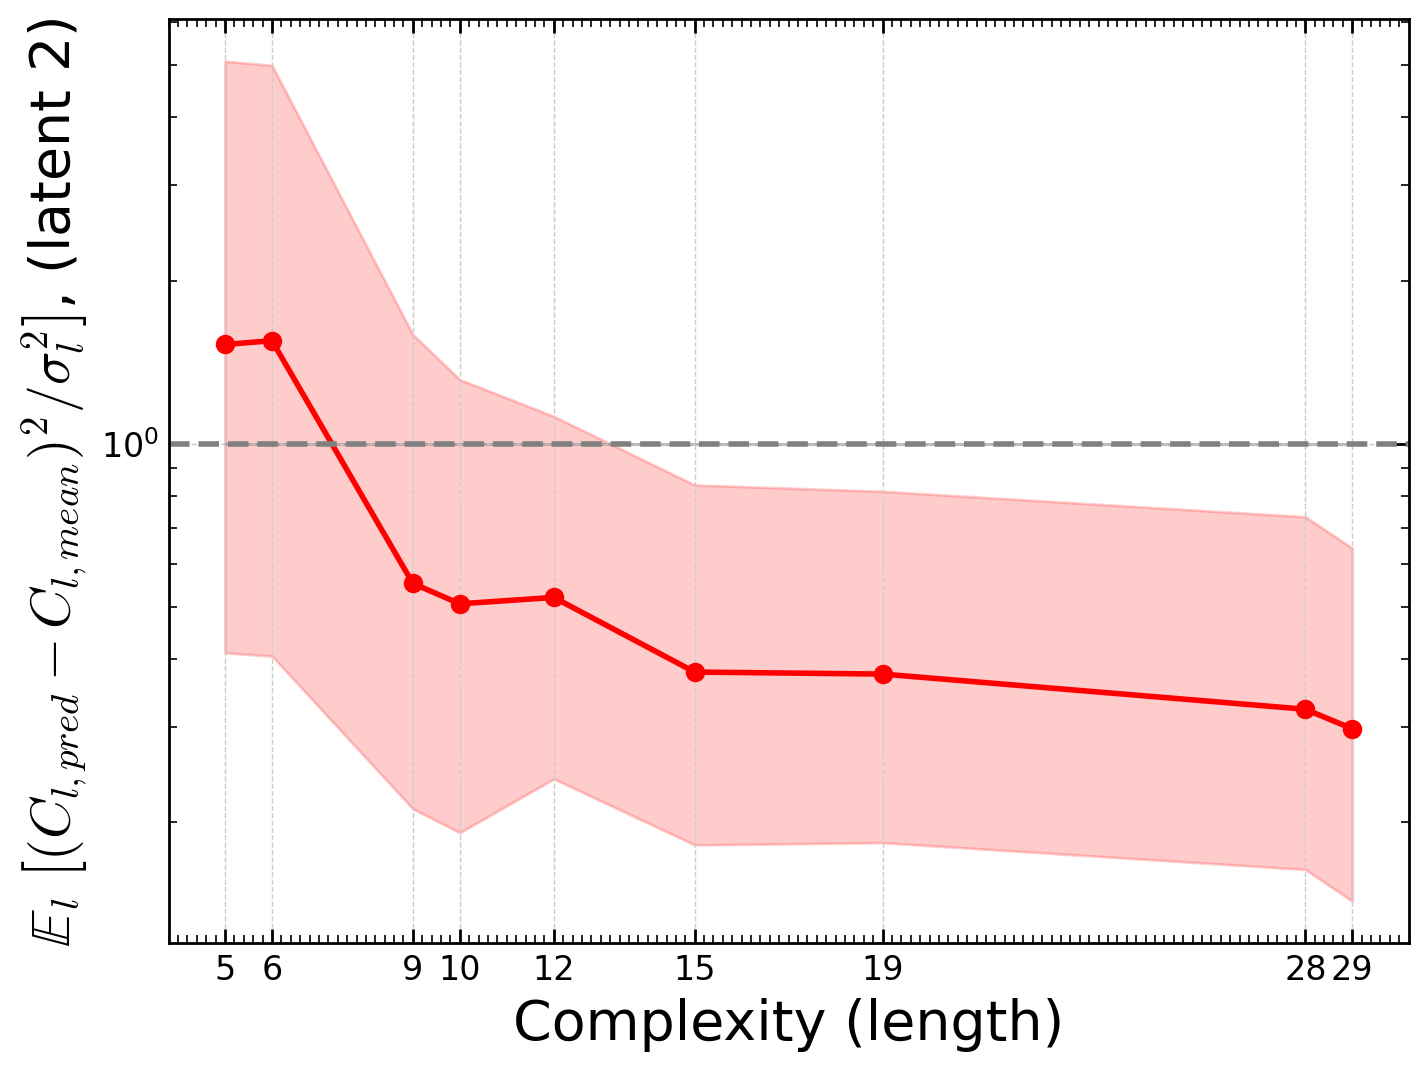

raw expression: ((-0.399) + (2.291 * (0.598 * X2)))
*****


1.370018*X2 - 0.399

***********************************
raw expression: ((-0.430) + (1.675 * sin((0.900 * X2))))
*****


1.675*sin(0.9*X2) - 0.43

***********************************
raw expression: (0.000 + (1.000 * ((-0.466) - (((-0.240) * X6) + ((-1.220) * X2)))))
*****


1.22*X2 + 0.24*X6 - 0.466

***********************************
raw expression: ((-1.346) + (2.705 * sin((0.312 - (((-0.107) * X6) + ((-0.560) * X2))))))
*****


2.705*sin(0.56*X2 + 0.107*X6 + 0.312) - 1.346

***********************************
raw expression: ((-0.001) + (0.996 * (((-0.435) - (0.069 * X4)) - (sin(((-0.243) * X6)) - (1.230 * X2)))))
*****


1.22508*X2 - 0.068724*X4 + 0.996*sin(0.243*X6) - 0.43426

***********************************
raw expression: ((-0.002) + (0.992 * (((-0.478) + (0.424 * X2)) + (((0.245 * X6) + ((-0.071) * X4)) - sin(sin(((-1.008) * X2)))))))
*****


0.420608*X2 - 0.070432*X4 + 0.24304*X6 + 0.992*sin(sin(1.008*X2)) - 0.476176

***********************************
raw expression: (0.003 + (1.005 * ((-0.070) + ((((0.241 * X6) + (1.798 * X2)) + ((-0.070) * X4)) + ((-1.031) / (sqrt(1 + (2.278 - ((0.002 * X6) - ((-2.017) * X2))) ^ 2)))))))
*****


1.80699*X2 - 0.07035*X4 + 0.242205*X6 - 0.06735 - 0.454852941176471/sqrt((-0.885425812115891*X2 - 0.000877963125548727*X6 + 1)**2 + 0.192704812455822)

***********************************
raw expression: ((-0.150) + (3.554 * (((sin(((sin((-0.091)) / (sqrt(1 + ((217.850 * X6) / (sqrt(1 + (-106.882) ^ 2))) ^ 2))) + ((2.710 * X2) / (sqrt(1 + 3.340 ^ 2))))) + (sin((0.784 * X1)) - (0.020 * X4))) - ((1.083 * X1) / (sqrt(1 + ((-0.280) * X6) ^ 2)))) + ((0.330 * X1) - (0.393 * X2)))))
*****


1.17282*X1 - 3.848982*X1/sqrt(0.0784*X6**2 + 1) - 1.396722*X2 - 0.07108*X4 + 3.554*sin(0.784*X1) + 3.554*sin(0.77728643869075*X2 - 0.0445869580030378/sqrt(X6**2 + 0.240731005709236)) - 0.15

***********************************
raw expression: ((-0.002) + (1.005 * ((((((-14.000) + (((-7.302) * X1) + ((865.260 * X2) / (sqrt(1 + (-188.649) ^ 2))))) / (sqrt(1 + (((-1.954) * X1) - ((0.366 * X6) + 3.634)) ^ 2))) + 3.218) + (((0.078 * X4) - ((-0.646) * X2)) / (sqrt(1 + ((14.722 * X2) / (sqrt(1 + ((-17.372) * X1) ^ 2))) ^ 2)))) + ((-0.127) * X4))))
*****


-0.127635*X4 + 1.005*(0.646*X2 + 0.078*X4)/sqrt(0.718181122445869*X2**2/(X1**2 + 0.00331360211400392) + 1) + 3.23209 + 0.276554760594386*(-7.302*X1 + 4.58654879581885*X2 - 14.0)/sqrt((-0.537699504678041*X1 - 0.100715465052284*X6 - 1)**2 + 0.0757234084378291)

***********************************
(11, 500)
The weighted MSE: [[ 2.40554798  5.07262231 13.51719371 ...  5.13840518  0.45342486
   2.69657719]
 [ 2.36919608  4.14615053 16.29926684 ...  3.84221682  0.67365548
   1.08304913]
 [ 0.19581978  2.9019991   2.68211865 ...  1.77813625  0.87875868
   0.23790744]
 ...
 [ 0.18003799  0.49776678  0.17003021 ...  0.22977373  0.64535037
   1.2170675 ]
 [ 0.11954019  0.14431073  0.15625377 ...  0.21090054  0.49108296
   0.2394682 ]
 [ 0.14909039  0.27400364  0.3493848  ...  0.12768639  0.47947151
   0.23689199]]


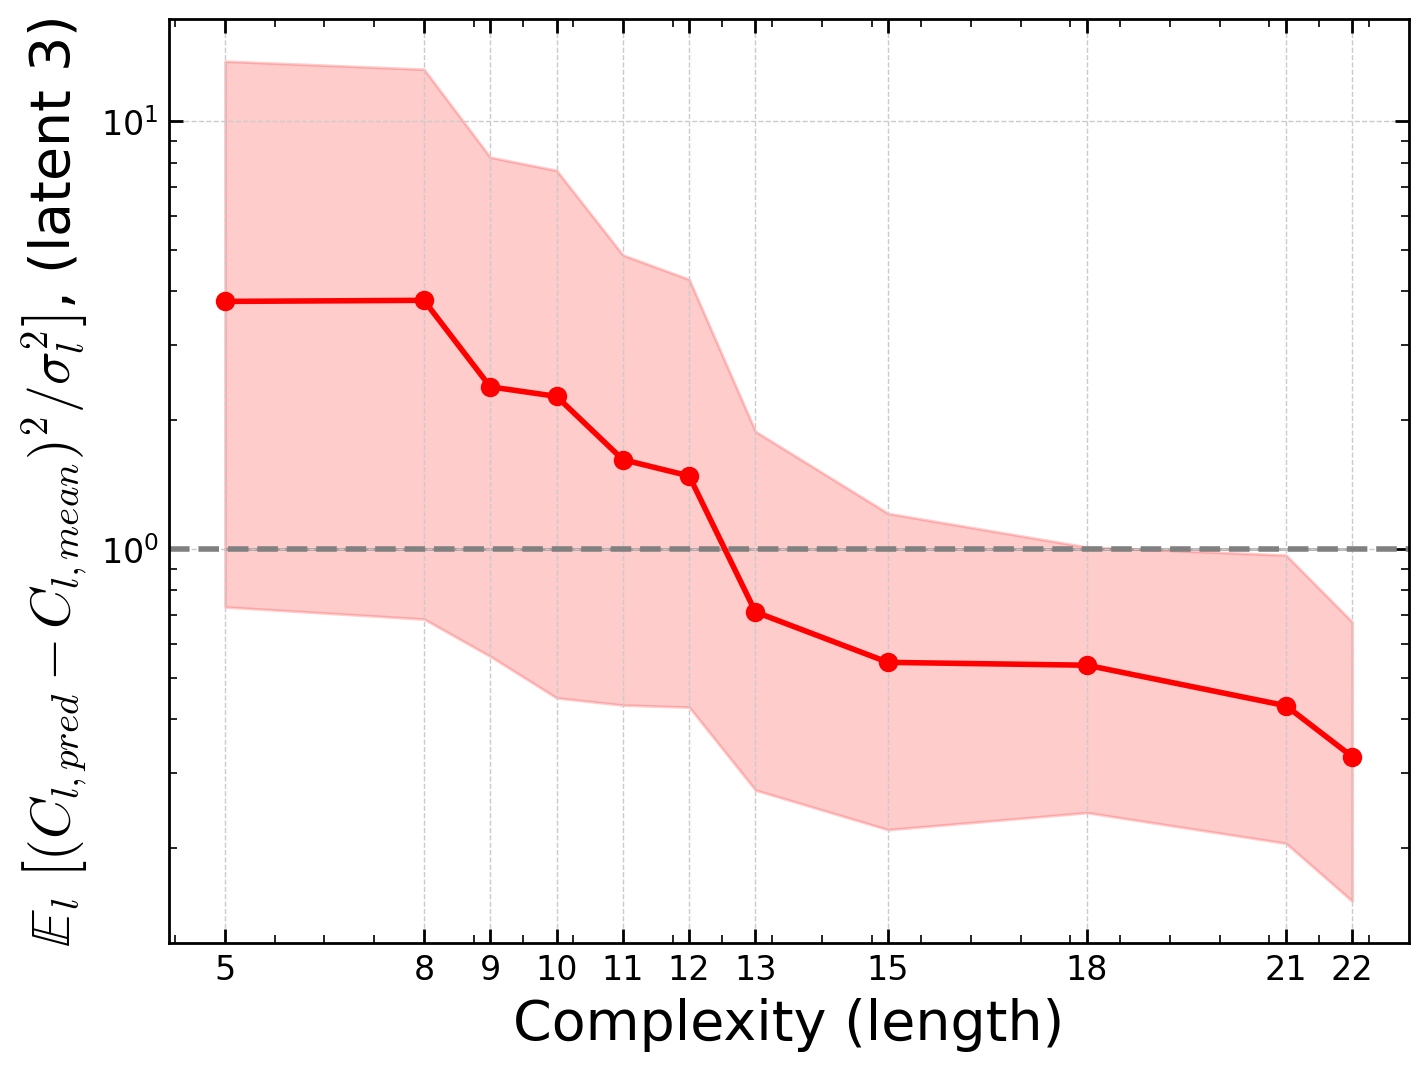

raw expression: (0.578 + ((-4.248) * (0.213 * X2)))
*****


0.578 - 0.904824*X2

***********************************
raw expression: (0.644 + ((-4.354) * ((0.288 * X2) / (sqrt(1 + sin((1.312 * X2)) ^ 2)))))
*****


-1.253952*X2/sqrt(sin(1.312*X2)**2 + 1) + 0.644

***********************************
raw expression: (0.000 + (1.000 * ((((-0.991) * X2) - (-0.446)) - ((-0.396) * X1))))
*****


0.396*X1 - 0.991*X2 + 0.446

***********************************
raw expression: (0.040 + (0.912 * ((0.506 - ((-0.434) * X1)) - sin((1.364 * X2)))))
*****


0.395808*X1 - 0.912*sin(1.364*X2) + 0.501472

***********************************
raw expression: ((-0.000) + (1.000 * ((((-0.853) * X2) - (-0.481)) - ((0.261 * X6) - (0.510 * X1)))))
*****


0.51*X1 - 0.853*X2 - 0.261*X6 + 0.481

***********************************
raw expression: (0.113 + (0.741 * ((((-0.361) * X6) - ((-0.692) * X1)) + (0.583 + sin(((-1.539) * X2))))))
*****


0.512772*X1 - 0.267501*X6 - 0.741*sin(1.539*X2) + 0.545003

***********************************
raw expression: ((-0.000) + (1.000 * (((((-0.266) * X6) - (0.835 * X2)) - (-0.473)) + ((0.721 * X1) / (sqrt(1 + (2.055 * X4) ^ 2))))))
*****


0.350851581508516*X1/sqrt(X4**2 + 0.236797082659942) - 0.835*X2 - 0.266*X6 + 0.473

***********************************
raw expression: ((-0.000) + (1.000 * ((((1.106 / (sqrt(1 + (2.930 * X2) ^ 2))) / (sqrt(1 + ((-0.945) * X4) ^ 2))) - (((-0.512) * X1) - ((-0.281) * X6))) + (-0.522))))
*****


0.512*X1 - 0.281*X6 - 0.522 + 0.377474402730375/(sqrt(X2**2 + 0.116483593285886)*sqrt(0.893025*X4**2 + 1))

***********************************
raw expression: ((-0.071) + (1.174 * ((((-0.021) * X5) - (((sin(((0.221 * X4) - ((-0.249) * X6))) - (-2.247)) / (sqrt(1 + ((-0.691) * X1) ^ 2))) - 2.909)) - (0.717 * X2))))
*****


-0.841758*X2 - 0.024654*X5 + 3.344166 - 1.174*(sin(0.221*X4 + 0.249*X6) + 2.247)/sqrt(0.477481*X1**2 + 1)

***********************************
raw expression: (0.003 + (0.985 * ((((((-0.277) * X6) - ((-0.232) * X2)) - (-0.464)) + ((0.534 * X1) / (sqrt(1 + (0.209 * X4) ^ 2)))) + ((sin(((-0.239) * X4)) - (-0.191)) - sin((1.347 * X2))))))
*****


0.52599*X1/sqrt(0.043681*X4**2 + 1) + 0.22852*X2 - 0.272845*X6 - 0.985*sin(1.347*X2) - 0.985*sin(0.239*X4) + 0.648175

***********************************
raw expression: (0.003 + (0.993 * ((((-0.385) * X2) + ((0.507 / (sqrt(1 + ((-4.110) * X2) ^ 2))) - ((0.038 * X1) + (0.280 * X6)))) - (((sin((0.256 * X4)) - (-2.406)) / (sqrt(1 + ((-0.803) * X1) ^ 2))) - 2.619))))
*****


-0.037734*X1 - 0.382305*X2 - 0.27804*X6 + 2.603667 + 0.122494160583942/sqrt(X2**2 + 0.0591992706649854) - 0.993*(sin(0.256*X4) + 2.406)/sqrt(0.644809*X1**2 + 1)

***********************************


KeyboardInterrupt: 

In [210]:
torch.manual_seed(43)
import pandas as pd

### Testing function for the retrained model
def test_epoch_replace(encoder, decoder, device, dataloader, loss_fn,maskindex, ind, ind_var):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for (1) batch of 500 testing samples
        conc_out = [] 
        conc_data_mean = [] 
        conc_err = []
        
        # Mask
        range_index=torch.arange(1, d_encode+1)
        mask = range_index.le(maskindex).unsqueeze(0).to(device)

        count = 0

        #param = torch.tensor(np.float32(np.load('./data/camb_new_processed/param_%s_%s.npy'%(types,name))))
        #data_batch_mean = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_mean_%s_%s.npy'%(types,name))))
        #err = torch.tensor(np.float32(np.load('./data/camb_new_processed/error_%s_%s.npy'%(types,name))))
        #data_batch = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_%s_%s.npy'%(types,name))))
        
        param = torch.tensor(np.float32(np.load('./data/camb_new_processed/param_%s.npy'%(name))))
        data_batch_mean = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_mean_%s.npy'%(name))))
        err = torch.tensor(np.float32(np.load('./data/camb_new_processed/error_%s.npy'%(name))))
        data_batch = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_%s.npy'%(name))))
            
        data_batch = data_batch.to(device)
        param = param.to(device)
        err = err.to(device)
        #data = data.to(device)
        
        # Encode data
        encoded_data= encoder(param)
        maskin_data = maskin(encoded_data)
        
        # Replacement
        sr_pred_i = sr_pred[ind] # Dimension: each ind has 500, the # of the testing samples
        maskin_data[:,ind_var] = sr_pred_i.to(device)
        
        # Decode data
        #decoded_data = decoder(maskin_data*mask)
        decoded_data = decoder(maskin_data)
        
        conc_out.append(trans(decoded_data.cpu()))
        conc_data_mean.append(trans(data_batch_mean[:,:]))
        conc_err.append(trans_error(trans(data_batch.cpu()[:,:])[:,0,:],err.cpu()))
                               
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_data_mean = torch.cat(conc_data_mean)
        conc_err = torch.cat(conc_err)

        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_data_mean[:,:],conc_err)
    return val_loss.data

### Define the loss function
#loss_fn = torch.nn.MSELoss()
def loss_fn(output, target, weight):
    loss = torch.mean((output - target)**2/weight,1)
    return loss

encoder = Encoder_cmb(encoded_space_dim=d_encode)
decoder = Decoder_cmb(encoded_space_dim=d_encode)
maskin = maskin_cmb()

model_state_save_early_path_checkpoint ='./model/checkpoint_%s.tar'%(name)
checkpoint_model = torch.load(model_state_save_early_path_checkpoint)
encoder.load_state_dict(checkpoint_model['encoder_state_dict'])
decoder.load_state_dict(checkpoint_model['decoder_state_dict'])
maskin.load_state_dict(checkpoint_model['maskin_state_dict'])

encoder.eval()
encoder.to(device)
decoder.eval()
decoder.to(device)
maskin.eval()
maskin.to(device)

maskindex = 6

for ind_var in range(maskindex):
#for ind_var in range(2):
    #test_name = operon_name+'latent%d'%ind_var # index of the latent variable
    test_name = types+'_'+runs+'_'+'latent%d'%ind_var # index of the latent variable
    test_losses_onloader_onemodel_parato=[]
    
    # Symbolic regression (sr) predictions
    # sr prediction: [len(expressions),500]
    sr_pred = torch.tensor(np.float32(np.load('./data/sr/pred_pareto_%s.npy'%test_name))) 
    # mse: [len(expressions),]
    mse_pred = np.load('./data/sr/mse_pareto_%s.npy'%test_name) 
    # expressions: [len(expressions),]
    data0=pd.read_csv('./data/sr/pareto_%s.csv'%test_name) 

    # Lengh of the points in the parato front
    num_plot = len(sr_pred)
    for ind in range(num_plot):
        temp=test_epoch_replace(encoder, decoder, device, test_loader, loss_fn,maskindex, ind, ind_var) # Here the test_loader
        test_losses_onloader_onemodel_parato.append(np.array(temp))
        
    # Complexity of the expressions
    complexity=pd.read_csv('./data/sr/pareto_%s.csv'%test_name)['length'].values
    
    ### Plot the results
    # The weighted loss
    test_losses_onloader_onemodel_parato = np.array(test_losses_onloader_onemodel_parato)
    print (test_losses_onloader_onemodel_parato.shape)
    fig,ax = plt.subplots(figsize=(8,6))

    ax.plot(complexity[:num_plot],np.percentile(test_losses_onloader_onemodel_parato,50,axis=1), 'or-')
    ax.set_xlabel('Complexity (length)')
    #ax.set_ylabel('Weighted MSE (latent%d)'%ind_var,fontsize=16)
    ax.set_ylabel(r'$\mathbb{E}_l\ \left[(C_{l,pred}-C_{l,mean})^2/\sigma_l^2 \right]$, (latent %d)'%(ind_var+1),fontsize=20)
    ax.set_yscale('log')
    #ax.set_xscale('log')
    per_S0 = np.percentile(test_losses_onloader_onemodel_parato,50-32,axis=1)
    per_S1 = np.percentile(test_losses_onloader_onemodel_parato,50+32,axis=1)
    ax.fill_between(complexity[:num_plot], per_S0, per_S1, color='r',
                 alpha=0.2,label='Prediction')
    ax.axhline(1., color="grey", linestyle="--") # The threshold for the weighted error (likelihood)
    ax.fill_between(complexity[:num_plot], np.sqrt(1.-2/2499), np.sqrt(1.+2/2499), color='grey',
                 alpha=0.6,label='Threshold')
    plt.xticks(list(np.sort(complexity)))
    plt.tick_params(labelsize=12)
    
    print ('The weighted MSE:',np.array(test_losses_onloader_onemodel_parato))
    
    if ind_var ==0:
        plt.savefig('./first.pdf')
    plt.show()
    plt.close()
    for i in range(len(complexity)):
        print ('raw expression:',data0['infix'][i])
        print ('*****')
        pprint (data0['infix'][i].replace('^','**'))
        print ('***********************************')

In [209]:
!pwd

/scratch/zxs/scripts/Diffuse/Conditional_Diffusion_MNIST/YuanSen/diffusionv0/Matt/IOB_spectra/IOB_cmb/IOB_cmb_test


#### Replace all with the maximum complexity

In [203]:
import torch
torch.manual_seed(43)
import pandas as pd


### Testing function for the retrained model
def test_epoch_replace(encoder, decoder, device, dataloader, loss_fn,maskindex, ind, ind_var):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for (1) batch of 500 testing samples
        conc_out = [] 
        conc_data_mean = [] 
        conc_err = []
        conc_out_true = []
        
        # Mask
        range_index=torch.arange(1, d_encode+1)
        mask = range_index.le(maskindex).unsqueeze(0).to(device)
        
        print ('mask',mask )

        count = 0

        #param = torch.tensor(np.float32(np.load('./data/camb_new_processed/param_%s_%s.npy'%(types,name))))
        #data_batch_mean = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_mean_%s_%s.npy'%(types,name))))
        #err = torch.tensor(np.float32(np.load('./data/camb_new_processed/error_%s_%s.npy'%(types,name))))
        #data_batch = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_%s_%s.npy'%(types,name))))
        
        param = torch.tensor(np.float32(np.load('./data/camb_new_processed/param_%s.npy'%(name))))
        data_batch_mean = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_mean_%s.npy'%(name))))
        err = torch.tensor(np.float32(np.load('./data/camb_new_processed/error_%s.npy'%(name))))
        data_batch = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_%s.npy'%(name))))
            
        data_batch = data_batch.to(device)
        param = param.to(device)
        err = err.to(device)
        #data = data.to(device)
        
        # Encode data
        encoded_data= encoder(param)
        maskin_data = maskin(encoded_data)
        
        # Replacement
        sr_pred_i = sr_pred[ind[0]-1] # Dimension: each ind has 500, the # of the testing samples
        sr_pred_i1 = sr_pred1[ind[1]-1] 
        sr_pred_i2 = sr_pred2[ind[2]-1] 
        sr_pred_i3 = sr_pred3[ind[3]-1] 
        sr_pred_i4 = sr_pred4[ind[4]-1] 
        sr_pred_i5 = sr_pred5[ind[5]-1] 

        maskin_data[:,0] = sr_pred_i.to(device)
        maskin_data[:,1] = sr_pred_i1.to(device)
        maskin_data[:,2] = sr_pred_i2.to(device)
        maskin_data[:,3] = sr_pred_i3.to(device)
        maskin_data[:,4] = sr_pred_i4.to(device)
        maskin_data[:,5] = sr_pred_i5.to(device)
        
        # Decode data
        decoded_data = decoder(maskin_data*mask)
        
        conc_out_true.append(trans(data_batch.cpu()[:,0,:]))
        conc_out.append(trans(decoded_data.cpu()))
        conc_data_mean.append(trans(data_batch_mean[:,:]))
        conc_err.append(trans_error(trans(data_batch.cpu()[:,:])[:,0,:],err.cpu()))
                               
        # Create a single tensor with all the values in the lists
        conc_out_true = torch.cat(conc_out_true)
        conc_out = torch.cat(conc_out)
        conc_data_mean = torch.cat(conc_data_mean)
        conc_err = torch.cat(conc_err)

        print (conc_out.shape)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_data_mean[:,:],conc_err)
    #return val_loss.data, conc_out, conc_out_true
    return val_loss.data, conc_out, conc_data_mean, conc_out_true,conc_err

def loss_fn(output, target, weight):
    print (output.shape,target.shape,weight.shape)
    loss = torch.mean((output - target)**2/weight,1)
    return loss

encoder = Encoder_cmb(encoded_space_dim=d_encode)
decoder = Decoder_cmb(encoded_space_dim=d_encode)
maskin = maskin_cmb()

model_state_save_early_path_checkpoint ='./model/checkpoint_%s.tar'%(name)
checkpoint_model = torch.load(model_state_save_early_path_checkpoint)
encoder.load_state_dict(checkpoint_model['encoder_state_dict'])
decoder.load_state_dict(checkpoint_model['decoder_state_dict'])
maskin.load_state_dict(checkpoint_model['maskin_state_dict'])

encoder.eval()
encoder.to(device)
decoder.eval()
decoder.to(device)
maskin.eval()
maskin.to(device)

maskindex = 6

ind_var=maskindex-1

test_name = types+'_'+runs+'_'+'latent%d'%0 # index of the latent variable
test_name1 = types+'_'+runs+'_'+'latent%d'%1 
test_name2 = types+'_'+runs+'_'+'latent%d'%2 
test_name3 = types+'_'+runs+'_'+'latent%d'%3 
test_name4 = types+'_'+runs+'_'+'latent%d'%4 
test_name5 = types+'_'+runs+'_'+'latent%d'%5 
#test_losses_onloader_onemodel_parato=[]

# Symbolic regression (sr) predictions
# sr prediction: [len(expressions),500]
sr_pred = torch.tensor(np.float32(np.load('./data/sr/pred_pareto_%s.npy'%test_name))) 
sr_pred1 = torch.tensor(np.float32(np.load('./data/sr/pred_pareto_%s.npy'%test_name1))) 
sr_pred2 = torch.tensor(np.float32(np.load('./data/sr/pred_pareto_%s.npy'%test_name2))) 
sr_pred3 = torch.tensor(np.float32(np.load('./data/sr/pred_pareto_%s.npy'%test_name3))) 
sr_pred4 = torch.tensor(np.float32(np.load('./data/sr/pred_pareto_%s.npy'%test_name4))) 
sr_pred5 = torch.tensor(np.float32(np.load('./data/sr/pred_pareto_%s.npy'%test_name5))) 
# mse: [len(expressions),]
mse_pred = np.load('./data/sr/mse_pareto_%s.npy'%test_name) 
# expressions: [len(expressions),]
data0=pd.read_csv('./data/sr/pareto_%s.csv'%test_name) 
# Lengh of the points in the parato front
num_plot = len(sr_pred)
num_plot1 = len(sr_pred1)
num_plot2 = len(sr_pred2)
num_plot3 = len(sr_pred3)
num_plot4 = len(sr_pred4)
num_plot5 = len(sr_pred5)
num_plot_tot = [num_plot,num_plot1,num_plot2,num_plot3,num_plot4,num_plot5]
#for ind in range(num_plot):
temp,pred,mean,true,err=test_epoch_replace(encoder, decoder, device, test_loader, loss_fn,maskindex, num_plot_tot, ind_var) # Here the test_loader
#print (temp)
test_losses_onloader_onemodel_parato=np.array(temp)

'''  
# Complexity of the expressions
complexity=pd.read_csv('./data/sr/pareto_%s.csv'%test_name)['length'].values
print (complexity)
'''  

mask tensor([[True, True, True, True, True, True]], device='cuda:0')
torch.Size([500, 2499])
torch.Size([500, 2499]) torch.Size([500, 2499]) torch.Size([500, 2499])


"  \n# Complexity of the expressions\ncomplexity=pd.read_csv('./data/sr/pareto_%s.csv'%test_name)['length'].values\nprint (complexity)\n"

average weighted MLE (negative log likelihood) tensor(0.5195, dtype=torch.float64)


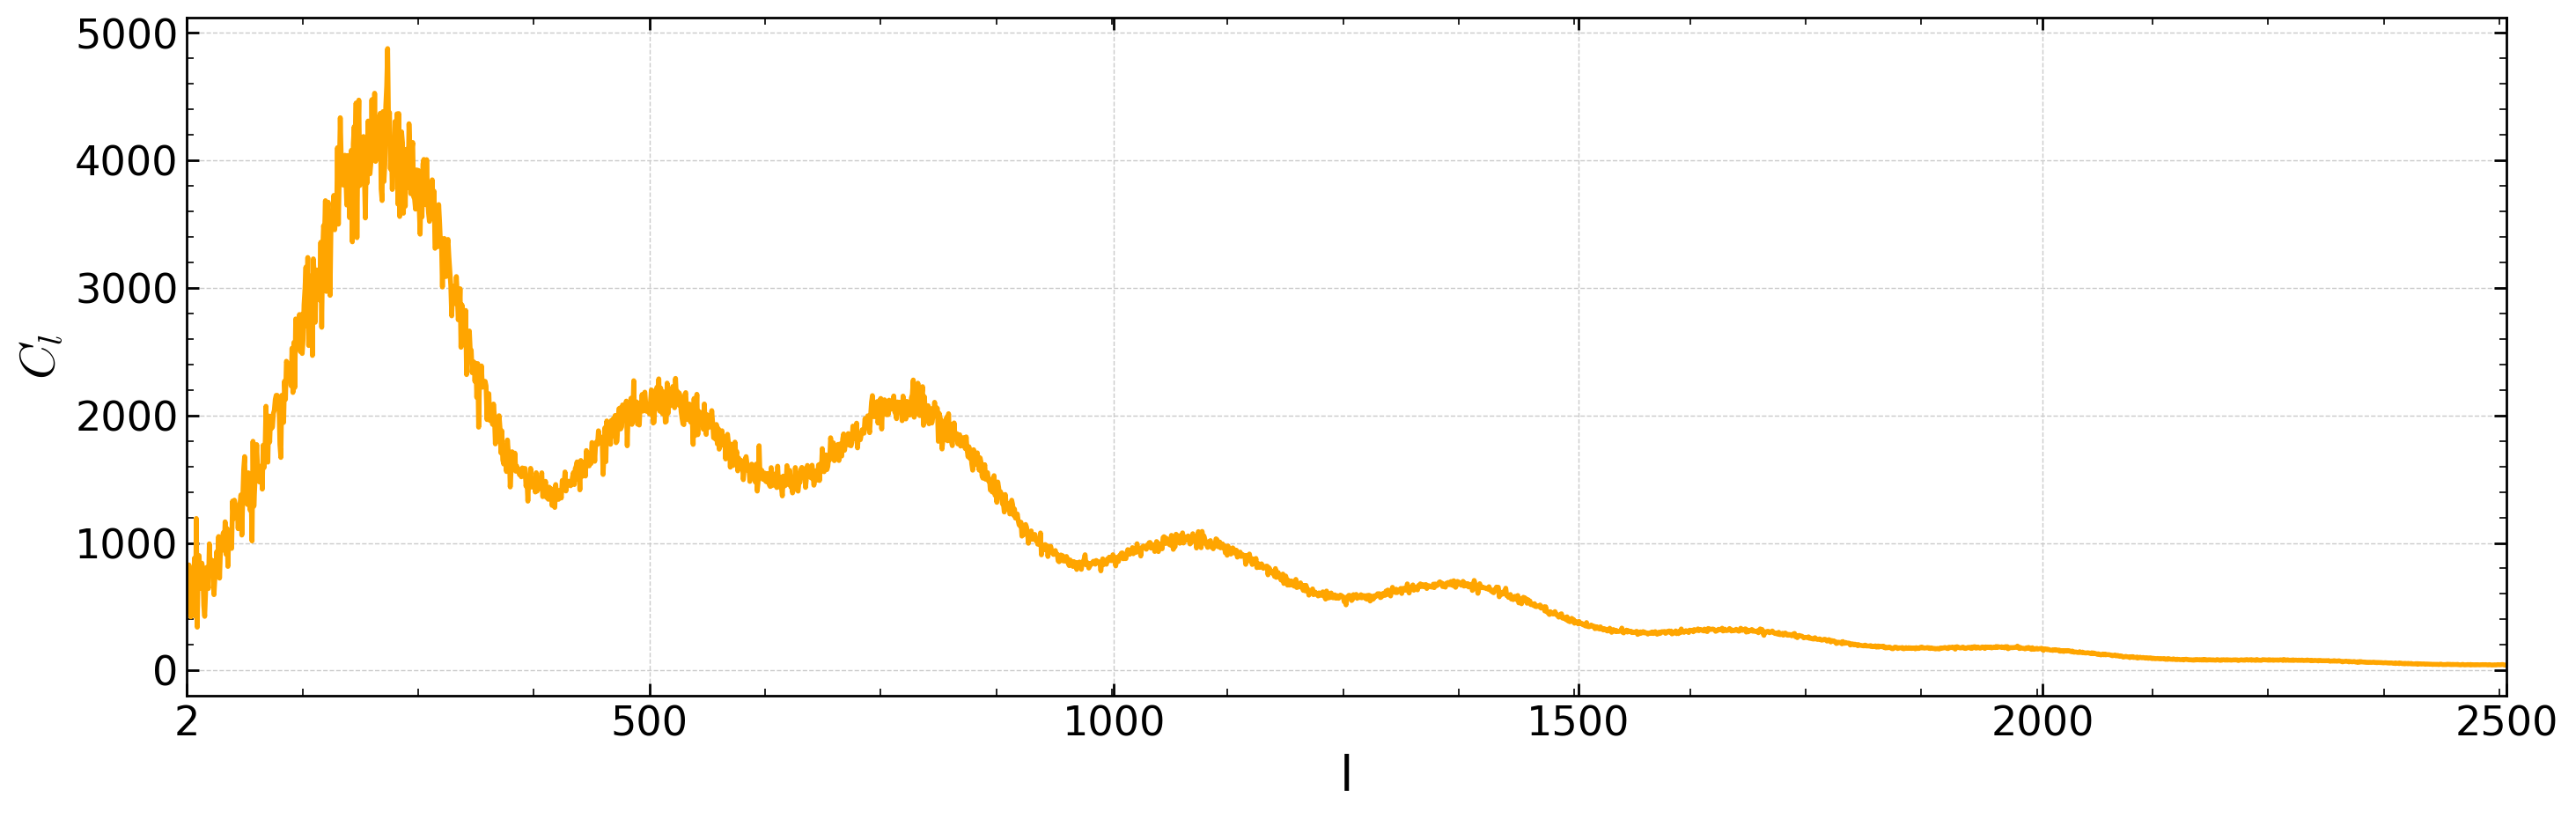

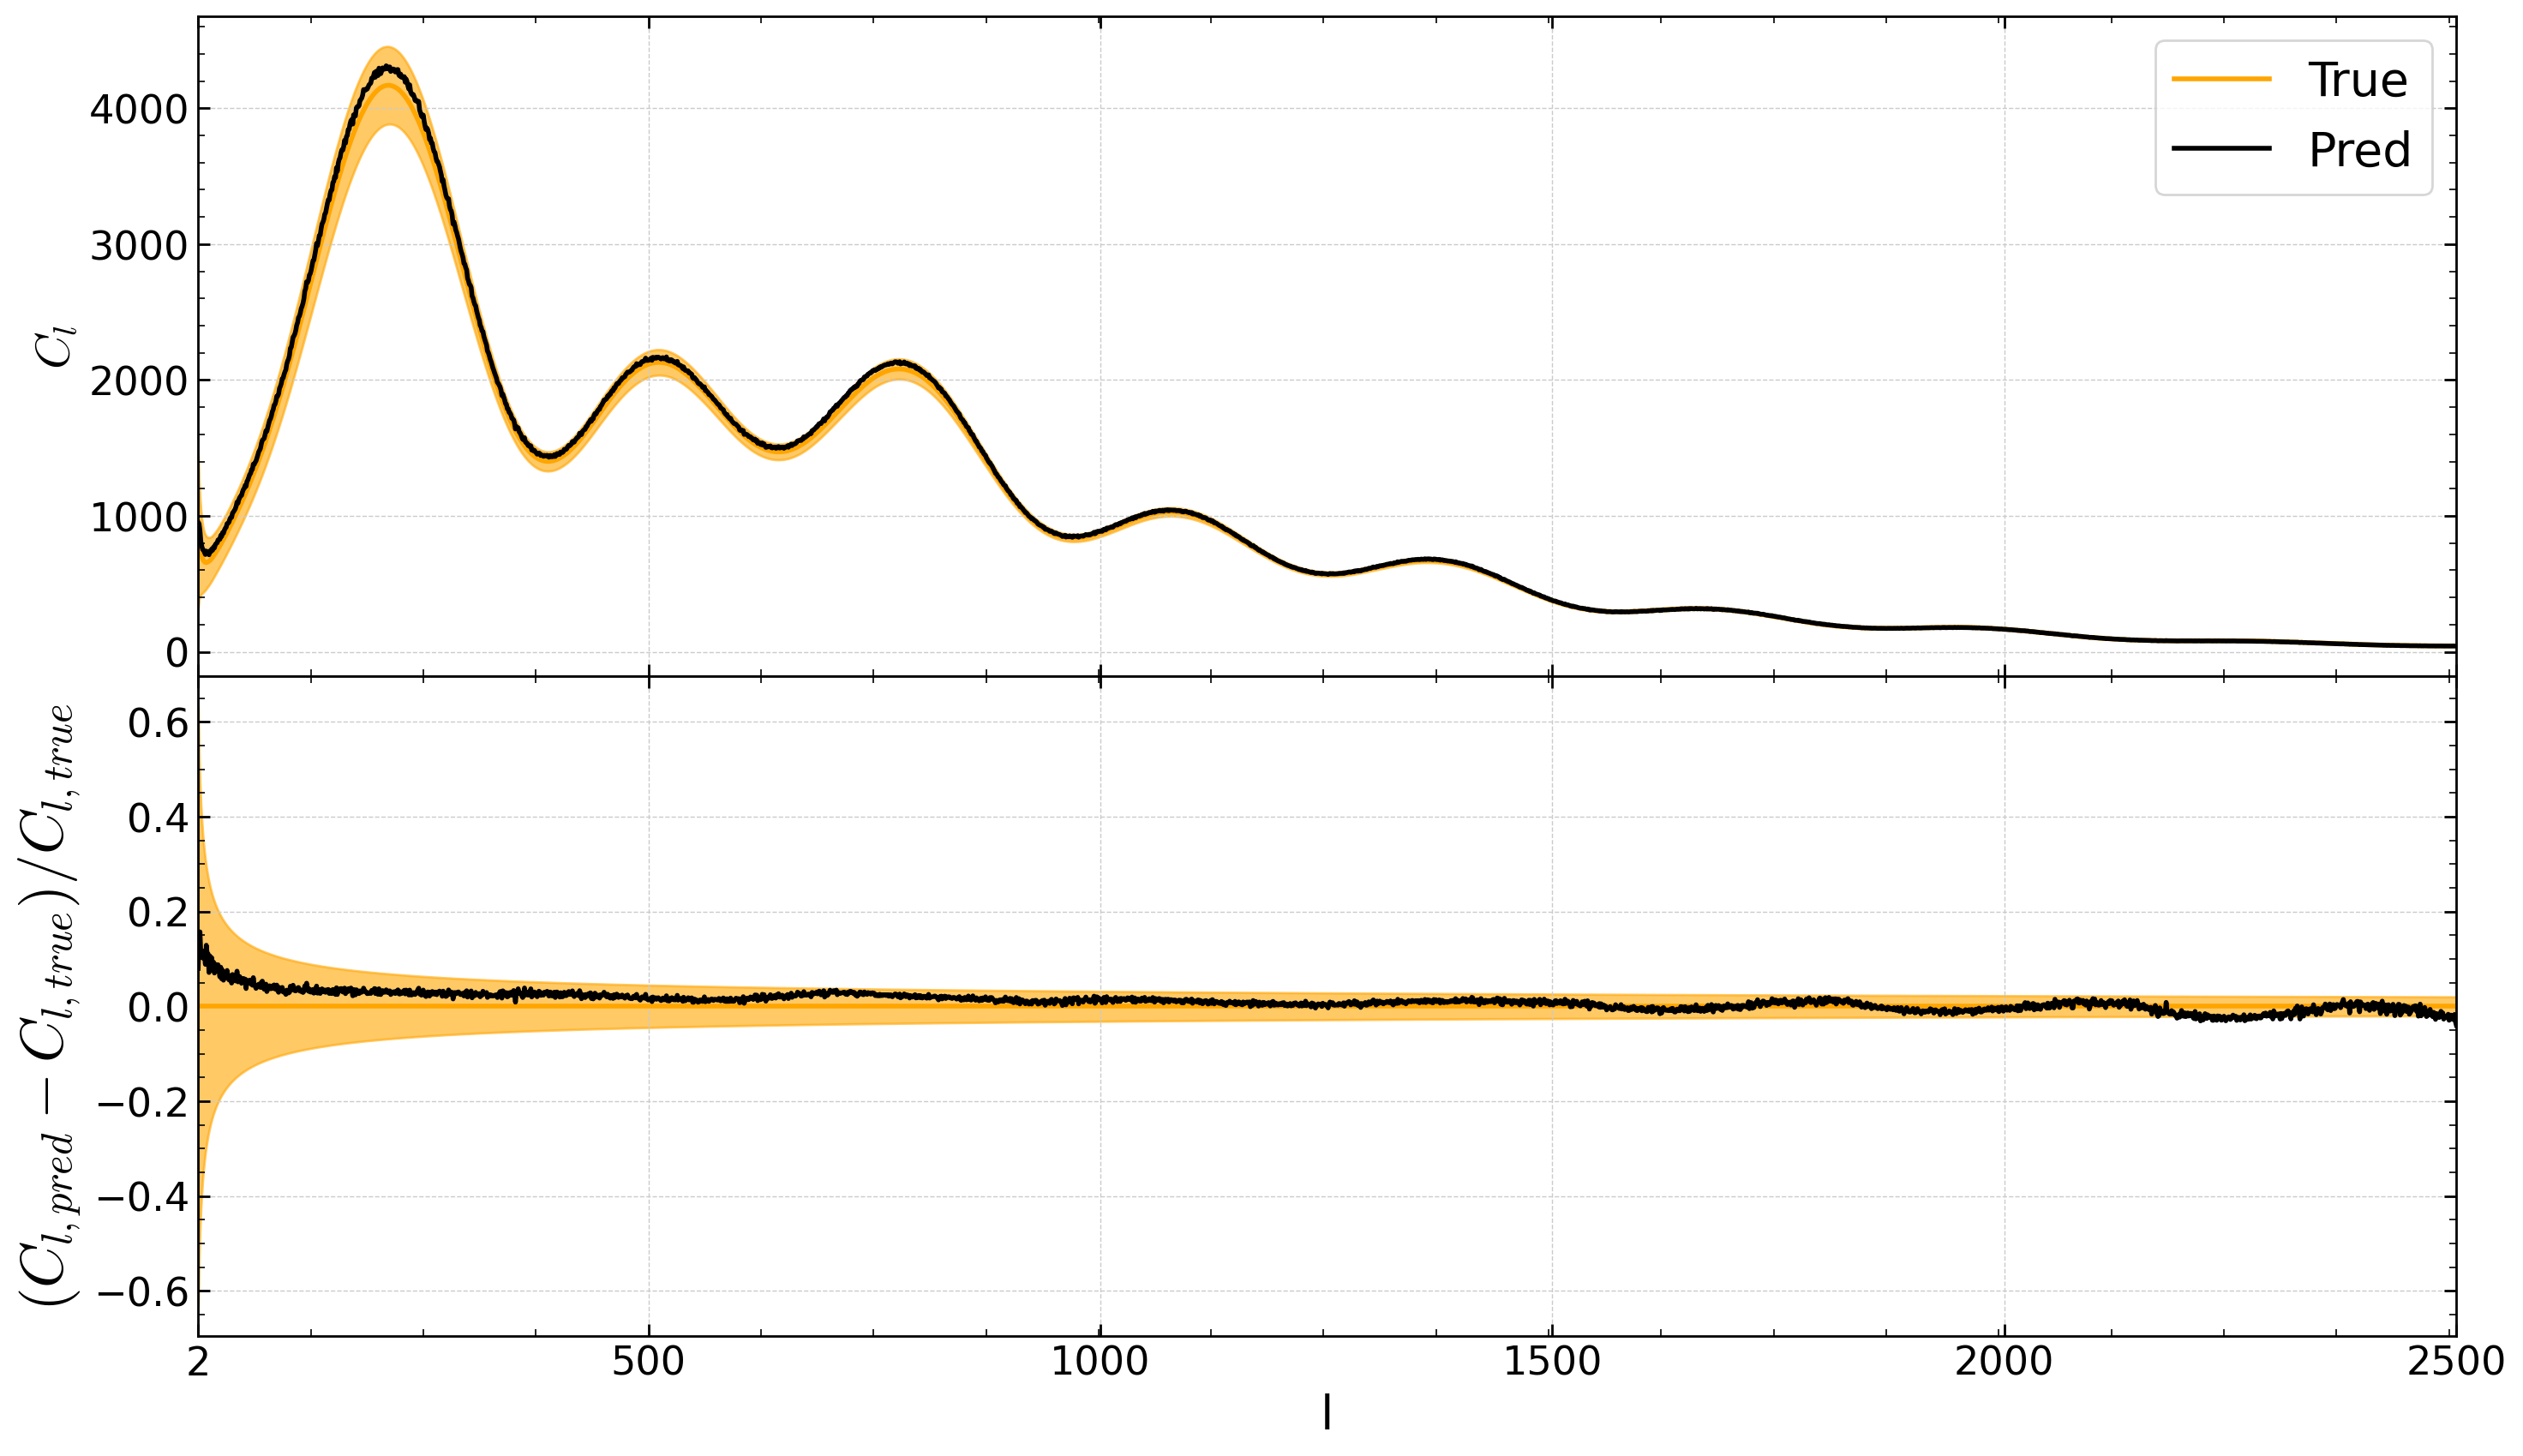

In [207]:
plt.figure(figsize=(17,5))
l = np.arange(2,2501)

plt.plot(l,true[0],label='With cosmic variance',color='orange')
plt.xlabel('l')
plt.ylabel(r'$C_l$')
plt.xlim(2,2500)
plt.xticks([2,500,1000,1500,2000,2500])
plt.savefig('./example.pdf')

fig,ax=plt.subplots(figsize=(17,10),nrows=2,ncols=1,sharex=True,gridspec_kw={'hspace':0.0005})
ax[0].plot(l,mean[0],color='orange',label='True',linewidth=2)
ax[0].plot(l,pred[0],label='Pred',color='k')
ax[0].fill_between(l, mean[0]-torch.sqrt(err[0]), mean[0]+torch.sqrt(err[0]), color='orange',
                 alpha=0.6)
ax[0].set_ylabel(r'$C_l$',fontsize=20)
ax[0].legend(fontsize=20)
ax[0].set_xlim(2,2500)

ax[1].axhline(0., color="orange", linestyle="-",linewidth=2)
ax[1].plot(l,(pred[0]-mean[0])/mean[0],color='k')
ax[1].fill_between(l, (-torch.sqrt(err[0]))/mean[0], (torch.sqrt(err[0]))/mean[0], color='orange',
                 alpha=0.6)
ax[1].set_xlabel('l')
ax[1].set_ylabel(r'$\left(C_{l,pred}-C_{l,true}\right)/C_{l,true}$',fontsize=25)
ax[1].set_xlim(2,2500)
ax[1].set_xticks([2,500,1000,1500,2000,2500])
plt.savefig('./replace.pdf')

print ('average weighted MLE (negative log likelihood)',torch.median(torch.mean((mean-pred)**2/err,1)))

In [205]:
test_losses_onloader_onemodel_parato.shape

(500,)

The weighted MSE: 0.5218015888346972


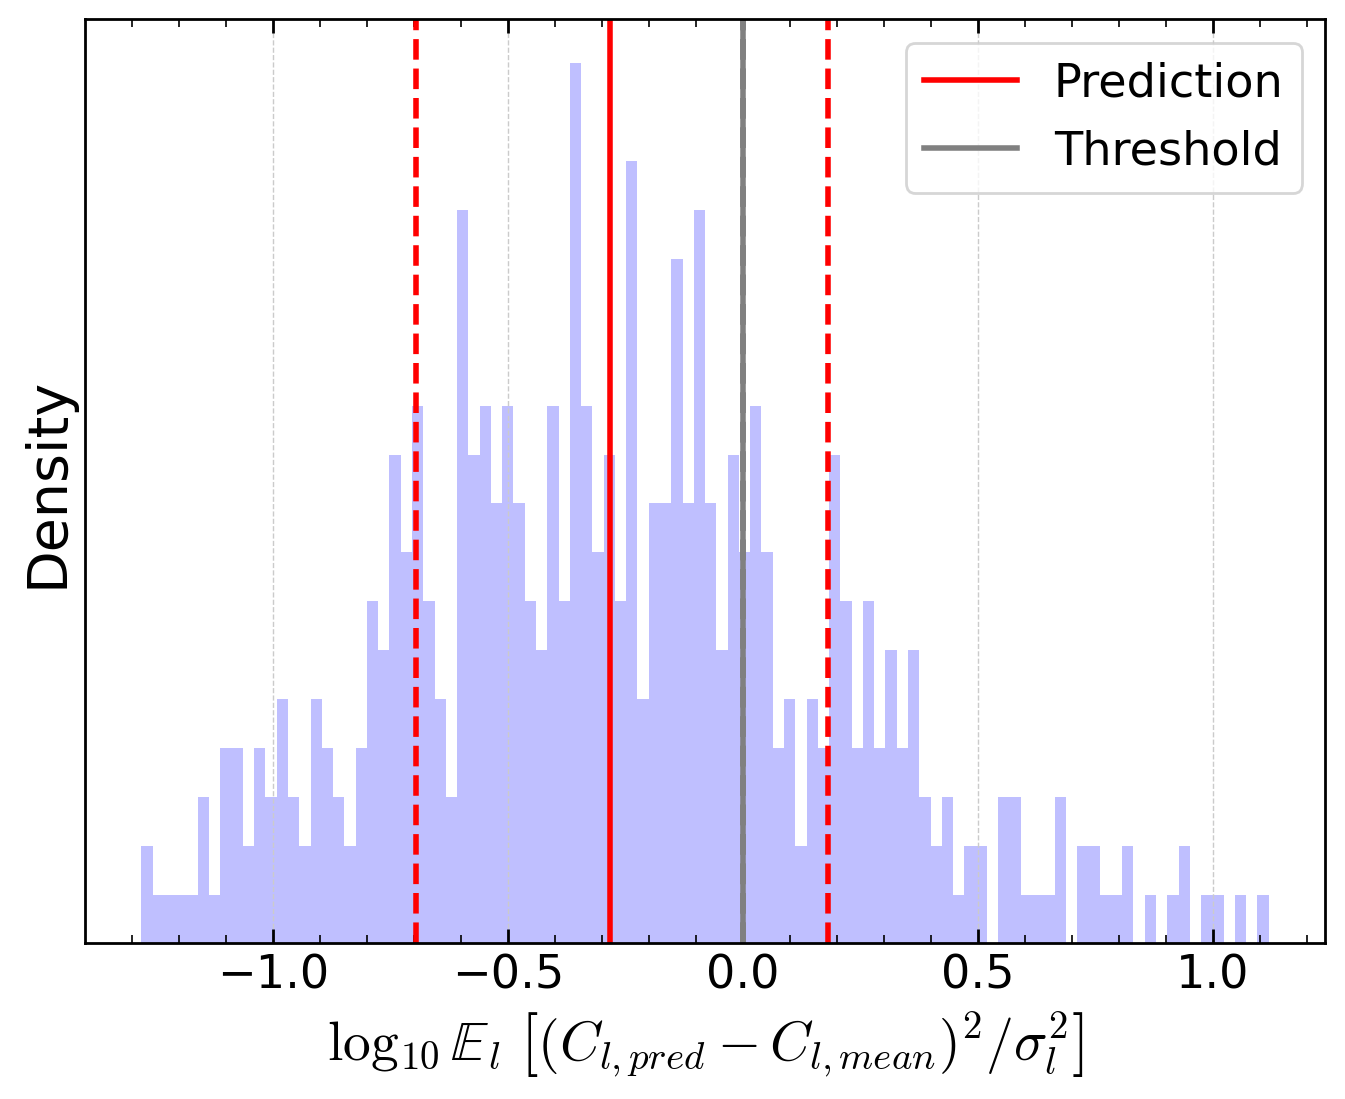

"\nfor i in range(len(complexity)):\n    print ('raw expression:',data0['infix'][i])\n    print ('*****')\n    pprint (data0['infix'][i].replace('^','**'))\n    print ('***********************************')\n"

In [206]:
### Plot the results
# The weighted loss
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(np.log10(test_losses_onloader_onemodel_parato), bins=100,density=False,color='blue',alpha=0.25)

ax.set_xlabel(r'$\log_{10} \mathbb{E}_l\ \left[(C_{l,pred}-C_{l,mean})^2/\sigma_l^2 \right]$')
ax.set_ylabel('Density')
ax.axvline(np.log10(np.median(test_losses_onloader_onemodel_parato)), color="red", linestyle="-",label='Prediction') # The threshold for the weighted error (likelihood)
ax.axvline(np.log10(np.percentile(test_losses_onloader_onemodel_parato,50-32)), color="red", linestyle="--")
ax.axvline(np.log10(np.percentile(test_losses_onloader_onemodel_parato,50+32)), color="red", linestyle="--")

ax.axvline(np.log10(1.), color="grey", linestyle="-",label='Threshold') # The threshold for the weighted error (likelihood)
ax.axvline(np.log10(np.sqrt(1.-2/2499)), color="grey", linestyle="--") 
ax.axvline(np.log10(np.sqrt(1.+2/2499)), color="grey", linestyle="--") 

ax.legend()
ax.set_yticks([])
print ('The weighted MSE:',np.median(np.array(test_losses_onloader_onemodel_parato)))
plt.show()
plt.close()

'''
for i in range(len(complexity)):
    print ('raw expression:',data0['infix'][i])
    print ('*****')
    pprint (data0['infix'][i].replace('^','**'))
    print ('***********************************')
'''

In [30]:
print (test_losses_onloader_onemodel_parato[0].shape)

(500, 2499)


#### Inspect the individual expression from operon 
Totally 2000 expressions for each latent. Might be computationally expensive, set a proper `interval` value which just thin the number of expressions

In [178]:
interval=200 # display every 200 equations for fewer computational costs

(10, 500)


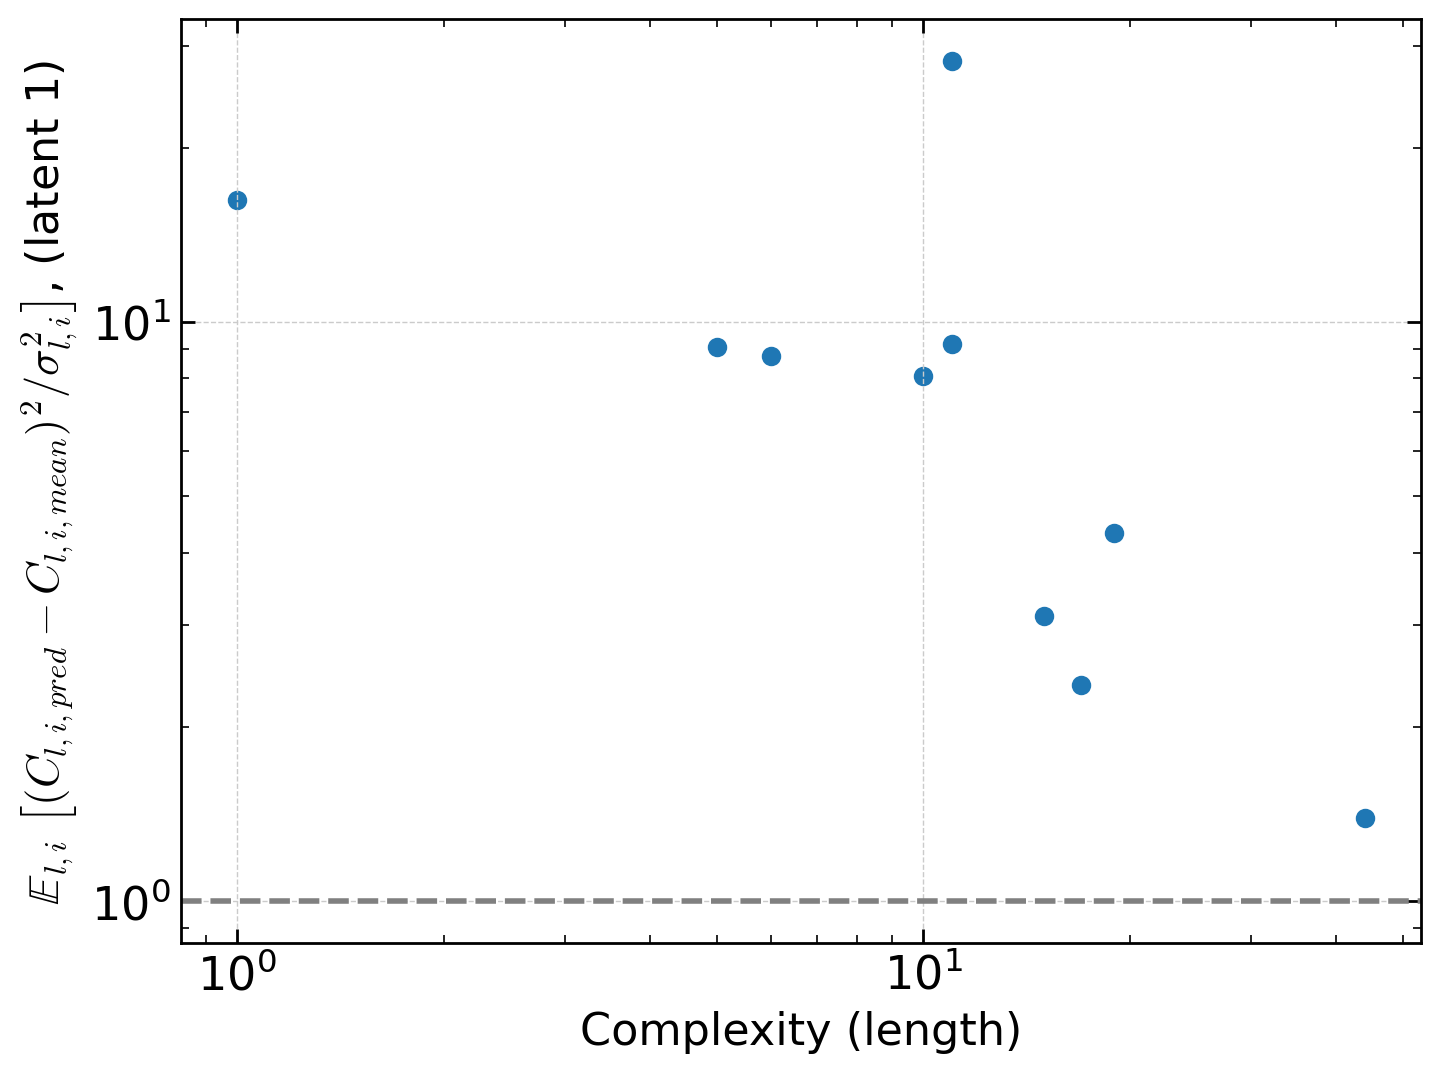

(10, 500)


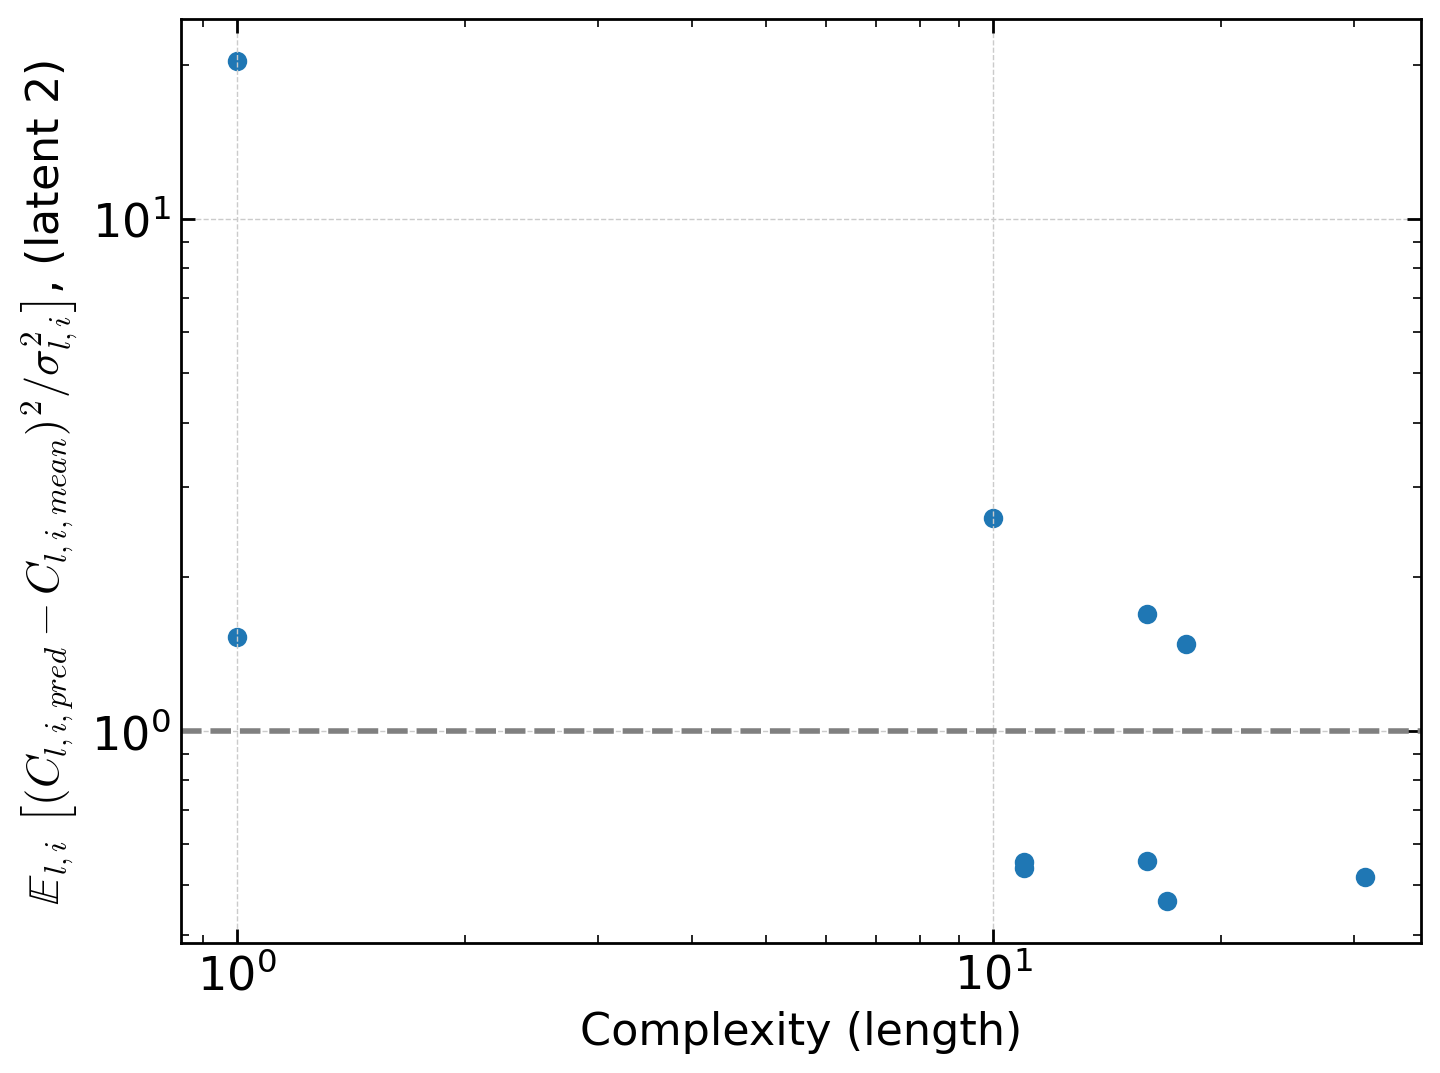

(10, 500)


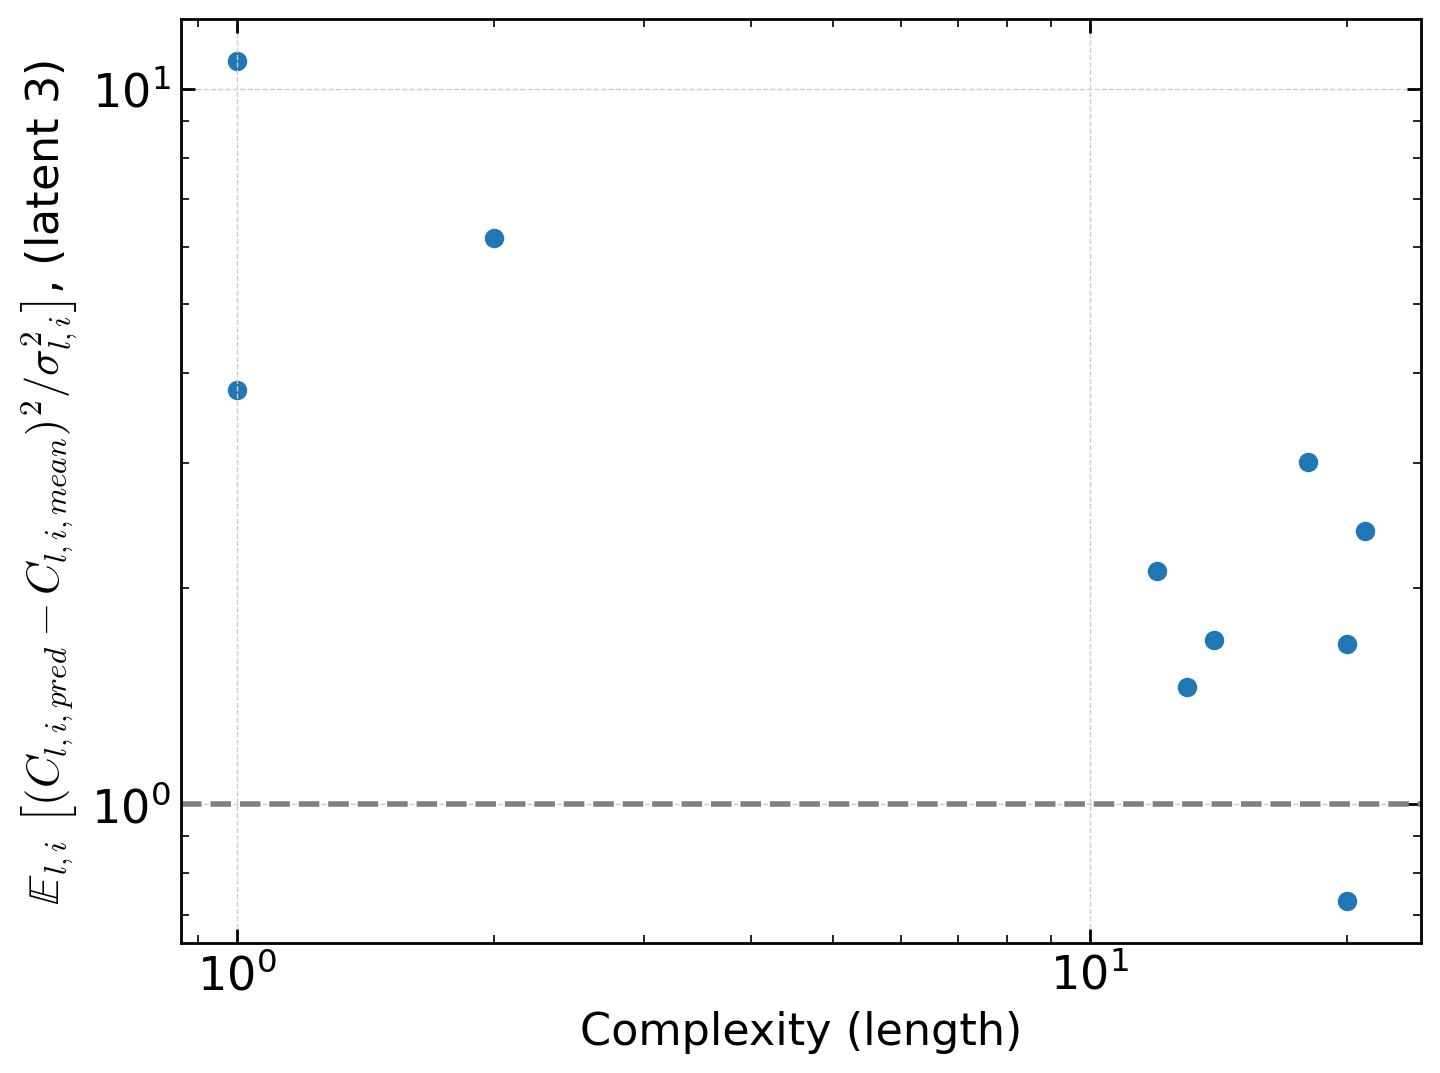

(10, 500)


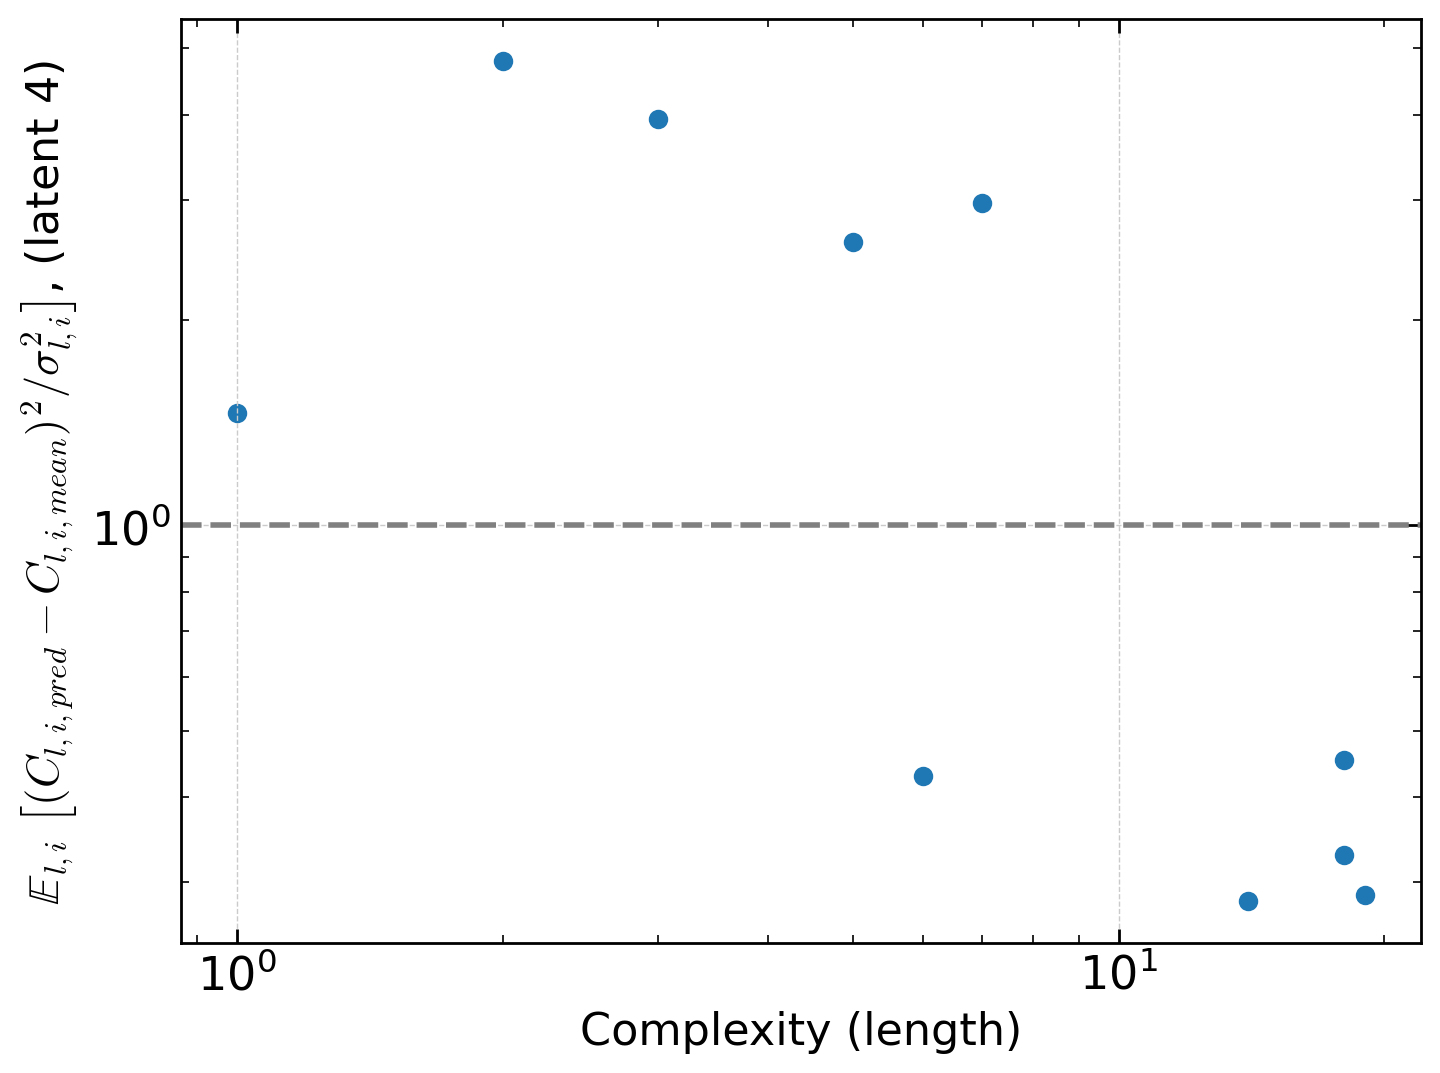

(10, 500)


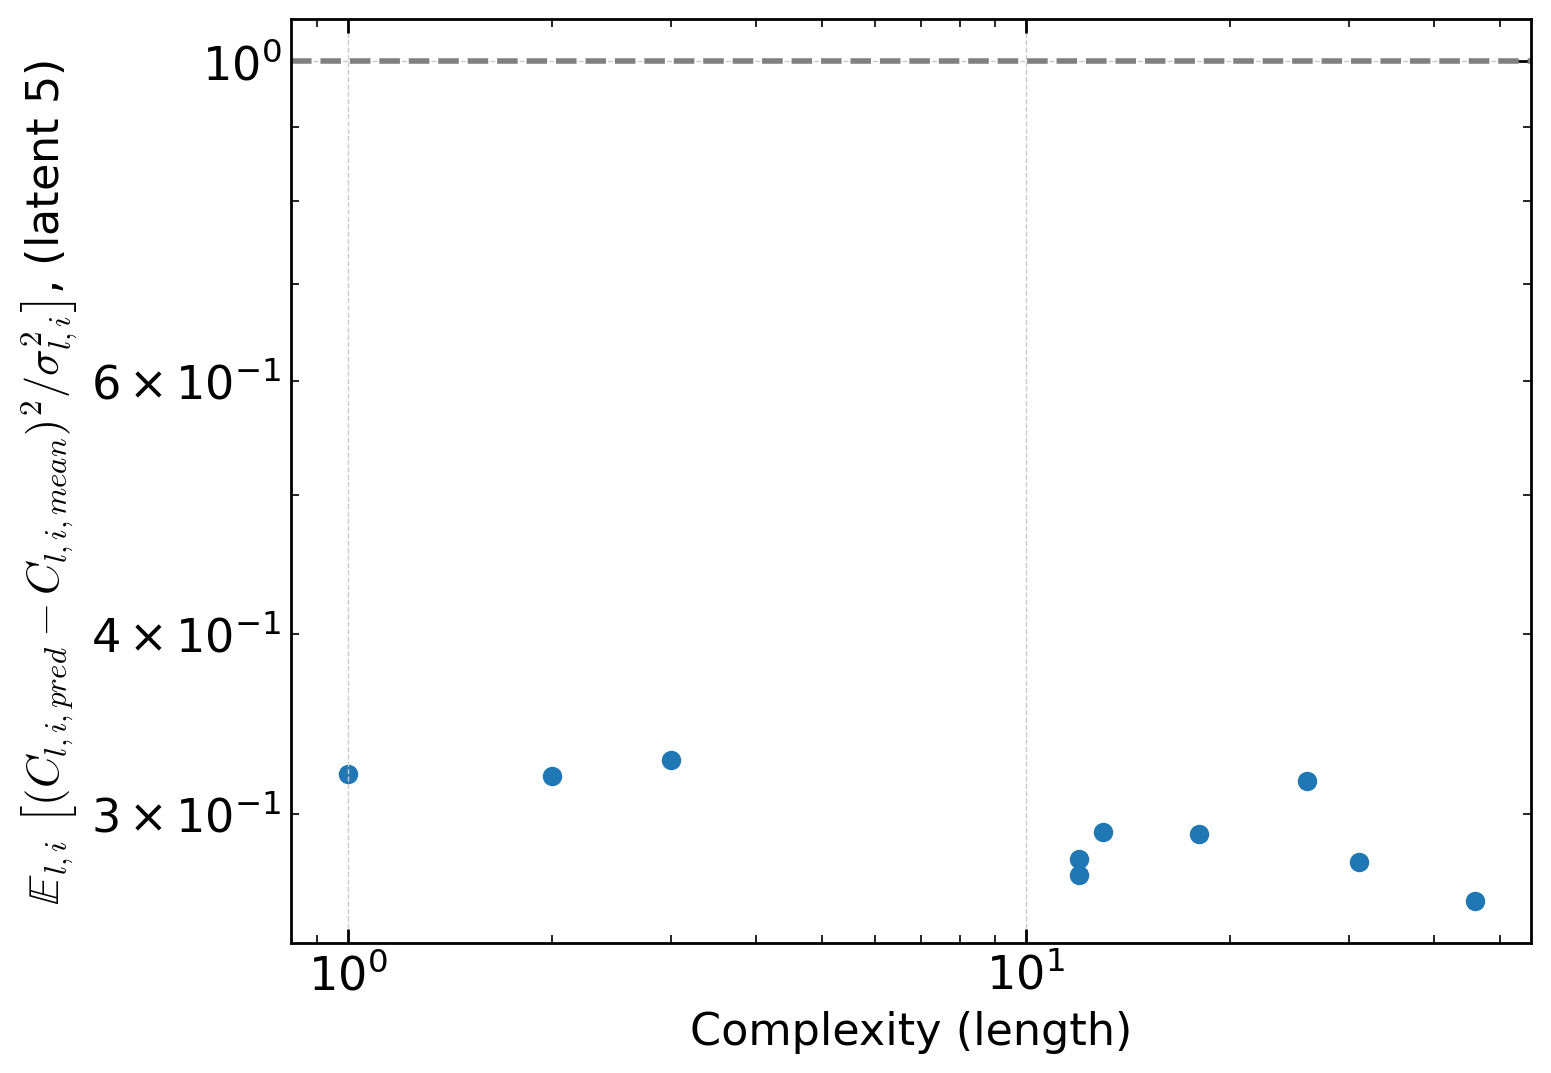

(10, 500)


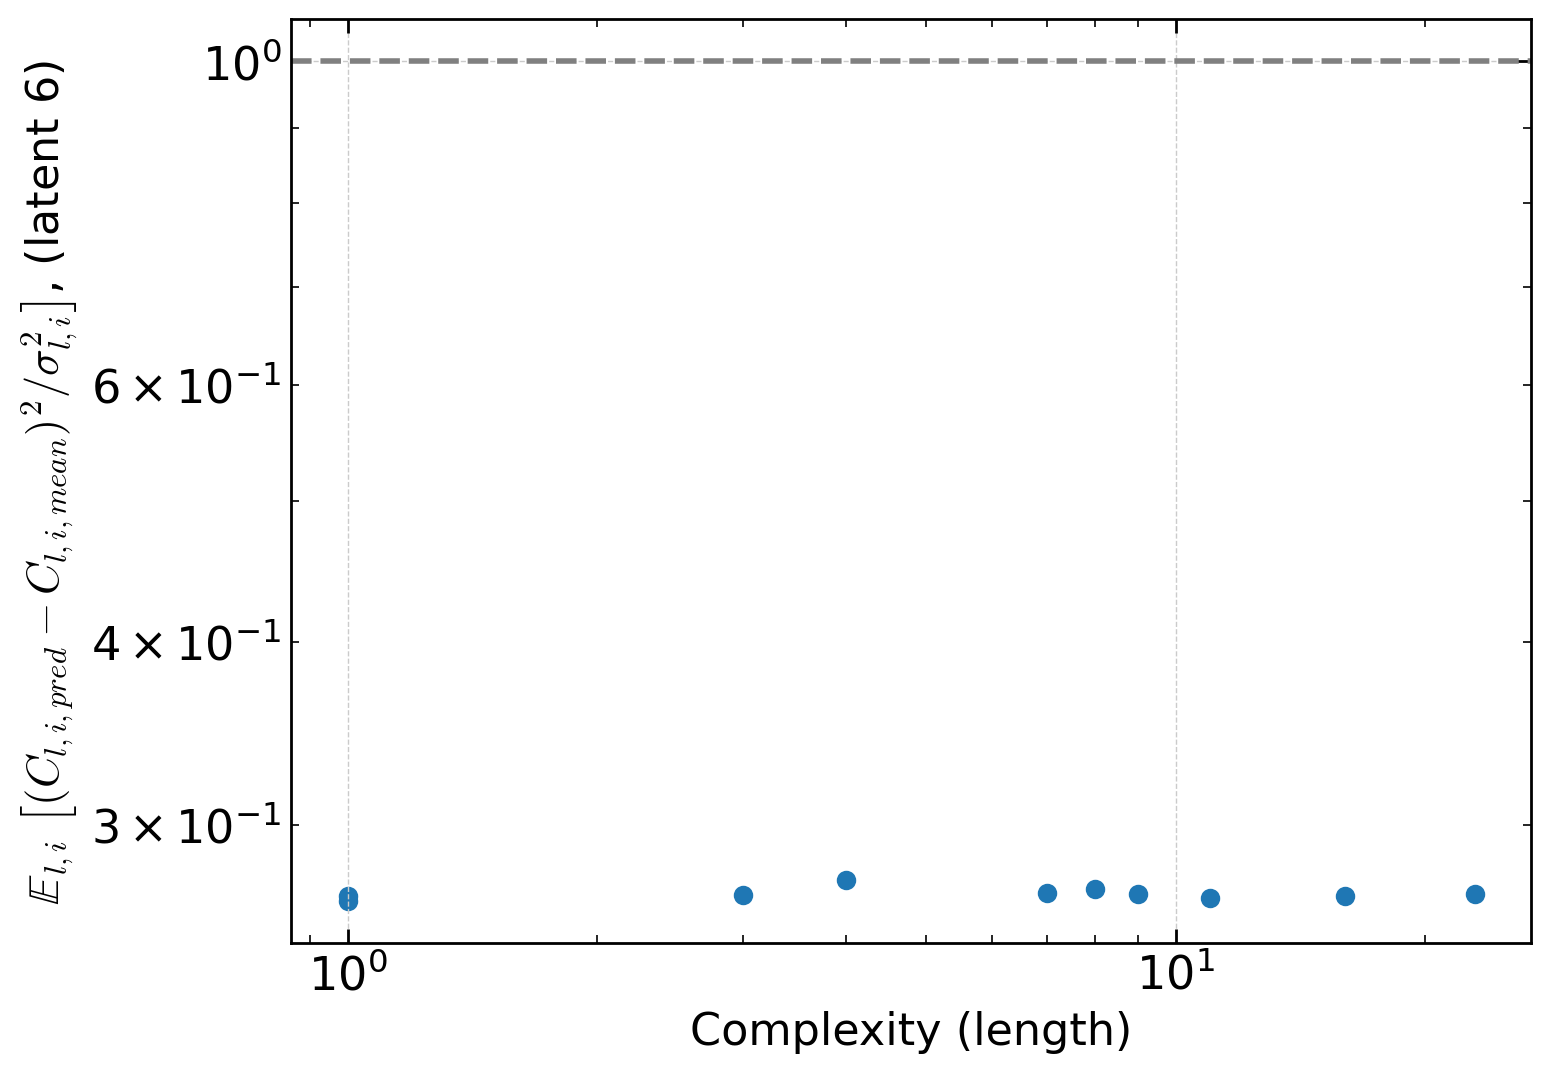

In [185]:
torch.manual_seed(43)
import pandas as pd

### Testing function for the retrained model
def test_epoch_replace(encoder, decoder, device, dataloader, loss_fn,maskindex, ind, ind_var):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for (1) batch of 500 testing samples
        conc_out = [] 
        conc_data_mean = [] 
        conc_err = []
        
        # Mask
        range_index=torch.arange(1, d_encode+1)
        mask = range_index.le(maskindex).unsqueeze(0).to(device)

        count = 0

        #param = torch.tensor(np.float32(np.load('./data/camb_new_processed/param_%s_%s.npy'%(types,name))))
        #data_batch_mean = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_mean_%s_%s.npy'%(types,name))))
        #err = torch.tensor(np.float32(np.load('./data/camb_new_processed/error_%s_%s.npy'%(types,name))))
        #data_batch = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_%s_%s.npy'%(types,name))))
        
        param = torch.tensor(np.float32(np.load('./data/camb_new_processed/param_%s.npy'%(name))))
        data_batch_mean = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_mean_%s.npy'%(name))))
        err = torch.tensor(np.float32(np.load('./data/camb_new_processed/error_%s.npy'%(name))))
        data_batch = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_%s.npy'%(name))))
            
        data_batch = data_batch.to(device)
        param = param.to(device)
        err = err.to(device)
        #data = data.to(device)
        
        # Encode data
        encoded_data= encoder(param)
        maskin_data = maskin(encoded_data)
        
        # Replacement
        sr_pred_i = sr_pred[ind] # Dimension: each ind has 500, the # of the testing samples
        maskin_data[:,ind_var] = sr_pred_i.to(device)
        
        # Decode data
        #decoded_data = decoder(maskin_data*mask)
        decoded_data = decoder(maskin_data)
        
        conc_out.append(trans(decoded_data.cpu()))
        conc_data_mean.append(trans(data_batch_mean[:,:]))
        conc_err.append(trans_error(trans(data_batch.cpu()[:,:])[:,0,:],err.cpu()))
                               
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_data_mean = torch.cat(conc_data_mean)
        conc_err = torch.cat(conc_err)

        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_data_mean[:,:],conc_err)
    return val_loss.data

### Define the loss function
#loss_fn = torch.nn.MSELoss()
def loss_fn(output, target, weight):
    loss = torch.mean((output - target)**2/weight,1)
    return loss

encoder = Encoder_cmb(encoded_space_dim=d_encode)
decoder = Decoder_cmb(encoded_space_dim=d_encode)
maskin = maskin_cmb()

model_state_save_early_path_checkpoint ='./model/checkpoint_%s.tar'%(name)
checkpoint_model = torch.load(model_state_save_early_path_checkpoint)
encoder.load_state_dict(checkpoint_model['encoder_state_dict'])
decoder.load_state_dict(checkpoint_model['decoder_state_dict'])
maskin.load_state_dict(checkpoint_model['maskin_state_dict'])

encoder.eval()
encoder.to(device)
decoder.eval()
decoder.to(device)
maskin.eval()
maskin.to(device)

maskindex = 6

#interval=200 # 200 for fewer computational costs
for ind_var in range(maskindex):
    #test_name = operon_name+'latent%d'%ind_var
    test_name = types+'_'+runs+'_'+'latent%d'%ind_var # index of the latent variable
    test_losses_onloader_onemodel_individual=[]
    
    # sr prediction: [len(expressions),500], i.e. [2000,500]
    sr_pred = torch.tensor(np.float32(np.load('./data/sr/pred_individuals_%s.npy'%test_name)))
    # expressions: [len(expressions),]
    data0=pd.read_csv('./data/sr/individuals_%s.csv'%test_name) 
    
    num_plot = 2000 #10 # number of individuals in the operon setting is 2000
    for ind in range(0,num_plot,interval):
        temp=test_epoch_replace(encoder, decoder, device, test_loader, loss_fn,maskindex, ind, ind_var) # Here the test_loader
        test_losses_onloader_onemodel_individual.append(temp)
        
    complexity=pd.read_csv('./data/sr/individuals_%s.csv'%test_name)['length'].values[::interval]
    
    test_losses_onloader_onemodel_individual = np.array(test_losses_onloader_onemodel_individual)
    print (np.array(test_losses_onloader_onemodel_individual).shape)
    arg = np.argsort(complexity)
    complexity = complexity[arg]
    test_losses_onloader_onemodel_individual = test_losses_onloader_onemodel_individual[arg]

    fig,ax = plt.subplots(figsize=(8,6))
    ax.scatter(complexity,np.percentile(test_losses_onloader_onemodel_individual,50,axis=1))
    ax.set_xlabel('Complexity (length)',fontsize=16)
    ax.set_ylabel(r'$\mathbb{E}_{l,i} \ \left[(C_{l,i,pred}-C_{l,i,mean})^2/\sigma_{l,i}^2 \right]$, (latent %d)'%(ind_var+1),fontsize=16)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.axhline(1., color="grey", linestyle="--") # The threshold for the weighted error (likelihood)
    #ax.legend(fontsize=11)
    plt.show()
    plt.close()
    